# IS4226 Mid Term

1. Develop backtesters for these strategies and test the strategy on in-sample data
    1. To keep things simple, all groups will test their strategy on an equal weighted portfolio of MAANG stocks from 01/01/2015 to 31/12/2019 on daily frequency data.
    2. Please note that this time, you need to do just in-sample testing and report what different variations you have tried.  In the final semester project, You will do out-of-sample testing to finalize strategies.
1. Prepare a notebook with significant markups, and please explain your code through comments. 
2. Please also describe the idea/strategy in the notebook at the start. The more understandable your notebook, the better it will be.
3. Report Strategy Risk, Returns, and performance metrics for MAANG stocks portfolio. Visualizations are optional but will be a bonus if you do that.

# Strategy 1 : Market capitalization-weighted RSI momentum strategy

# Introduction
A simple RSI(Relative Strength Index) trades solely on the information on the price of a stock. However, this is a huge limitation, given that most stocks are correlated with stocks in the same industry. Given this assumption, we develop a Market Cap Weighted RSI that aims to capture market information, which we can then use to trade the momentum of a stock given its current RSI. 


## RSI
RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is typically used to identify overbought or oversold conditions in a traded security.

$RSI = 100 - [\frac{100}{1 + RS}]$, where $RS = \frac{\text{Average Gain}}{\text{Average Loss}}$

- Interpretation
    - RSI > 70: Potentially overbought
    - RSI < 30: Potentially oversold
    - 50 is considered neutral

## Market Cap Weighted RSI
Market Cap Weighted RSI is a variation of the traditional RSI that takes into account the market capitalization of each security in a portfolio or index. Market Capitalization (MC) represents the value of a company's outstanding shares in the stock market. A high market cap indicates a higher value in the stock market, 

${RSI_{mc}} = \sum (RSI_s \times W_s)$
- Where
  - $RSI_i$ is the RSI of security s
  - $W_s$ is the weight of security s based on its market cap, MC
    - $W_s = \frac{\text{Market Cap of security s}}{\text{Total Market Cap of all securities}}$
    - $\text{Market Capitalization} = \text{Current Share Price} \times \text{Total Number of Outstanding Shares}$

## RSI Delta
To measure whether a security is overbought or oversold using RSI and Market Cap Weighted RSI, we derive the formula RSI Delta, which is the different between the security's RSI, and the Market Cap Weighted RSI.

$ RSI_{delta} = RSI_s - \text{Market Cap Weighted RSI} $

- Interpretation
  - $RSI_{delta}$ > 10: Security s is overbought compared to the Market Cap Weighted RSI.
  - $RSI_{delta}$ > 10: Security s is oversold compared to the Market Cap Weighted RSI.

## Strategy
We utilize RSI Delta to trigger long/short signals. We hypothesize that the RSI_s should follow the RSI_{mc} in the long term, and RSI_{delta} should revert after crossing a threshold.

-  Long : $RSI_{delta}$ > Upper Treshold - Security s is overbought compared to the market. We RSI_{delta} to mean revert after having strong short term momentum, so price should decrease.
-  Short : $RSI_{delta}$ < Lower Treshold - Security s is oversold compared to the market. We RSI_{delta} to mean revert after having weak short term momentum, so price should increase.

## Limitations and Improvements
1. Security specific news
   1. Whenever there is a news that happens that is specific to a company, but not industry wide. eg. [Why Intel Stock Is Falling and Hit a New 10-Year Low Today](https://www.nasdaq.com/articles/why-intel-stock-falling-and-hit-new-10-year-low-today#:~:text=Uncertainty%20surrounds%20Intel's%20outlook&text=Quarterly%20margins%20and%20guidance%20came,workforce%20and%20other%20big%20moves.)
      1. Incorporating a event-based signal into the portfolio
      2. 
2. Manual Selection of Industry Weighted RSI
   1. Selection limits the optimization of finding the best basket of Industry stocks for the MC-weighted RSI
      1.  
   2. Securities in the basket might have low correlation with underlying security despite being in the same industry
3. Optimization Techniques to find the best strategy
   1. Combining all the possible signals
   2. Portfolio Optimization Techniques
      1. [Portfolio Optimization Methods](https://blog.quantinsti.com/portfolio-optimization-methods/)
      2. 

# Implementation
## 1. YFinanceStrategy
Base strategy class for an individual stock. Override strategy() to run a strategy.

Further Improvements:
1. Adding an equal weighted portfolio as benchmark.

## 2. YFinancePortfolio - Portofolio class for multiple strategies.
Portfolio class that takes in a list of portfolios, weights and measures the peformance of the portfolio. 

Further Improvements:
1. Adding position sizing and starting portfolio.
2. Adding leverage for better strategies.

## Resources
- Backtesting
  - [backtesting](https://kernc.github.io/backtesting.py/doc/backtesting/#gsc.tab=0)
  - [bt](https://pmorissette.github.io/bt/)
  - [zipline](https://zipline.ml4trading.io/)
- Portfolio Optimization
  - [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/)
  - 

# Data

In [1]:
maang_stocks = [
    "MSFT",  # Microsoft
    "AAPL",  # Apple
    "AMZN",  # Amazon
    "NFLX",  # Netflix
    "GOOGL"  # Alphabet (Google)
]

# YFinanceStrategy - Analysis of a single strategy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import yfinance as yf
from datetime import datetime, timezone, timedelta
from matplotlib.gridspec import GridSpec

def prepare_data(symbol: str, start_date: str, end_date: str, interval: str) -> pd.DataFrame:
    """
    Prepare stock data including market cap for a given symbol. Override if more data is needed.
    
    :param symbol: Stock symbol (e.g., 'AAPL')
    :param start_date: Start date for historical data (e.g., '2020-01-01'). (YYYY-MM-DD)
    :param end_date: End date for historical data(e.g., '2020-01-01'). (YYYY-MM-DD)
    :param interval: Data interval (default is '1d' for daily)
    :return: DataFrame with prepared stock data
    """
    # Fetch stock data
    data = yf.Ticker(symbol)
    # Get historical data
    df = data.history(start=start_date, end=end_date, interval=interval).reset_index()
    # Convert date to UTC timestamp
    df['timestamp_utc'] = (pd.to_datetime(df['Date']).dt.tz_convert('UTC').astype(int) // 10**6)
    # Calculate returns and log returns
    df['returns_close'] = (df['Close'] / df['Close'].shift(1)) - 1
    df['logreturns_close'] = np.log(df['Close'] / df['Close'].shift(1))
    info = data.info
    market_cap = info.get('marketCap', None)
    df['MC'] = market_cap
    # Sort and reset index
    df = df.sort_values(by='timestamp_utc', ascending=True).reset_index(drop=True)
    return df

def calculate_beta(returns_strategy, returns_benchmark):
    covariance = np.cov(returns_strategy.dropna(), returns_benchmark.dropna())[0, 1]
    benchmark_variance = np.var(returns_benchmark.dropna())
    return covariance / benchmark_variance if benchmark_variance != 0 else np.nan

def calculate_alpha(beta, df_strategy, strategy_column, df_benchmark, benchmark_column, risk_free_rate):
    annualized_returns_strategy = calculate_annualized_return(df_strategy, strategy_column)
    annualized_returns_benchmark = calculate_annualized_return(df_benchmark, benchmark_column)
    return annualized_returns_strategy - (risk_free_rate + beta * (annualized_returns_benchmark - risk_free_rate))

def calculate_annualized_return(dataframe, column_name):
    total_return = (1 + dataframe[column_name]).prod() - 1
    n_years = len(dataframe) / 252  # Assuming 252 trading days in a year
    return (1 + total_return) ** (1 / n_years) - 1


class YFinanceStrategy:
    def __init__(self, symbol: str, start_date: str, end_date: str, interval: str, params : dict = {}, benchmark_symbol : str = "^GSPC", risk_free_rate : float = 0.0) -> None:
        self.symbol = symbol
        self.benchmark_symbol = benchmark_symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.params = params
        self.trades = None
        self.performance = None
        self.data_strategy = prepare_data(symbol=self.symbol, start_date=self.start_date, end_date=self.end_date, interval=self.interval)
        self.data_benchmark = prepare_data(symbol=self.benchmark_symbol, start_date=self.start_date, end_date=self.end_date, interval=self.interval)
        self.risk_free_rate = risk_free_rate
    def strategy(self) -> pd.DataFrame:
        """
        Generate a signal column, 1 for Long, -1 for Short, 0 for no position.
        """
        raise NotImplementedError("Strategy method must be implemented")

    def generate_trades(self, strategy_signal_column='signal', strategy_price_column='Close') -> pd.DataFrame:
        """
        Calculate trades based on the strategy signal.
        """
        if self.data_strategy is None:
            raise ValueError("Data must be fetched first. Try calling self.fetch_data()")
        if self.data_strategy[strategy_signal_column].mean() == 0:
            print("No trades executed")
            self.trades = []
        
        self.data_strategy['signal_change'] = self.data_strategy[strategy_signal_column] != self.data_strategy[strategy_signal_column].shift(1)
        
        trades = []
        open_trade = None

        for idx, row in self.data_strategy[self.data_strategy['signal_change']].iterrows():
            current_signal = row[strategy_signal_column]
            
            if open_trade is None:
                if current_signal != 0:
                    open_trade = {
                        'entry_datetime': datetime.fromtimestamp(row['timestamp_utc'] / 1000, tz=timezone.utc),
                        'entry_price': row[strategy_price_column],
                        'position': current_signal
                    }
            else:
                exit_datetime = datetime.fromtimestamp(row['timestamp_utc'] / 1000, tz=timezone.utc)
                duration = exit_datetime - open_trade['entry_datetime']
                exit_price = row[strategy_price_column]
                pnl = (exit_price - open_trade['entry_price']) * open_trade['position']
                pnl_pct = (pnl / abs(open_trade['entry_price'])) * 100
                
                trades.append({
                    'entry_datetime': open_trade['entry_datetime'],
                    'exit_datetime': exit_datetime,
                    'duration': duration,
                    'entry_price': open_trade['entry_price'],
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'pnl%': pnl_pct,
                    'position': open_trade['position'],
                    'win': 1 if pnl > 0 else 0
                })
                
                if current_signal != 0:
                    open_trade = {
                        'entry_datetime': exit_datetime,
                        'entry_price': exit_price,
                        'position': current_signal
                    }
                else:
                    open_trade = None
        
        if open_trade is not None:
            last_row = self.data_strategy.iloc[-1]
            exit_datetime = datetime.fromtimestamp(last_row['timestamp_utc'] / 1000, tz=timezone.utc)
            duration = exit_datetime - open_trade['entry_datetime']
            exit_price = last_row[strategy_price_column]
            pnl = (exit_price - open_trade['entry_price']) * open_trade['position']
            pnl_pct = (pnl / abs(open_trade['entry_price'])) * 100
            
            trades.append({
                'entry_datetime': open_trade['entry_datetime'],
                'exit_datetime': exit_datetime,
                'duration': duration,
                'entry_price': open_trade['entry_price'],
                'exit_price': exit_price,
                'pnl': pnl,
                'pnl%': pnl_pct,
                'position': open_trade['position'],
                'win': 1 if pnl > 0 else 0
            })
        self.trades = trades
        # return trades
    def calculate_trades_performance(self):
        """
        Calculate trades performance metrics. calculate_trades() must be called first.
        """
        if self.trades is None:
            raise ValueError("Trades must be calculated first. Try calling self.calculate_trades()")
        if self.trades == []:
            print("No trades executed. Empty Trades performance.")
            return {}
        df_trades = pd.DataFrame(self.trades)
        num_trades = len(df_trades)
        win_rate = round(df_trades['win'].mean(), 5)
        avg_win = df_trades[df_trades['win'] == 1]['pnl'].mean()
        avg_loss = abs(df_trades[df_trades['win'] == 0]['pnl'].mean())
        reward_risk_ratio = avg_win / avg_loss if avg_loss != 0 else np.inf
        expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
        avg_duration = df_trades['duration'].mean()
        
        return {
            'number_of_trades': num_trades,
            'win_rate': win_rate,
            'reward_risk_ratio': reward_risk_ratio,
            'expectancy': expectancy,
            'avg_trade_duration': avg_duration,
        }
    def calculate_strategy_metrics(self) -> Dict[str, float]:
        if self.trades is None:
            raise ValueError("Trades must be calculated first. Try calling self.calculate_trades()")
        if self.trades == []:
            print("No trades executed. Empty Trades performance.")
            self.performance = {}
            return
        beta = calculate_beta(returns_strategy=self.data_strategy['returns_strategy'], 
                            returns_benchmark=self.data_benchmark['returns_close'])
        alpha = calculate_alpha(beta = beta,
                                df_strategy = self.data_strategy, strategy_column = 'returns_strategy',
                                df_benchmark = self.data_benchmark, benchmark_column = 'returns_close',
                                risk_free_rate = 0)
        annualized_returns = calculate_annualized_return(dataframe=self.data_strategy, column_name='returns_strategy')
        annualized_volatility = self.data_strategy['returns_strategy'].std() * np.sqrt(252)
        annualized_sharpe = ((calculate_annualized_return(self.data_strategy, 'returns_strategy') - self.risk_free_rate) / self.data_strategy['returns_strategy'].std()) * np.sqrt(252)

        downside_returns = self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] < 0]
        downside_std = downside_returns.std()
        annualized_sortino = ((calculate_annualized_return(self.data_strategy, 'returns_strategy') - self.risk_free_rate) / downside_std) * np.sqrt(252)
    
        cumulative_returns = (1 + self.data_strategy['returns_strategy']).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns / peak) - 1
        max_drawdown = drawdown.min()
        annualized_calmar = calculate_annualized_return(self.data_strategy, 'returns_strategy') / abs(max_drawdown) if max_drawdown != 0 else np.inf
        annualized_treynor = (calculate_annualized_return(self.data_strategy, 'returns_strategy') - self.risk_free_rate) / beta
        annualized_information = (calculate_annualized_return(self.data_strategy, 'returns_strategy') - calculate_annualized_return(self.data_benchmark, 'returns_close')) / (self.data_strategy['returns_strategy'] - self.data_benchmark['returns_close']).std()
        
        omega_ratio = np.mean(np.maximum(self.data_strategy['returns_strategy'] - self.risk_free_rate, 0)) / np.mean(np.maximum(self.risk_free_rate - self.data_strategy['returns_strategy'], 0)) if np.mean(np.maximum(self.risk_free_rate - self.data_strategy['returns_strategy'], 0)) != 0 else (np.inf if np.mean(np.maximum(self.data_strategy['returns_strategy'] - self.risk_free_rate, 0)) > 0 else 0)
        
        profit_factor = self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] > 0].sum() / -self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] < 0].sum() if -self.data_strategy['returns_strategy'][self.data_strategy['returns_strategy'] < 0].sum() != 0 else np.inf
        recovery_factor = ((1 + self.data_strategy['returns_strategy']).prod() - 1) / abs(max_drawdown) if max_drawdown != 0 else np.inf
        return {
            'beta': beta,
            'alpha': alpha,
            'annualized_returns': annualized_returns,
            'annualized_volatility': annualized_volatility,
            'annualized_sharpe': annualized_sharpe,
            'annualized_sortino': annualized_sortino,
            'max_drawdown': max_drawdown,
            'annualized_calmar': annualized_calmar,
            'annualized_treynor': annualized_treynor,
            'annualized_information': annualized_information,
            'omega_ratio': omega_ratio,
            'profit_factor': profit_factor,
            'recovery_factor': recovery_factor
        }
    def calculate_strategy_performance(self) -> None:
        """
        Calculate strategy performance metrics. calculate_trades() must be called first.

        Metrics:
        - Cumulative Returns
        - Annualized Returns

        """
        self.data_strategy['returns_strategy'] = self.data_strategy['signal'] * self.data_strategy['returns_close'].shift(-1)
        self.data_strategy['logreturns_strategy'] = self.data_strategy['signal'] * np.log(1 + self.data_strategy['returns_close'].shift(-1))
        
        self.generate_trades()
        trades_performance = self.calculate_trades_performance()
        strategy_performance = self.calculate_strategy_metrics()
        if trades_performance != {} and strategy_performance != {}:
            self.performance = {**trades_performance, **strategy_performance}
        # confidence = self.calculate_confidence_metrics

    def plot_performance(self) -> None:
        """
        Plot strategy performance metrics in a single, comprehensive image.
        """
        if self.performance is None:
            raise ValueError("Performance metrics must be calculated first. Try calling self.calculate_strategy_performance()")
        
        # Set up the plot
        fig = plt.figure(figsize=(20, 20))
        
        # Set the main title for the entire figure
        fig.suptitle(f"""{self.symbol} Strategy Performance""", fontsize=16, y=0.95)

        gs = GridSpec(4, 3)
        
        # 1. Close Prices Plot (New)
        ax_close = plt.subplot(gs[0, :])
        ax_close.plot(self.data_strategy['Date'], self.data_strategy['Close'], label='Strategy', color='blue')
        ax_close.set_ylabel('Strategy Close Price', color='blue')
        ax_close.tick_params(axis='y', labelcolor='blue')
        
        # ax_close_benchmark = ax_close.twinx()
        # ax_close_benchmark.plot(self.data_benchmark['Date'], self.data_benchmark['Close'], label='Benchmark', color='orange')
        # ax_close_benchmark.set_ylabel('Benchmark Close Price', color='orange')
        # ax_close_benchmark.tick_params(axis='y', labelcolor='orange')
        
        # ax_close.set_title('Close Prices: Strategy vs Benchmark')
        # lines1, labels1 = ax_close.get_legend_handles_labels()
        # lines2, labels2 = ax_close_benchmark.get_legend_handles_labels()
        # ax_close.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # 2. Cumulative Returns Plot with Signal Indicators
        ax1 = plt.subplot(gs[1, :])
        cumulative_returns = (1 + self.data_strategy['returns_strategy']).cumprod()
        cumulative_benchmark = (1 + self.data_benchmark['returns_close']).cumprod()

        # Plot benchmark first (in the background)
        ax1.plot(self.data_benchmark['Date'], cumulative_benchmark, label='Benchmark', color='orange', zorder=1)

        # Color-coded area for strategy based on signal
        for i in range(len(self.data_strategy) - 1):
            start_date = self.data_strategy['Date'].iloc[i]
            end_date = self.data_strategy['Date'].iloc[i + 1]
            start_value = cumulative_returns.iloc[i]
            end_value = cumulative_returns.iloc[i + 1]
            
            if self.data_strategy['signal'].iloc[i] == 1:  # Long position
                ax1.fill_between([start_date, end_date], [start_value, end_value], color='green', alpha=0.1, zorder=2)
            elif self.data_strategy['signal'].iloc[i] == -1:  # Short position
                ax1.fill_between([start_date, end_date], [start_value, end_value], color='red', alpha=0.1, zorder=2)

        # Plot strategy line on top
        ax1.plot(self.data_strategy['Date'], cumulative_returns, label='Strategy', color='black', zorder=3)

        ax1.set_title('Cumulative Returns with Position Indicators')
        ax1.set_ylabel('Cumulative Returns')

        # Add custom legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', edgecolor='none', alpha=0.3, label='Long'),
            Patch(facecolor='red', edgecolor='none', alpha=0.3, label='Short'),
            Patch(facecolor='gray', edgecolor='none', alpha=0.1, label='No Position')
        ]
        ax1.legend(handles=legend_elements + ax1.get_legend_handles_labels()[0], 
                labels=['Long', 'Short', 'No Position', 'Strategy', 'Benchmark'], 
                loc='upper left')

        # 3. Drawdown Plot
        ax2 = plt.subplot(gs[2, :])
        drawdown = (cumulative_returns / cumulative_returns.cummax()) - 1
        ax2.fill_between(self.data_strategy['Date'], drawdown, 0, alpha=0.3)
        ax2.set_title('Drawdown')
        ax2.set_ylabel('Drawdown')

        # 4. Key Metrics Table
        ax3 = plt.subplot(gs[3, 0])
        metrics = [
            ('Number of Trades', f"{self.performance['number_of_trades']}"),
            ('Win Rate', f"{self.performance['win_rate']:.2%}"),
            ('Annualized Returns', f"{self.performance['annualized_returns']:.2%}"),
            ('Annualized Volatility', f"{self.performance['annualized_volatility']:.2%}"),
            ('Sharpe Ratio', f"{self.performance['annualized_sharpe']:.2f}"),
            ('Sortino Ratio', f"{self.performance['annualized_sortino']:.2f}"),
            ('Max Drawdown', f"{self.performance['max_drawdown']:.2%}"),
            ('Calmar Ratio', f"{self.performance['annualized_calmar']:.2f}"),
            ('Beta', f"{self.performance['beta']:.2f}"),
            ('Alpha', f"{self.performance['alpha']:.2%}"),
            ('Information Ratio', f"{self.performance['annualized_information']:.2f}"),
            ('Omega Ratio', f"{self.performance['omega_ratio']:.2f}"),
            ('Profit Factor', f"{self.performance['profit_factor']:.2f}"),
            ('Recovery Factor', f"{self.performance['recovery_factor']:.2f}"),
            ('Reward Risk Ratio', f"{self.performance['reward_risk_ratio']:.2f}"),
            ('Expectancy', f"{self.performance['expectancy']:.2f}"),
            ('Avg Trade Duration', f"{self.performance['avg_trade_duration']}")
        ]
        ax3.axis('tight')
        ax3.axis('off')
        ax3.table(cellText=metrics, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')

        # 5. Risk-Return Scatter Plot
        ax4 = plt.subplot(gs[3, 1])
        ax4.scatter(self.performance['annualized_volatility'], self.performance['annualized_returns'], 
                    s=200, color='red', label='Strategy')
        ax4.scatter(self.data_benchmark['returns_close'].std() * np.sqrt(252), 
                    calculate_annualized_return(self.data_benchmark, 'returns_close'),
                    s=200, color='blue', label='Benchmark')
        ax4.set_xlabel('Annualized Volatility')
        ax4.set_ylabel('Annualized Returns')
        ax4.set_title('Risk-Return Profile')
        ax4.legend()

        # 6. Distribution of Returns
        ax5 = plt.subplot(gs[3, 2])
        sns.histplot(self.data_strategy['returns_strategy'], kde=True, ax=ax5)
        ax5.set_title('Distribution of Returns')
        ax5.set_xlabel('Returns')

        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
    """
    Getters
    """
    def get_trades(self) -> pd.DataFrame:
        return self.trades

    def get_data(self) -> pd.DataFrame:
        return self.data_strategy

    def get_performance(self) -> Dict[str, float]:
        return self.performance

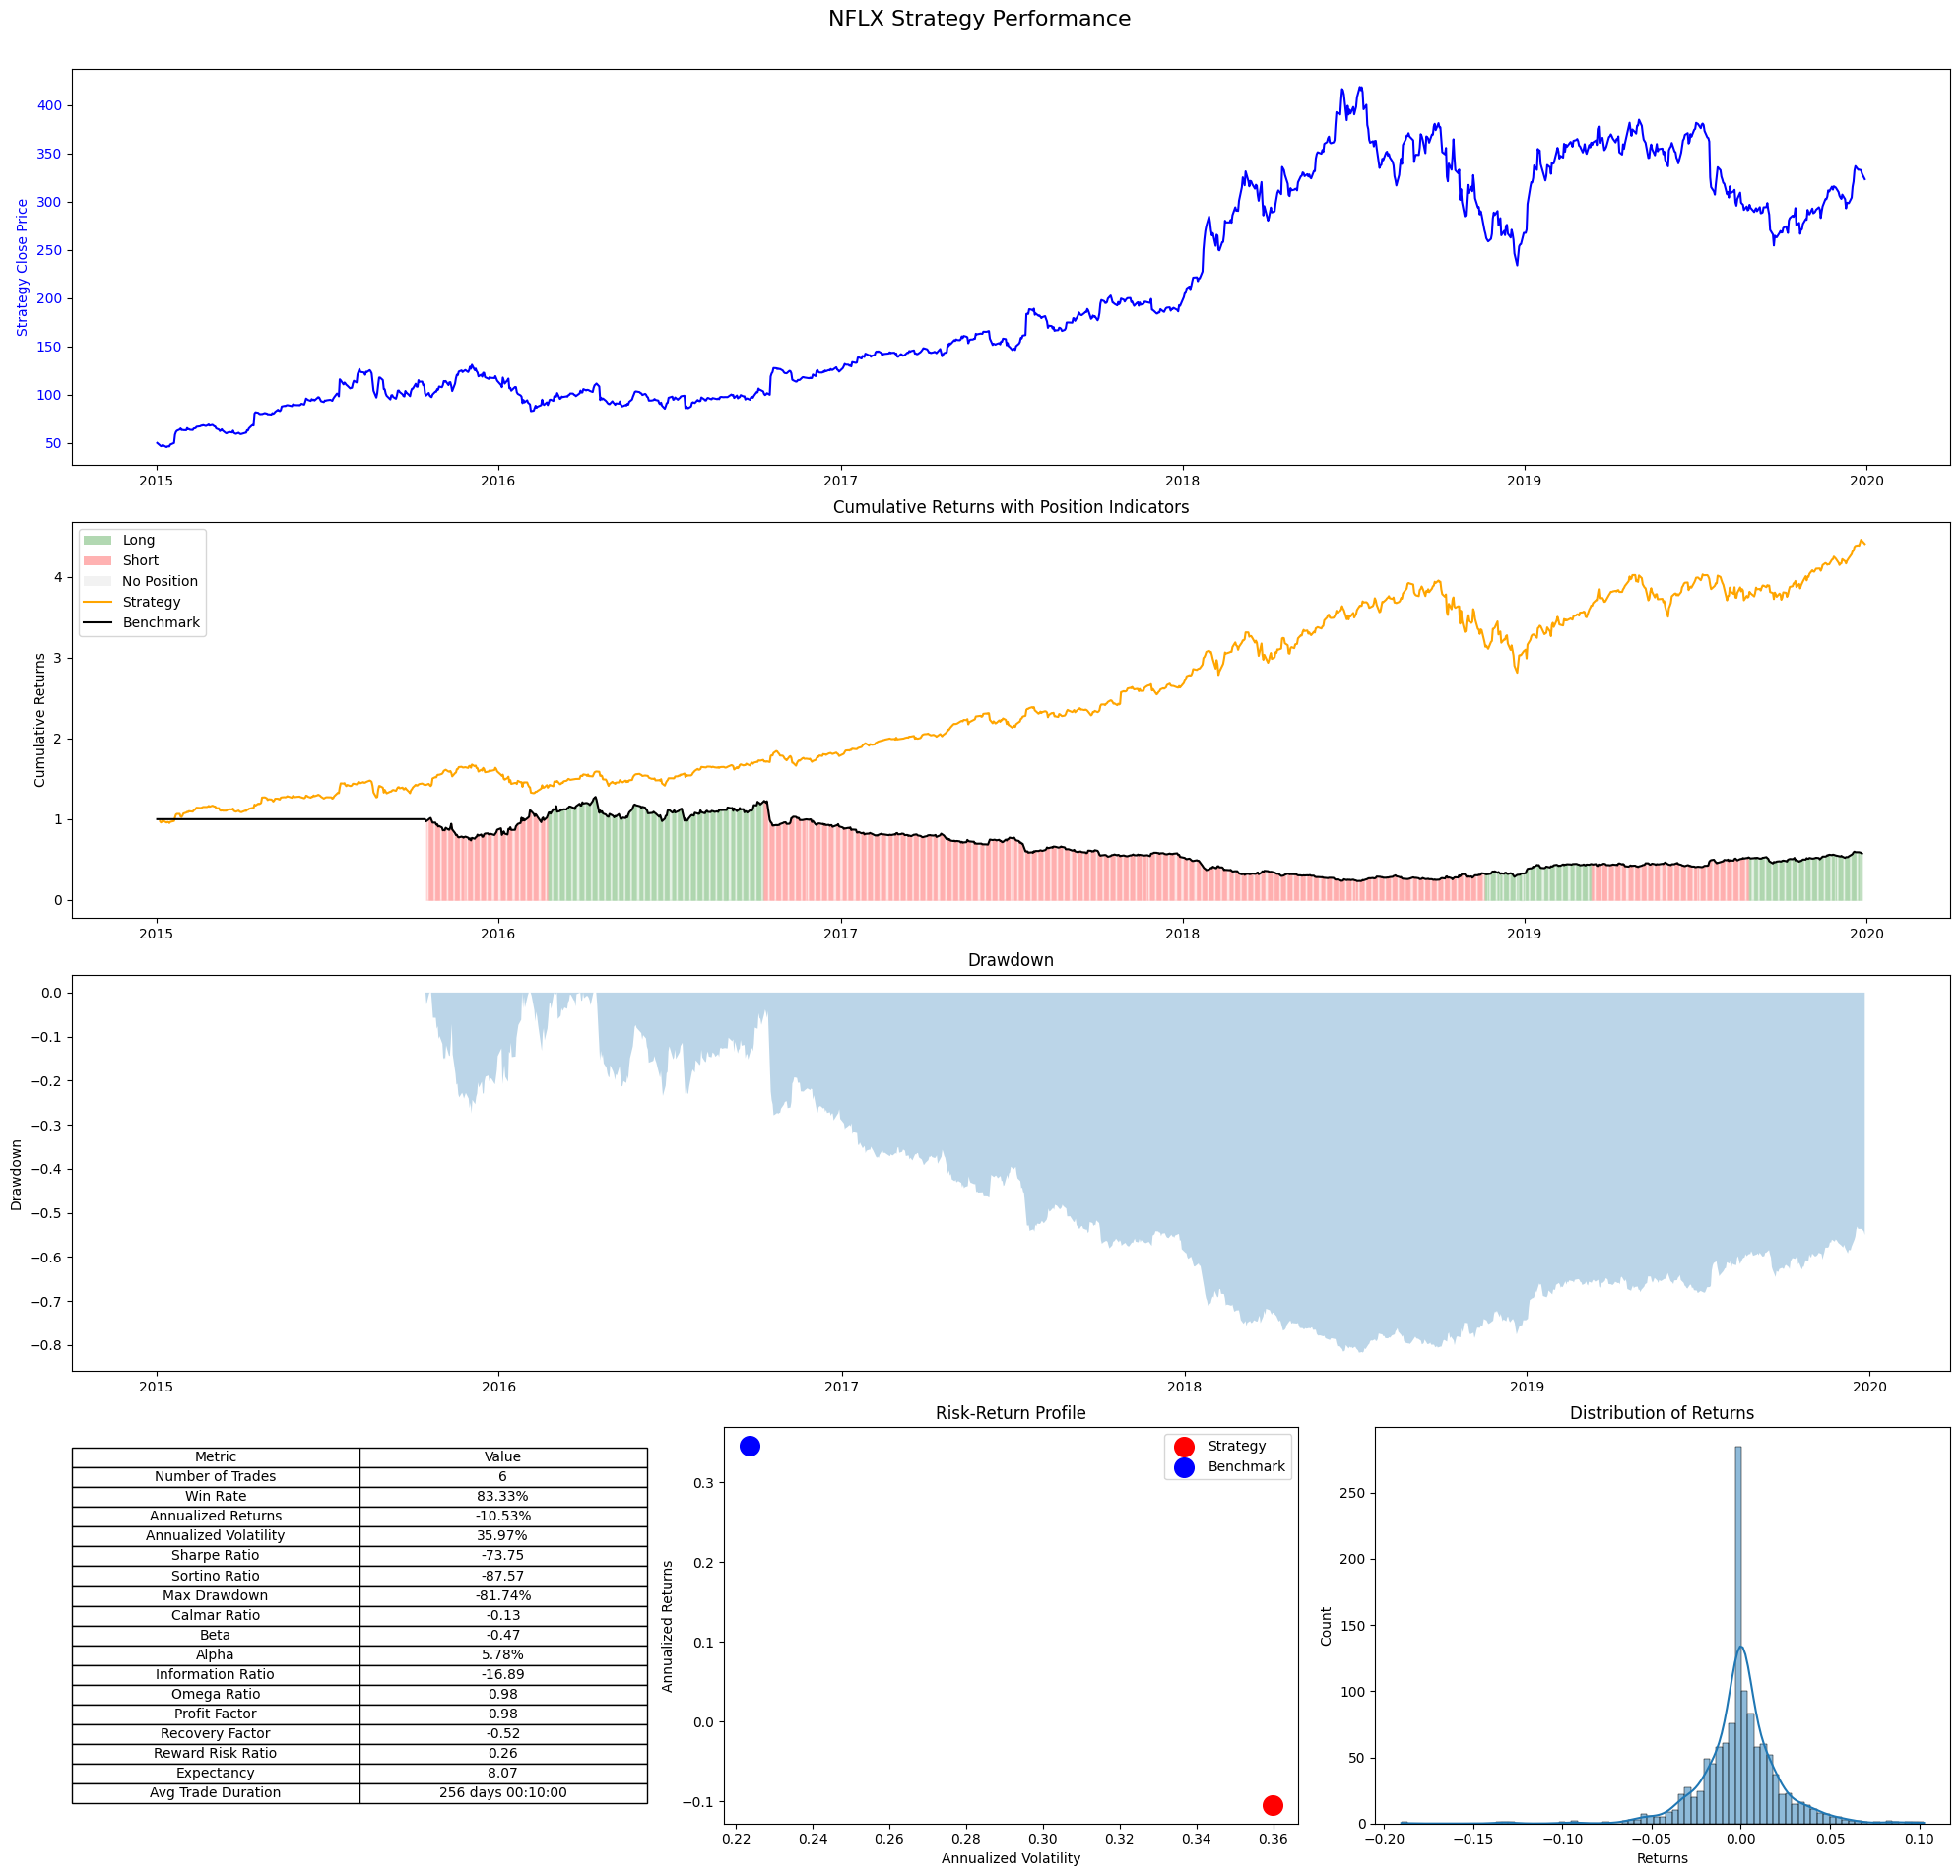

In [3]:
class YFinanceMAStrategy(YFinanceStrategy):
    def __init__(self, symbol: str, start_date: str, end_date: str, interval: str, params : dict, benchmark_symbol : str = "^GSPC", risk_free_rate : float = 0.0) -> None:
        super().__init__(symbol, start_date, end_date, interval, params, benchmark_symbol, risk_free_rate)
        # Set benchmark to Equal Weighted Portfolio of all 5 stocks.
        # Start with the first stock
        maang_stocks = ["MSFT", "AAPL", "AMZN", "NFLX", "GOOGL"]
        df_maang = prepare_data(symbol=maang_stocks[0], start_date=self.start_date, end_date=self.end_date, interval=self.interval)
        df_maang = df_maang.rename(columns={'returns_close': maang_stocks[0] + '_returns_close'})
        df_maang = df_maang[['Date', maang_stocks[0] + '_returns_close']]

        # Merge data for the remaining stocks
        for stock in maang_stocks[1:]:
            df_temp = prepare_data(symbol=stock, start_date=self.start_date, end_date=self.end_date, interval=self.interval)
            df_temp = df_temp.rename(columns={'returns_close': stock + '_returns_close'})
            df_temp = df_temp[['Date', stock + '_returns_close']]
            df_maang = pd.merge(df_maang, df_temp, on='Date', how='outer')

        # Calculate the mean returns
        df_maang['returns_close'] = df_maang[[stock + '_returns_close' for stock in maang_stocks]].mean(axis=1)
        self.data_benchmark = df_maang

    def strategy(self):
        self.data_strategy['short_sma'] = self.data_strategy['Close'].rolling(window=self.params['short_window'], min_periods=self.params['short_window']).mean()
        self.data_strategy['long_sma'] = self.data_strategy['Close'].rolling(window=self.params['long_window'], min_periods=self.params['long_window']).mean()
        
        self.data_strategy['signal'] = 0
        previous_signal = 0
        for i, row in self.data_strategy.iterrows():
            if row['short_sma'] > row['long_sma']:
                self.data_strategy.at[i, 'signal'] = -1.0
            elif row['short_sma'] < row['long_sma']:
                self.data_strategy.at[i, 'signal'] = 1.0
            elif row['short_sma'] == row['long_sma']:
                self.data_strategy.at[i, 'signal'] = 0.0
            else:
                self.data_strategy.at[i, 'signal'] = previous_signal

mastrategy_1 = YFinanceMAStrategy(
    symbol="NFLX",
    start_date = '2015-01-01',
    end_date = '2019-12-31',
    interval = '1d',
    params = {'short_window': 50, 'long_window': 200},
    benchmark_symbol='NFLX',
    risk_free_rate=0.0
)
mastrategy_1.strategy()
mastrategy_1.calculate_strategy_performance()
mastrategy_1.plot_performance()

# YFinancePortfolio - A list of YFinanceStrategy

In [23]:
from typing import List, Dict, Tuple
def calculate_information_ratio(portfolio_returns: pd.Series, benchmark_returns: pd.Series) -> float:
    """
    Calculate the Information Ratio using raw calculations.
    
    :param portfolio_returns: Series of portfolio returns
    :param benchmark_returns: Series of benchmark returns
    :return: Information Ratio
    """
    # Ensure the series are aligned and have the same length
    aligned_data = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    portfolio_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate excess returns
    excess_returns = portfolio_returns - benchmark_returns
    
    # Calculate annualized mean of excess returns
    num_periods = len(excess_returns)
    annualized_excess_return = np.mean(excess_returns) * 252  # Assuming daily returns, annualize by multiplying by 252
    
    # Calculate annualized standard deviation of excess returns
    annualized_tracking_error = np.std(excess_returns, ddof=1) * np.sqrt(252)  # Annualize by multiplying by sqrt(252)
    
    # Calculate Information Ratio
    information_ratio = annualized_excess_return / annualized_tracking_error if annualized_tracking_error != 0 else np.inf
    
    return information_ratio

def calculate_omega_ratio(returns: pd.Series, risk_free_rate: float = 0) -> float:
    excess_returns = returns - risk_free_rate
    positive_returns = np.maximum(excess_returns, 0)
    negative_returns = np.maximum(-excess_returns, 0)
    
    mean_negative_returns = np.mean(negative_returns)
    if mean_negative_returns == 0:
        return np.inf if np.mean(positive_returns) > 0 else 0
    return np.mean(positive_returns) / mean_negative_returns

def calculate_profit_factor(returns: pd.Series) -> float:
    positive_returns = returns[returns > 0].sum()
    negative_returns = -returns[returns < 0].sum()
    return positive_returns / negative_returns if negative_returns != 0 else np.inf

def calculate_recovery_factor(returns: pd.Series, max_drawdown: float) -> float:
    """
    Calculate the Recovery Factor.
    
    :param returns: Series of returns
    :param max_drawdown: Maximum drawdown
    :return: Recovery Factor
    """
    cumulative_return = (1 + returns).prod() - 1
    return cumulative_return / abs(max_drawdown) if max_drawdown != 0 else np.inf

def calculate_sortino_ratio(returns: pd.Series, risk_free_rate: float) -> float:
    """
    Calculate the Sortino Ratio.
    
    :param returns: Series of returns
    :param risk_free_rate: Risk-free rate
    :return: Sortino Ratio
    """
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    annualized_return = calculate_annualized_return(returns.to_frame(), returns.name)
    return ((annualized_return - risk_free_rate) / downside_std) * np.sqrt(252) if downside_std != 0 else np.inf

def calculate_sortino_ratio(returns: pd.Series, risk_free_rate: float) -> dict:
    """
    Calculate the Sortino Ratio with additional debugging information.
    
    :param returns: Series of returns
    :param risk_free_rate: Risk-free rate (annualized)
    :param target_return: Minimum acceptable return (default is 0)
    :return: Dictionary containing Sortino ratio and debugging information
    """
    # Convert annual risk-free rate to match the frequency of returns (assuming daily returns)
    daily_risk_free_rate = (1 + risk_free_rate) ** (1/252) - 1
    # Calculate excess returns
    excess_returns = returns - daily_risk_free_rate
    # Calculate downside returns
    downside_returns = excess_returns[excess_returns < 0]
    
    # Calculate annualized return
    total_return = (1 + excess_returns).prod() - 1
    num_periods = len(returns)
    annualized_excess_return = (1 + total_return) ** (252 / num_periods) - 1
    # Calculate downside deviation (annualized)
    downside_deviation = np.sqrt(np.mean(downside_returns**2) * 252)
    # Calculate Sortino ratio
    sortino_ratio = annualized_excess_return / downside_deviation if downside_deviation != 0 else np.inf
    
    return sortino_ratio

class YFinancePortfolio:
    def __init__(self, strategies: List[YFinanceStrategy], weights: List[float] = None) -> None:
        self.strategies = strategies
        self.weights = weights if weights is not None else self._equal_weights()
        self.portfolio_performance = None

    def _equal_weights(self) -> List[float]:
        return [1.0 / len(self.strategies)] * len(self.strategies)
    def set_weights(self, weights: List[float]) -> None:
        if len(weights) != len(self.strategies):
            raise ValueError("Number of weights must match number of strategies")
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Weights must sum to 1.0")
        self.weights = weights
    def _prepare_portfolio_and_benchmark_data(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        portfolio_data = pd.DataFrame()
        benchmark_data = pd.DataFrame()

        for strategy, weight in zip(self.strategies, self.weights):
            strategy_data = strategy.get_data()
            portfolio_data[strategy.symbol] = strategy_data['returns_strategy'] * weight
            benchmark_data[strategy.symbol] = strategy_data['returns_close'] * weight

        portfolio_data['Date'] = strategy_data['Date']
        benchmark_data['Date'] = strategy_data['Date']

        portfolio_data['portfolio_returns'] = portfolio_data.drop('Date', axis=1).sum(axis=1)
        benchmark_data['benchmark_returns'] = benchmark_data.drop('Date', axis=1).sum(axis=1)

        return portfolio_data.set_index('Date'), benchmark_data.set_index('Date')

    def calculate_portfolio_performance(self) -> Dict[str, float]:
        """
        Calculate portfolio performance metrics, comparing against its own benchmark (BnH strategy).
        """
        # Prepare portfolio and benchmark data
        self.portfolio_data, self.benchmark_data = self._prepare_portfolio_and_benchmark_data()

        # Align portfolio and benchmark data
        aligned_data = pd.concat([self.portfolio_data, self.benchmark_data], axis=1).dropna()

        # Calculate portfolio and benchmark metrics
        portfolio_returns = aligned_data['portfolio_returns']
        benchmark_returns = aligned_data['benchmark_returns']
        
        portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
        benchmark_cumulative_returns = (1 + benchmark_returns).cumprod()

        risk_free_rate = self.strategies[0].risk_free_rate

        # Calculate common metrics
        def calculate_metrics(returns, cumulative_returns, name):
            annualized_return = calculate_annualized_return(aligned_data, f'{name}_returns')
            annualized_volatility = returns.std() * np.sqrt(252)
            sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
            sortino_ratio = calculate_sortino_ratio(returns, risk_free_rate)
            max_drawdown = ((cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()).max()
            calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.inf
            
            return {
                f'{name}_annualized_return': annualized_return,
                f'{name}_annualized_volatility': annualized_volatility,
                f'{name}_sharpe_ratio': sharpe_ratio,
                f'{name}_sortino_ratio': sortino_ratio,
                f'{name}_max_drawdown': max_drawdown,
                f'{name}_calmar_ratio': calmar_ratio,
            }

        portfolio_metrics = calculate_metrics(portfolio_returns, portfolio_cumulative_returns, 'portfolio')
        benchmark_metrics = calculate_metrics(benchmark_returns, benchmark_cumulative_returns, 'benchmark')

        # Calculate portfolio-specific metrics
        beta = calculate_beta(portfolio_returns, benchmark_returns)
        alpha = calculate_alpha(beta, aligned_data, 'portfolio_returns', aligned_data, 'benchmark_returns', risk_free_rate)
        treynor_ratio = (portfolio_metrics['portfolio_annualized_return'] - risk_free_rate) / beta if beta != 0 else np.inf
        # omega_ratio = calculate_omega_ratio(aligned_data['portfolio_returns'], risk_free_rate=0)
        profit_factor = calculate_profit_factor(aligned_data['portfolio_returns'])
        recovery_factor = calculate_recovery_factor(aligned_data['portfolio_returns'], portfolio_metrics['portfolio_max_drawdown'])
        annualized_information = calculate_information_ratio(aligned_data['portfolio_returns'], aligned_data['benchmark_returns'])

        self.portfolio_performance = {
            'number_strategies': len(self.strategies),
            **portfolio_metrics,
            **benchmark_metrics,
            'beta': beta,
            'alpha': alpha,

            'portfolio_omega_ratio' : calculate_omega_ratio(aligned_data['portfolio_returns'], risk_free_rate=0),
            'benchmark_omega_ratio' : calculate_omega_ratio(aligned_data['benchmark_returns'], risk_free_rate=0),
            'portfolio_profit_factor': profit_factor,
            'benchmark_profit_factor': calculate_profit_factor(aligned_data['benchmark_returns']),
            'portfolio_recovery_factor': recovery_factor,
            'benchmark_recovery_factor': calculate_recovery_factor(aligned_data['benchmark_returns'], benchmark_metrics['benchmark_max_drawdown']),
            'treynor_ratio': treynor_ratio,
            'information_ratio': annualized_information,
        }

        return self.portfolio_performance

    def plot_portfolio_performance(self) -> None:
        # Implement portfolio performance plotting
        if self.portfolio_performance is None:
            raise ValueError("Portfolio performance must be calculated first")

        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

        # Cumulative Returns
        portfolio_cumulative_returns = (1 + self.portfolio_data['portfolio_returns']).cumprod()
        benchmark_cumulative_returns = (1 + self.benchmark_data['benchmark_returns']).cumprod()
        
        ax1.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio')
        ax1.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark')
        ax1.set_title('Cumulative Returns')
        ax1.legend()

        # Drawdown
        portfolio_drawdown = (portfolio_cumulative_returns / portfolio_cumulative_returns.cummax()) - 1
        benchmark_drawdown = (benchmark_cumulative_returns / benchmark_cumulative_returns.cummax()) - 1
        ax2.fill_between(portfolio_drawdown.index, portfolio_drawdown, 0, alpha=0.3, label='Portfolio')
        ax2.fill_between(benchmark_drawdown.index, benchmark_drawdown, 0, alpha=0.3, label='Benchmark')
        ax2.set_title('Drawdown')
        ax2.legend()

        # Performance Metrics
        metrics = [
            ('Annualized Return', f"{self.portfolio_performance['annualized_return']:.2%}"),
            ('Benchmark Return', f"{self.portfolio_performance['benchmark_return']:.2%}"),
            ('Annualized Volatility', f"{self.portfolio_performance['annualized_volatility']:.2%}"),
            ('Sharpe Ratio', f"{self.portfolio_performance['sharpe_ratio']:.2f}"),
            ('Max Drawdown', f"{self.portfolio_performance['max_drawdown']:.2%}"),
            ('Calmar Ratio', f"{self.portfolio_performance['calmar_ratio']:.2f}"),
            ('Beta', f"{self.portfolio_performance['beta']:.2f}"),
            ('Alpha', f"{self.portfolio_performance['alpha']:.2%}")
        ]

        ax3.axis('tight')
        ax3.axis('off')
        ax3.table(cellText=metrics, colLabels=['Metric', 'Value'], cellLoc='center', loc='center')

        plt.tight_layout()
        plt.show()
    def plot_overall_portfolio_performance(self) -> None:
        if self.portfolio_performance is None:
            raise ValueError("Portfolio performance must be calculated first")

        # Ensure we have the necessary data
        if not hasattr(self, 'portfolio_data') or not hasattr(self, 'benchmark_data'):
            self._prepare_portfolio_and_benchmark_data()

        # Calculate cumulative returns
        portfolio_cumulative_returns = (1 + self.portfolio_data['portfolio_returns']).cumprod()
        benchmark_cumulative_returns = (1 + self.benchmark_data['benchmark_returns']).cumprod()

        # Create the plot
        plt.figure(figsize=(12, 6))
        plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio')
        plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label='Benchmark')

        plt.title('Portfolio Performance vs Benchmark')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Returns')
        plt.legend()

        # Add annotations for final values
        last_date = portfolio_cumulative_returns.index[-1]
        plt.annotate(f'Portfolio: {portfolio_cumulative_returns.iloc[-1]:.2f}',
                     xy=(last_date, portfolio_cumulative_returns.iloc[-1]),
                     xytext=(10, 10), textcoords='offset points')
        plt.annotate(f'Benchmark: {benchmark_cumulative_returns.iloc[-1]:.2f}',
                     xy=(last_date, benchmark_cumulative_returns.iloc[-1]),
                     xytext=(10, -10), textcoords='offset points')

        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()
    def get_portfolio_performance(self) -> Dict[str, float]:
        return self.portfolio_performance

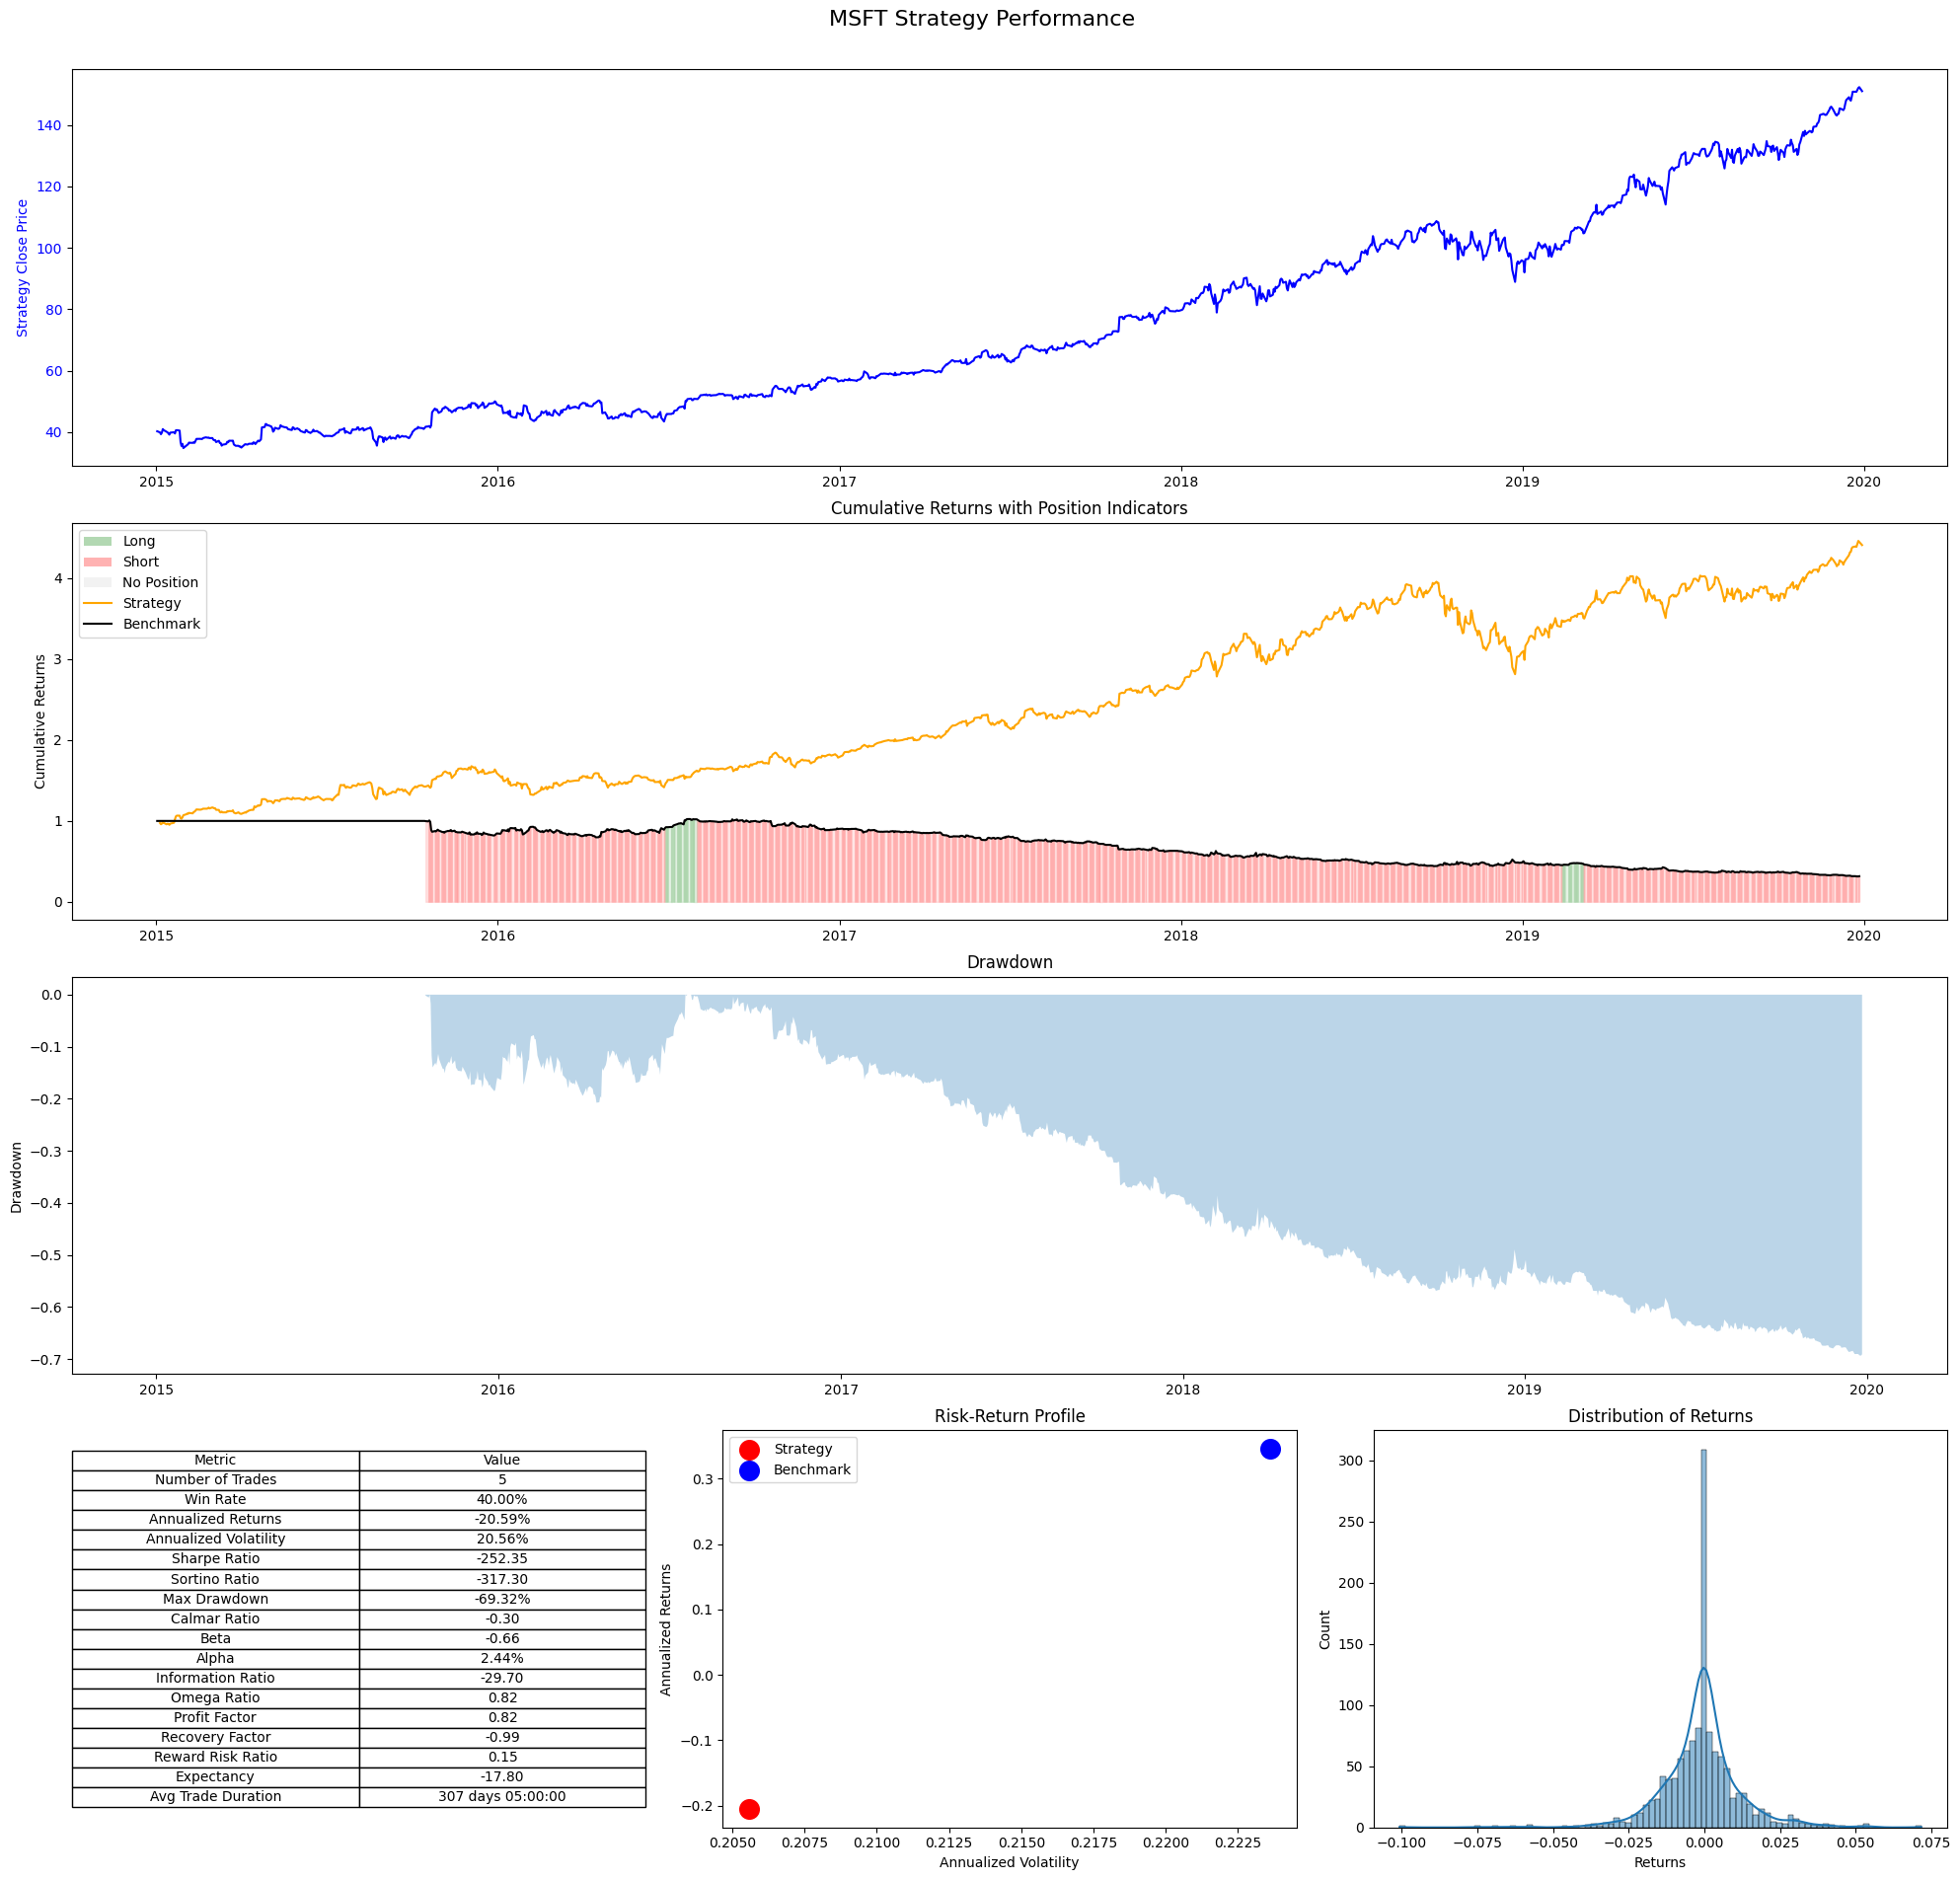

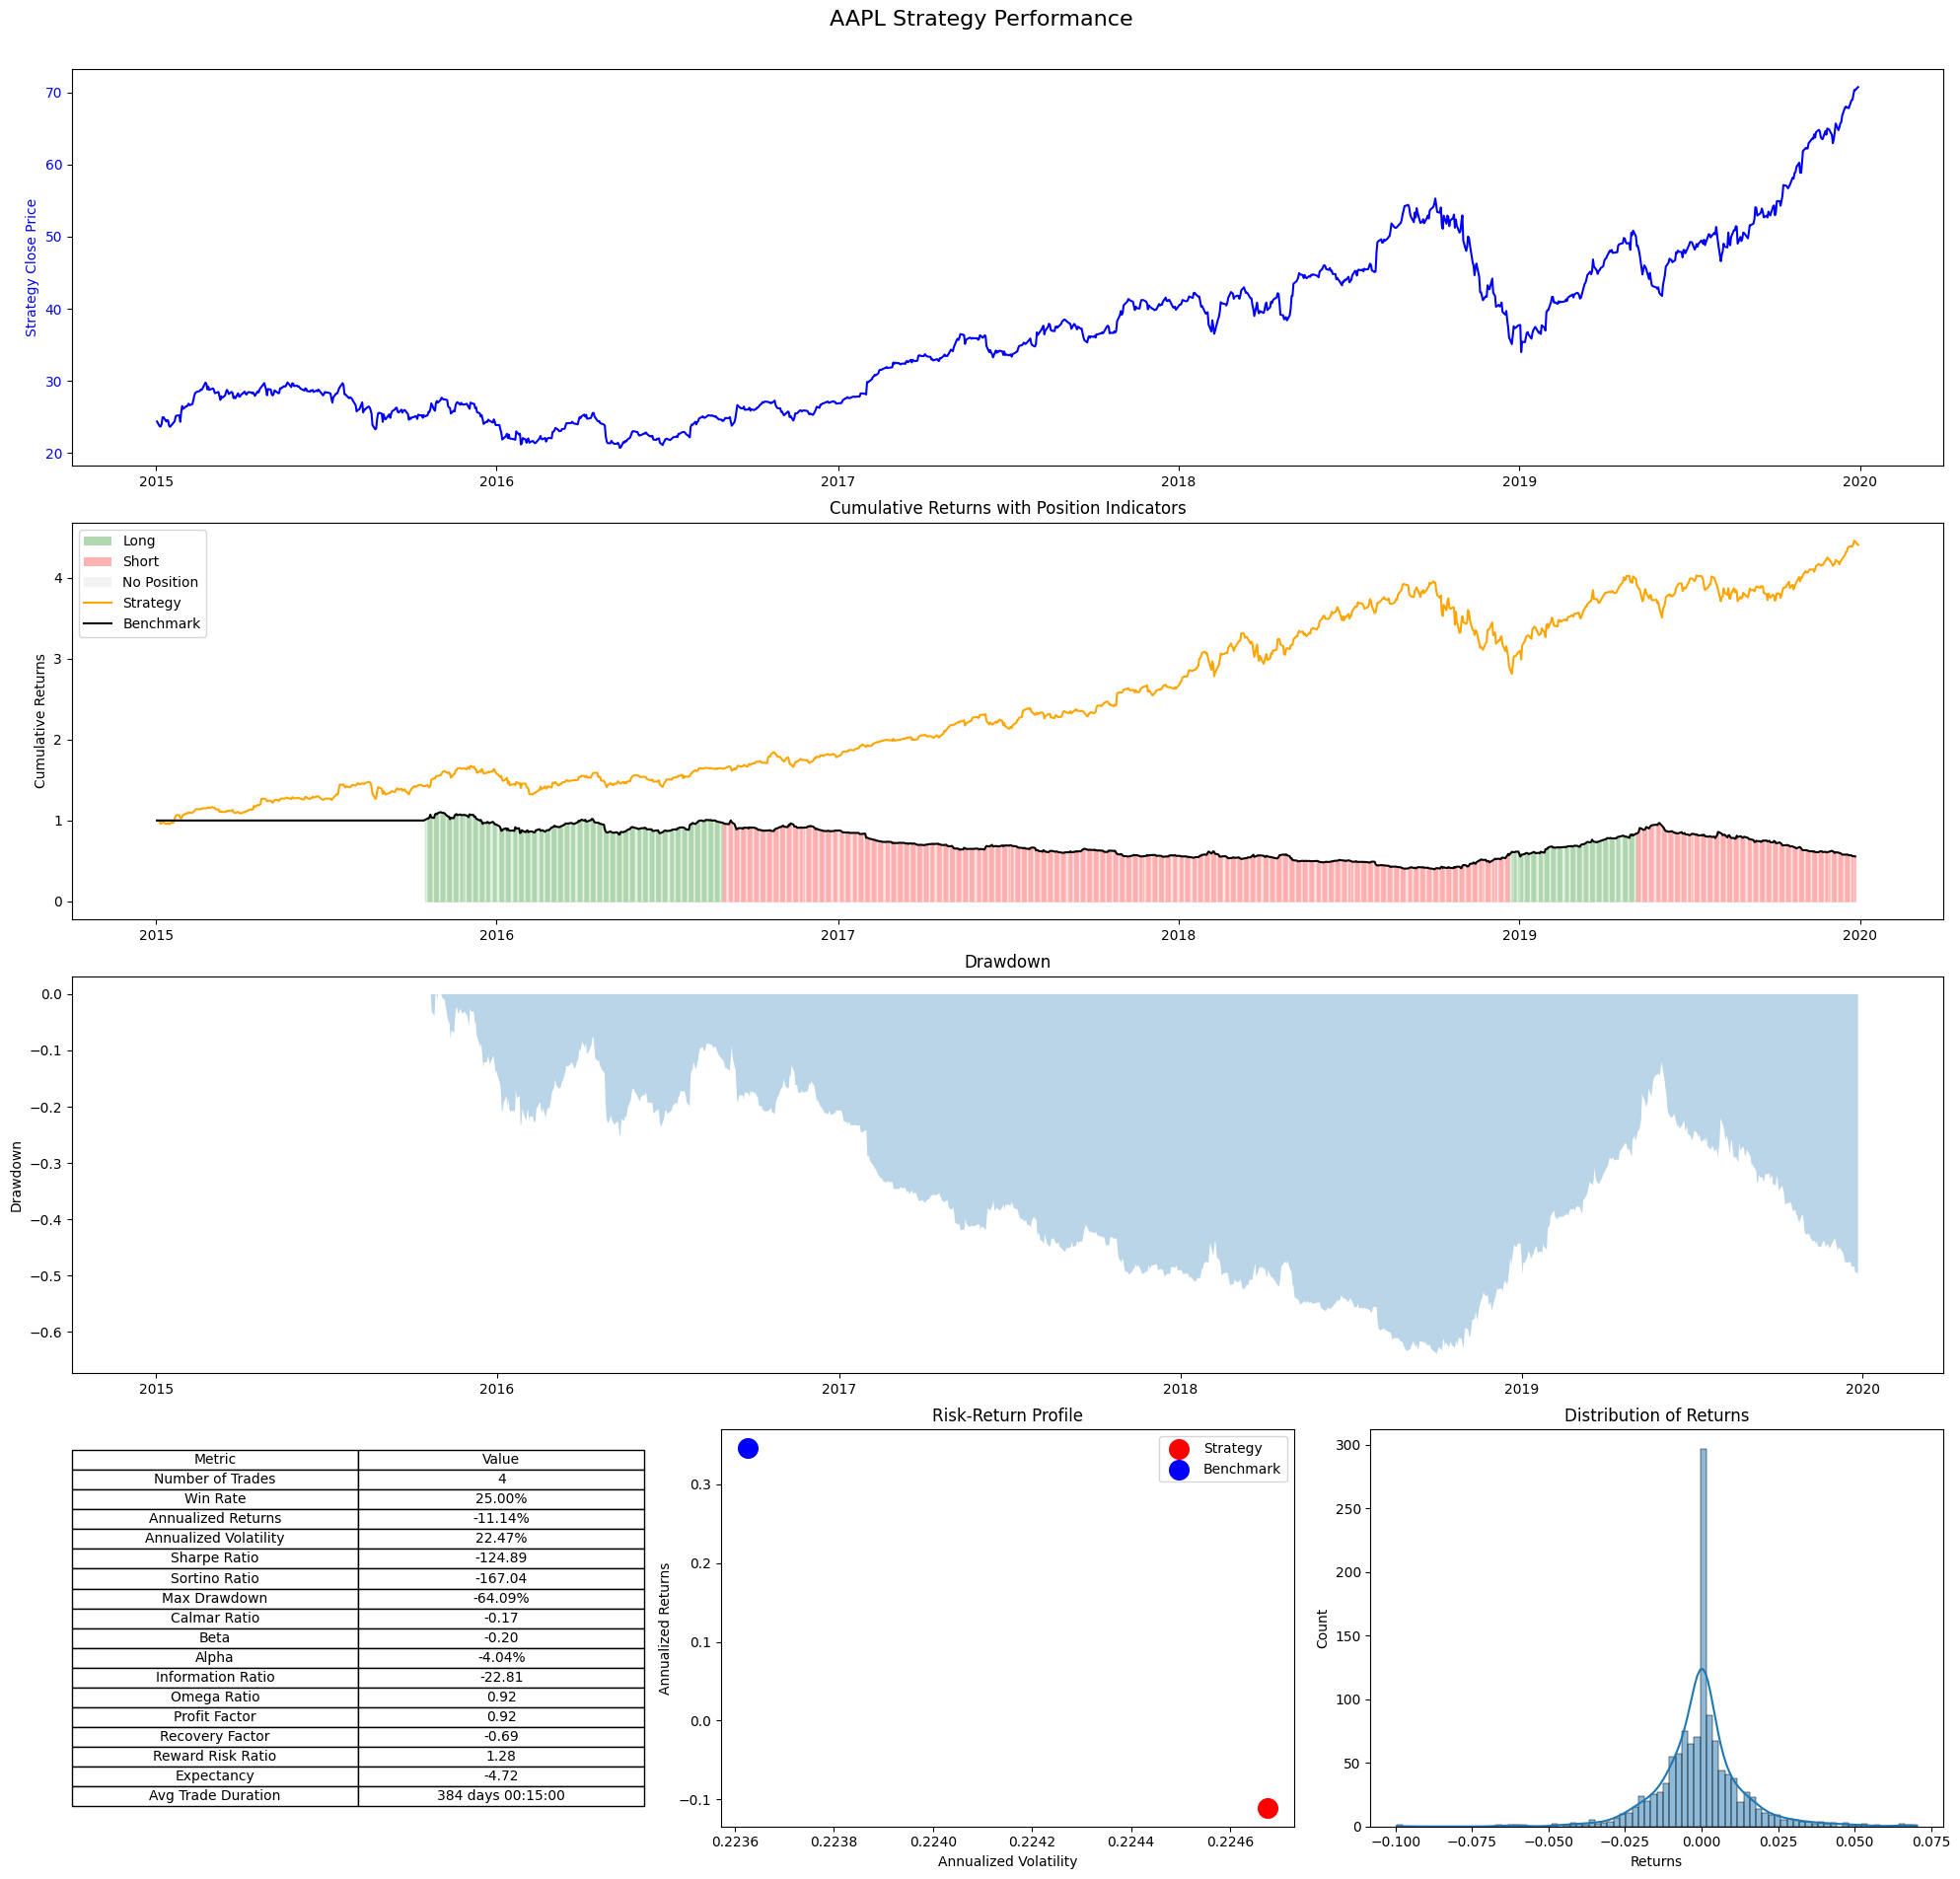

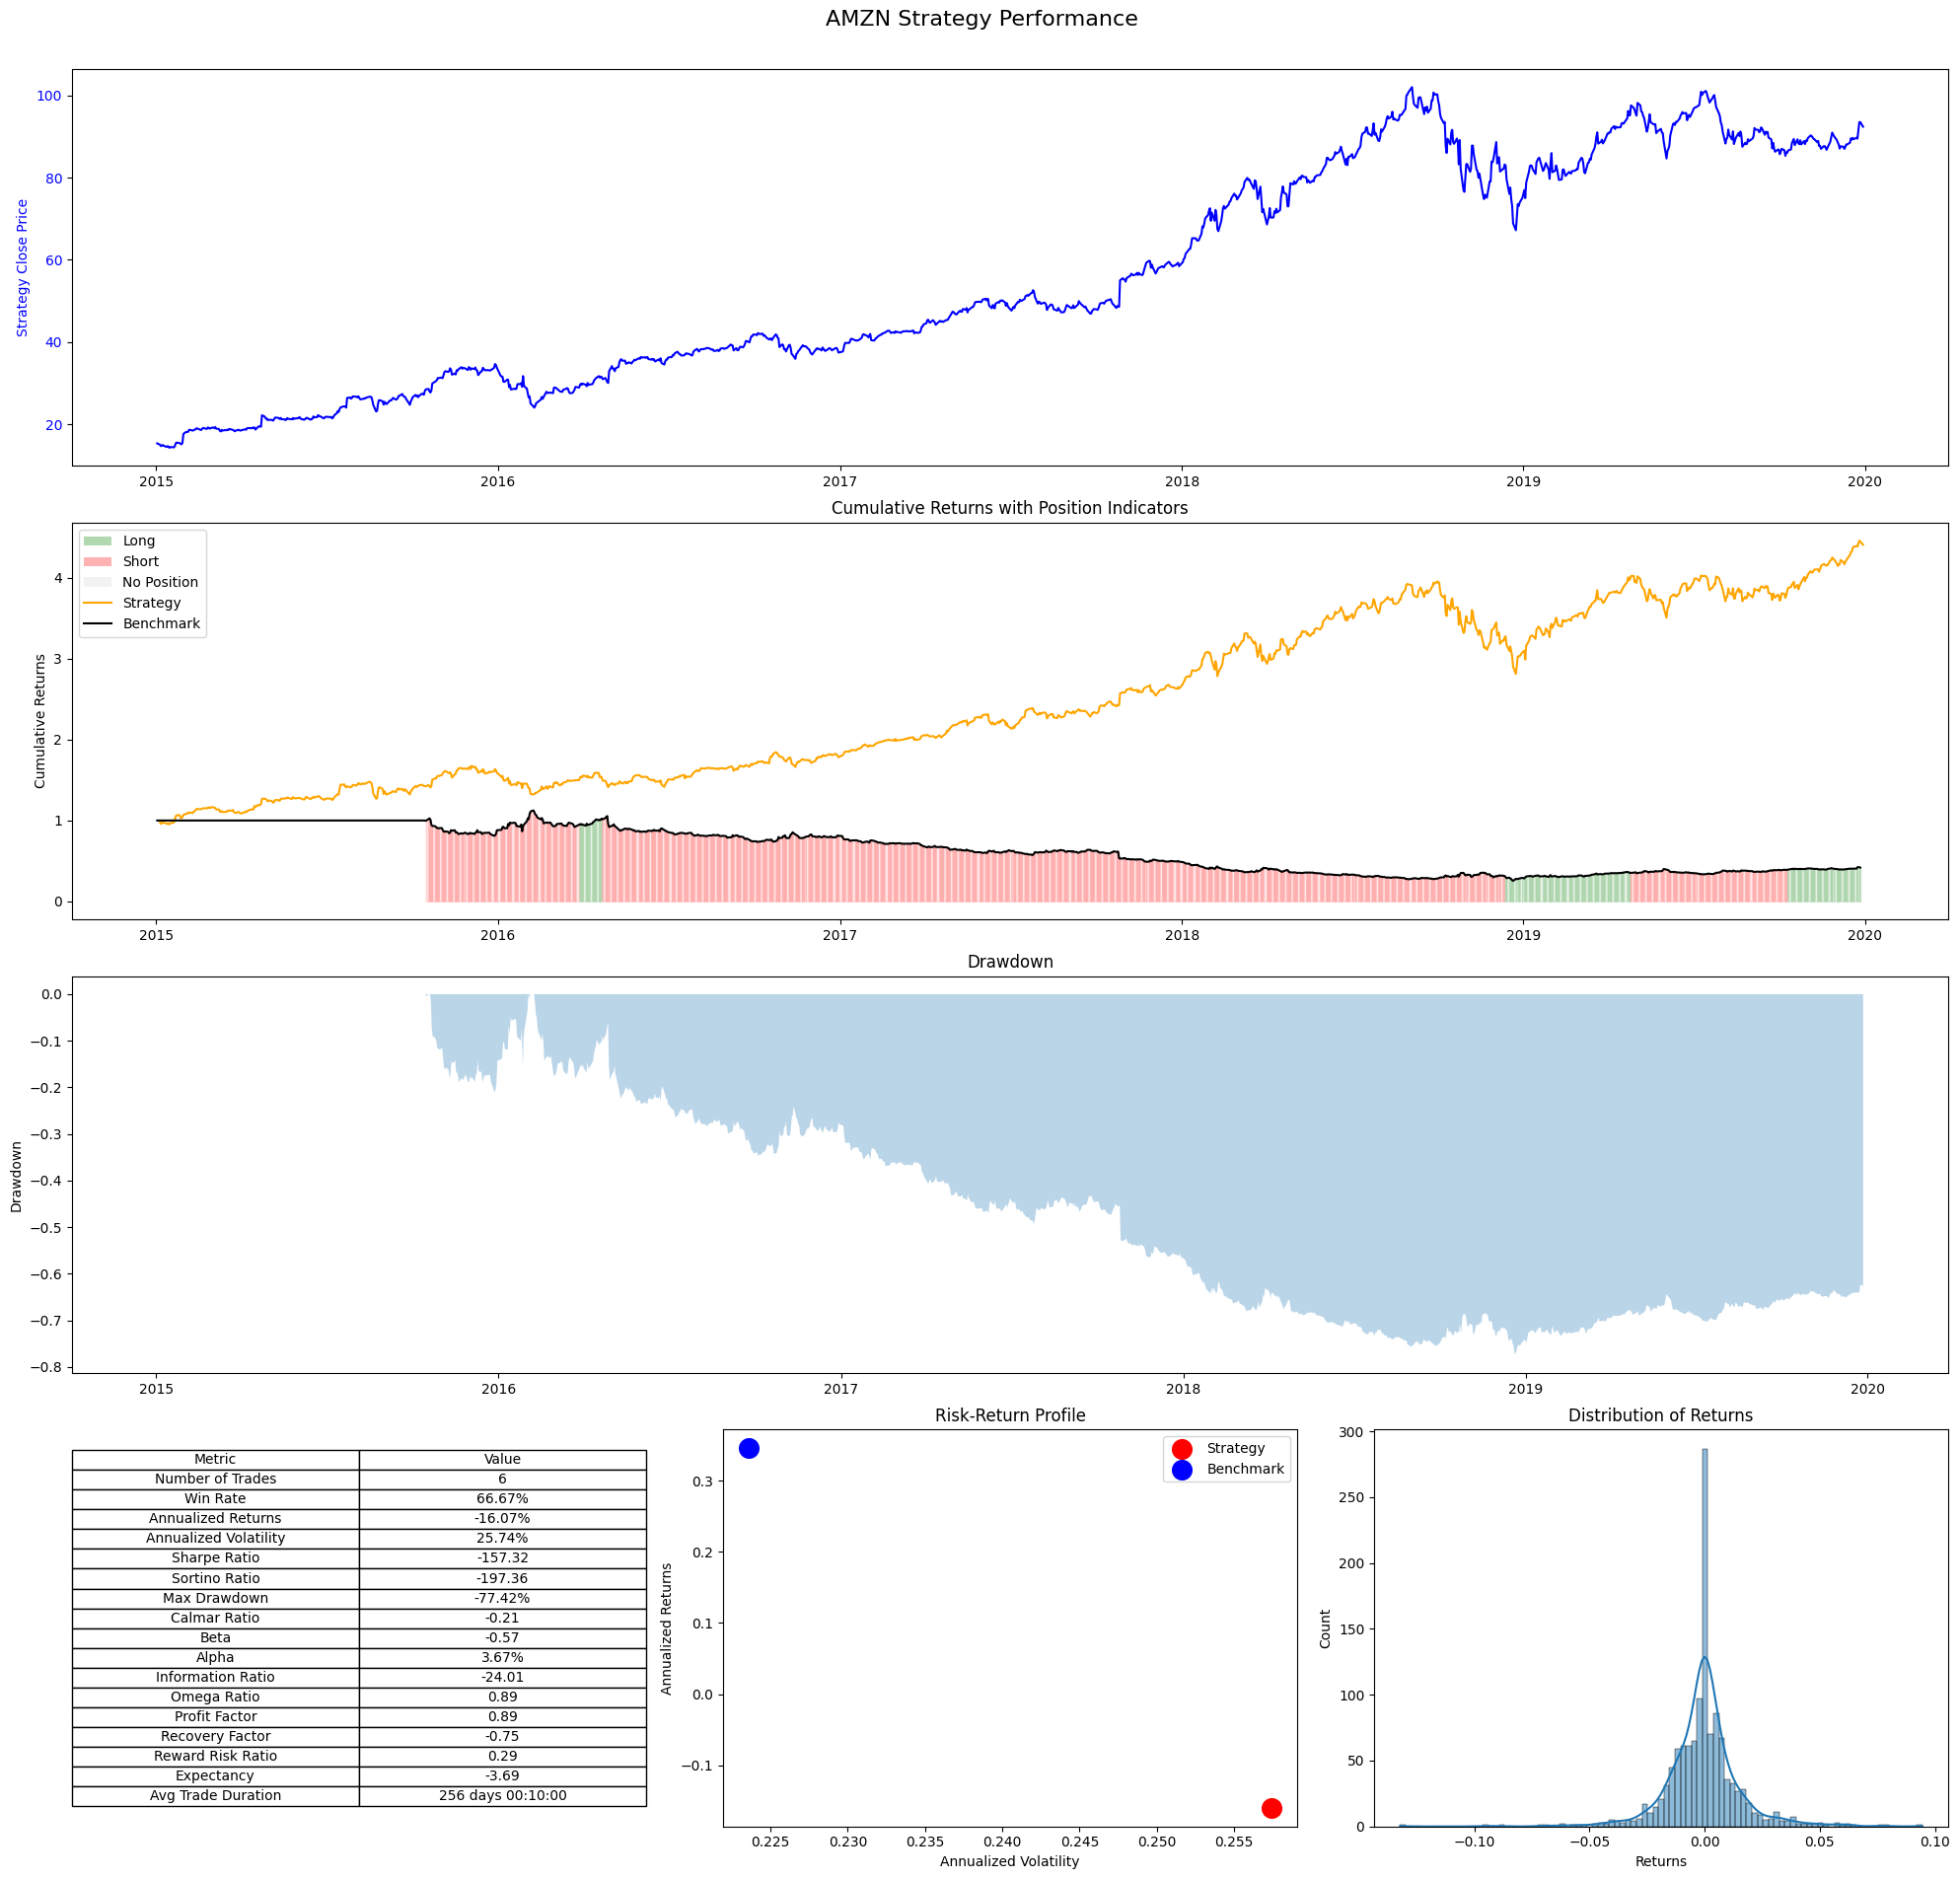

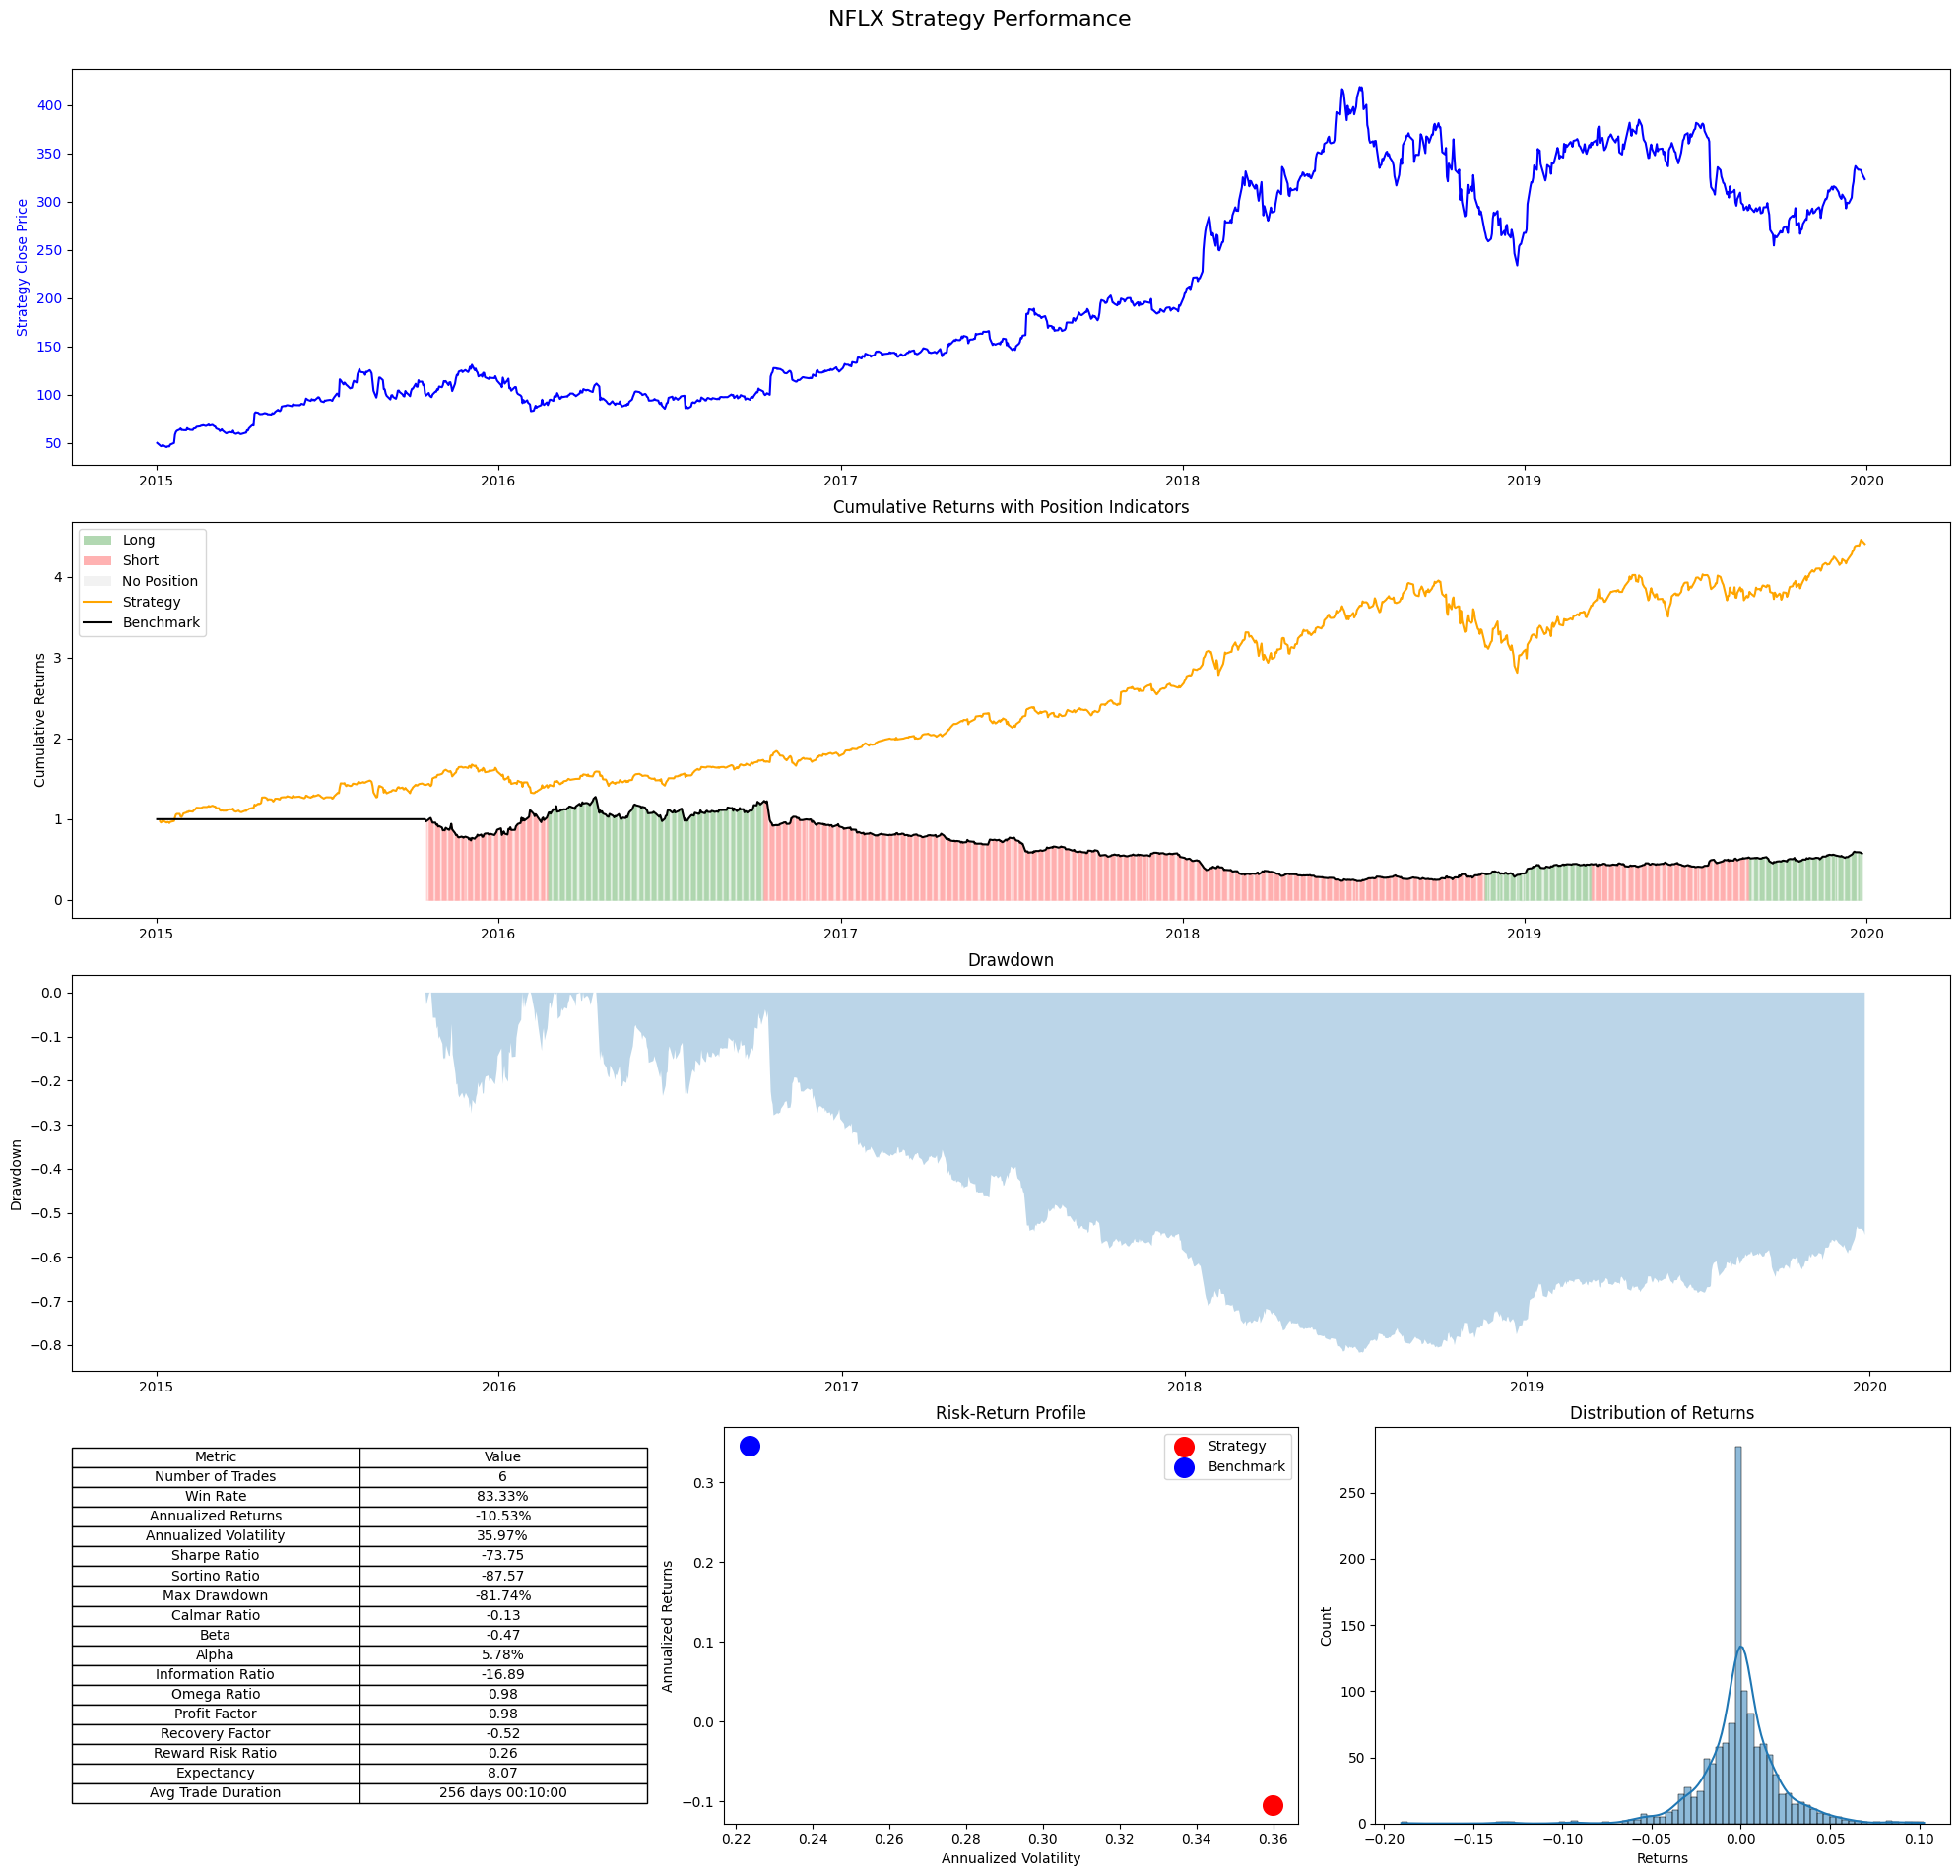

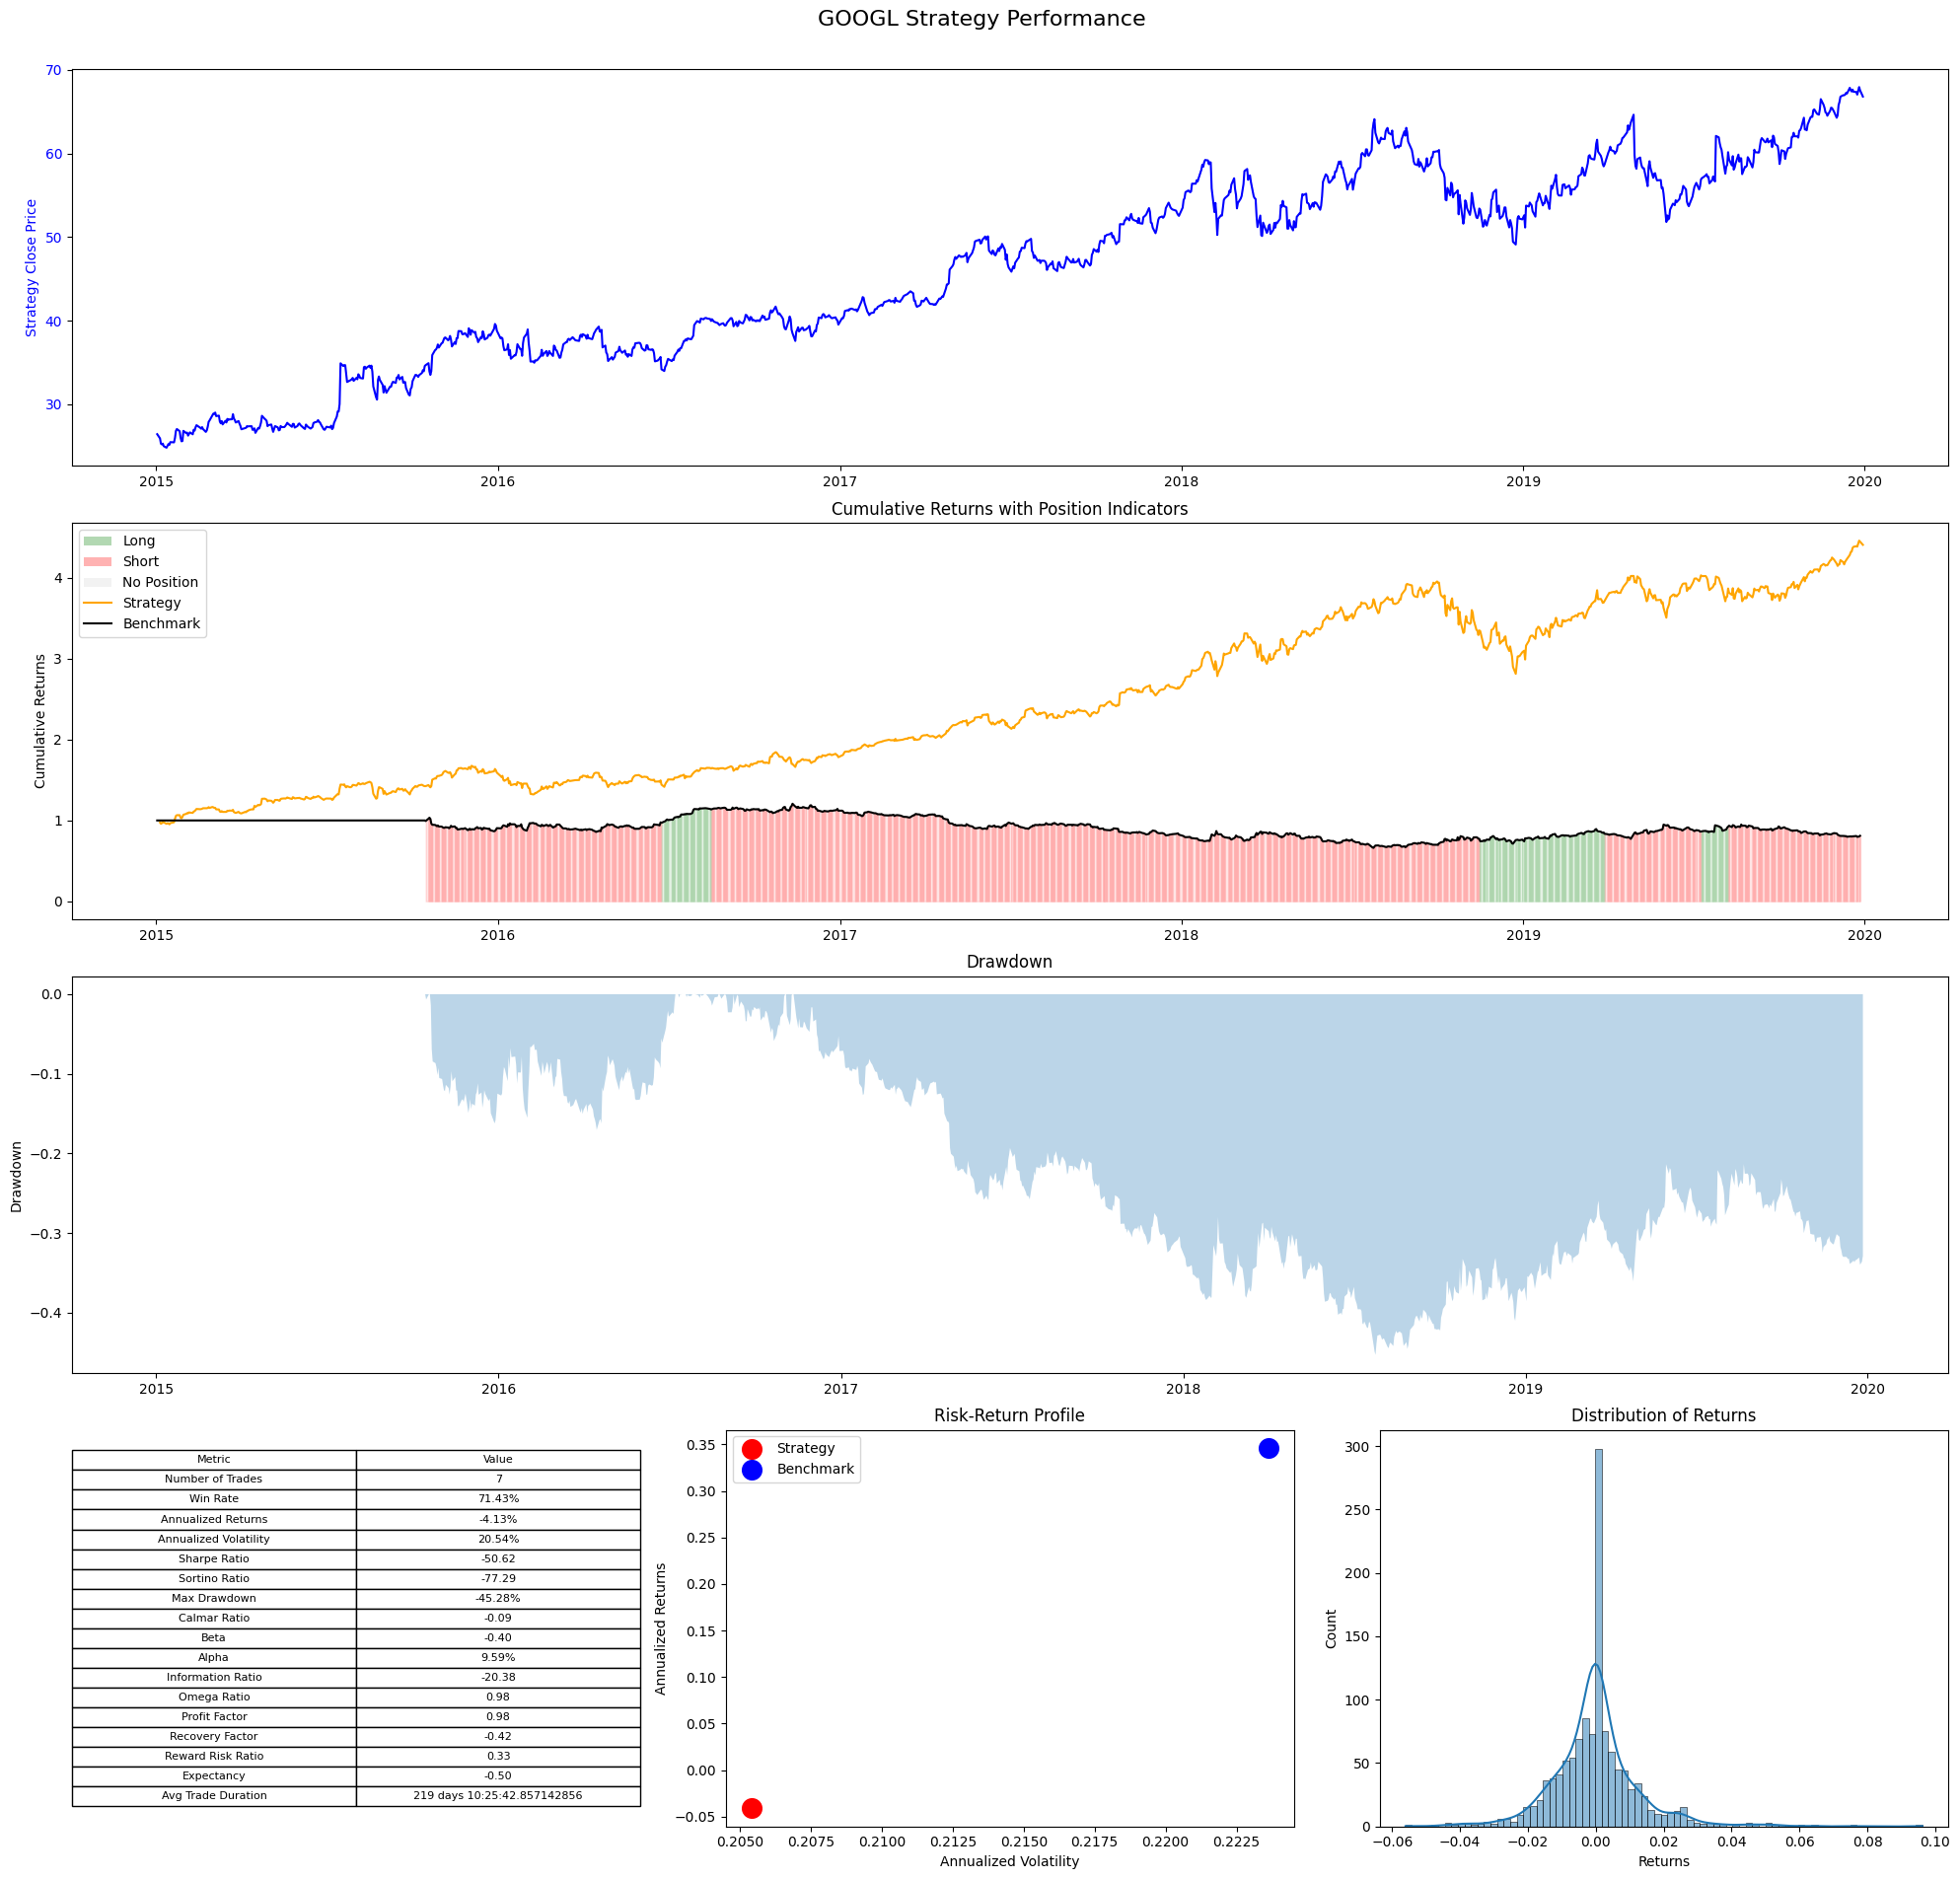

{'number_strategies': 5,
 'portfolio_annualized_return': -0.1106088704253968,
 'portfolio_annualized_volatility': 0.17262782218921738,
 'portfolio_sharpe_ratio': -0.6407360587805968,
 'portfolio_sortino_ratio': -0.6179010312965766,
 'portfolio_max_drawdown': 0.6085646591094092,
 'portfolio_calmar_ratio': -0.18175368676068862,
 'benchmark_annualized_return': 0.3494678033057319,
 'benchmark_annualized_volatility': 0.22366917856298818,
 'benchmark_sharpe_ratio': 1.562431648164332,
 'benchmark_sortino_ratio': 1.514278044806894,
 'benchmark_max_drawdown': 0.2889565247930169,
 'benchmark_calmar_ratio': 1.209413089239151,
 'beta': 0.016949482007257887,
 'alpha': -0.11653216866964324,
 'annualized_treynor': -6.525796503871523,
 'annualized_information': -1.5283038245651681,
 'omega_ratio': 0.8891725340459312,
 'profit_factor': 0.8891725340459312,
 'recovery_factor': -0.7266372518384979}

In [5]:
list_strategies = []

for s in maang_stocks:
    strategy = YFinanceMAStrategy(
        symbol=s,
        start_date = '2015-01-01',
        end_date = '2019-12-31',
        interval = '1d',
        params = {'short_window': 50, 'long_window': 200},
        benchmark_symbol=s,
        risk_free_rate=0.0
    )
    strategy.strategy()
    strategy.calculate_strategy_performance()
    strategy.plot_performance()
    list_strategies.append(strategy)

portfolio = YFinancePortfolio(list_strategies)
portfolio.calculate_portfolio_performance()

## Data Extraction

In [6]:
# I want to trade the RSI strategy on the industry market cap weighted RSI.
top_25_tech_stocks = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL",  # Alphabet (Google)
    "AMZN",  # Amazon
    "NVDA",  # NVIDIA
    "META",  # Meta Platforms
    "TSLA",  # Tesla
    "TSM",   # Taiwan Semiconductor Manufacturing Company
    "AVGO",  # Broadcom
    "ORCL",  # Oracle
    "CSCO",  # Cisco Systems
    "ADBE",  # Adobe
    "CRM",   # Salesforce
    "ASML",  # ASML Holding
    "AMD",   # Advanced Micro Devices
    "ACN",   # Accenture
    "INTC",  # Intel
    "QCOM",  # Qualcomm
    "IBM",   # IBM
    "TXN",   # Texas Instruments
    # "PYPL",  # PayPal - Has missing values before 2015
    "INTU",  # Intuit
    "AMAT",  # Applied Materials
    "NOW",   # ServiceNow
    "ADP"    # Automatic Data Processing
]

start_date = '2015-01-01'
end_date = '2019-12-31'
interval = '1d'

all_data = None

for s in top_25_tech_stocks:
    try:
        data = prepare_data(s, start_date, end_date, interval)
        if all_data is None:
            all_data = data[['timestamp_utc', 'Close', 'MC']].rename(columns={'Close': s + '_Close', 'MC': s + '_MC'})
        else:
            all_data = all_data.merge(data[['timestamp_utc', 'Close', 'MC']].rename(columns={'Close': s + '_Close', 'MC': s + '_MC'}), on='timestamp_utc', how='left')
    except Exception as e:
        print(f"Error processing {s}: {e}")
all_data['datetime'] = pd.to_datetime(all_data['timestamp_utc'], unit='ms', utc=True)
all_data

timestamp_utc  AAPL_Close        AAPL_MC  MSFT_Close        MSFT_MC  \
0     1420174800000   24.373957  3370596958208   40.232853  3044127277056   
1     1420434000000   23.687305  3370596958208   39.862885  3044127277056   
2     1420520400000   23.689533  3370596958208   39.277790  3044127277056   
3     1420606800000   24.021711  3370596958208   39.776833  3044127277056   
4     1420693200000   24.944683  3370596958208   40.946991  3044127277056   
...             ...         ...            ...         ...            ...   
1252  1577077200000   68.909004  3370596958208  150.861740  3044127277056   
1253  1577163600000   68.974510  3370596958208  150.833023  3044127277056   
1254  1577336400000   70.342972  3370596958208  152.069321  3044127277056   
1255  1577422800000   70.316284  3370596958208  152.347260  3044127277056   
1256  1577682000000   70.733620  3370596958208  151.034286  3044127277056   

      GOOGL_Close       GOOGL_MC  AMZN_Close        AMZN_MC  NVDA_Close  ...  \
0       26.412100  2037152088064   15.426000  1897604448256    0.483177  ...   
1       25.908844  2037152088064   15.109500  1897604448256    0.475016  ...   
2       25.269430  2037152088064   14.764500  1897604448256    0.460614  ...   
3       25.195112  2037152088064   14.921000  1897604448256    0.459414  ...   
4       25.282898  2037152088064   15.023000  1897604448256    0.476696  ...   
...           ...            ...         ...            ...         ...  ...   
1252    67.364700  2037152088064   89.650002  1897604448256    5.945984  ...   
1253    67.055450  2037152088064   89.460503  1897604448256    5.941005  ...   
1254    67.955231  2037152088064   93.438499  1897604448256    5.955197  ...   
1255    67.564705  2037152088064   93.489998  1897604448256    5.897434  ...   
1256    66.820038  2037152088064   92.344498  1897604448256    5.784152  ...   

            TXN_MC  INTU_Close       INTU_MC  AMAT_Close       AMAT_MC  \
0     183768776704   84.083908  168856305664   22.034138  164987977728   
1     183768776704   83.752029  168856305664   21.327911  164987977728   
2     183768776704   81.180008  168856305664   20.524586  164987977728   
3     183768776704   81.975067  168856305664   20.718800  164987977728   
4     183768776704   83.075218  168856305664   21.380877  164987977728   
...            ...         ...           ...         ...           ...   
1252  183768776704  258.233826  168856305664   58.429195  164987977728   
1253  183768776704  256.342896  168856305664   58.830963  164987977728   
1254  183768776704  258.806061  168856305664   58.649227  164987977728   
1255  183768776704  258.990356  168856305664   58.515289  164987977728   
1256  183768776704  254.897842  168856305664   58.285706  164987977728   

       NOW_Close        NOW_MC   ADP_Close        ADP_MC  \
0      67.379997  186494091264   67.362999  115055861760   
1      67.150002  186494091264   67.314461  115055861760   
2      66.330002  186494091264   66.756409  115055861760   
3      67.089996  186494091264   67.338730  115055861760   
4      68.889999  186494091264   68.883492  115055861760   
...          ...           ...         ...           ...   
1252  283.309998  186494091264  153.728485  115055861760   
1253  284.200012  186494091264  153.628998  115055861760   
1254  286.200012  186494091264  154.026871  115055861760   
1255  286.880005  186494091264  154.406601  115055861760   
1256  282.809998  186494091264  153.339691  115055861760   

                      datetime  
0    2015-01-02 05:00:00+00:00  
1    2015-01-05 05:00:00+00:00  
2    2015-01-06 05:00:00+00:00  
3    2015-01-07 05:00:00+00:00  
4    2015-01-08 05:00:00+00:00  
...                        ...  
1252 2019-12-23 05:00:00+00:00  
1253 2019-12-24 05:00:00+00:00  
1254 2019-12-26 05:00:00+00:00  
1255 2019-12-27 05:00:00+00:00  
1256 2019-12-30 05:00:00+00:00  

[1257 rows x 50 columns]

In [7]:
from ta.momentum import RSIIndicator

all_data_rsi = all_data.copy()

rsi_params = {
    'window': 14,
    'fillna': False
}

for s in top_25_tech_stocks:
    all_data_rsi[f'{s}_rsi'] = RSIIndicator(close = all_data_rsi[s + '_Close'],
        window=rsi_params['window'],
        fillna=rsi_params['fillna']).rsi()
all_data_rsi

timestamp_utc  AAPL_Close        AAPL_MC  MSFT_Close        MSFT_MC  \
0     1420174800000   24.373957  3370596958208   40.232853  3044127277056   
1     1420434000000   23.687305  3370596958208   39.862885  3044127277056   
2     1420520400000   23.689533  3370596958208   39.277790  3044127277056   
3     1420606800000   24.021711  3370596958208   39.776833  3044127277056   
4     1420693200000   24.944683  3370596958208   40.946991  3044127277056   
...             ...         ...            ...         ...            ...   
1252  1577077200000   68.909004  3370596958208  150.861740  3044127277056   
1253  1577163600000   68.974510  3370596958208  150.833023  3044127277056   
1254  1577336400000   70.342972  3370596958208  152.069321  3044127277056   
1255  1577422800000   70.316284  3370596958208  152.347260  3044127277056   
1256  1577682000000   70.733620  3370596958208  151.034286  3044127277056   

      GOOGL_Close       GOOGL_MC  AMZN_Close        AMZN_MC  NVDA_Close  ...  \
0       26.412100  2037152088064   15.426000  1897604448256    0.483177  ...   
1       25.908844  2037152088064   15.109500  1897604448256    0.475016  ...   
2       25.269430  2037152088064   14.764500  1897604448256    0.460614  ...   
3       25.195112  2037152088064   14.921000  1897604448256    0.459414  ...   
4       25.282898  2037152088064   15.023000  1897604448256    0.476696  ...   
...           ...            ...         ...            ...         ...  ...   
1252    67.364700  2037152088064   89.650002  1897604448256    5.945984  ...   
1253    67.055450  2037152088064   89.460503  1897604448256    5.941005  ...   
1254    67.955231  2037152088064   93.438499  1897604448256    5.955197  ...   
1255    67.564705  2037152088064   93.489998  1897604448256    5.897434  ...   
1256    66.820038  2037152088064   92.344498  1897604448256    5.784152  ...   

        AMD_rsi    ACN_rsi   INTC_rsi   QCOM_rsi    IBM_rsi    TXN_rsi  \
0           NaN        NaN        NaN        NaN        NaN        NaN   
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
1252  75.208046  74.669435  66.584186  59.506892  56.467568  68.192290   
1253  77.577763  75.692194  67.601149  60.482749  52.885700  68.094152   
1254  77.768467  76.274152  69.851865  58.720585  52.445725  67.831447   
1255  74.362890  76.508169  71.217330  60.074851  54.540405  68.070303   
1256  69.552138  69.633676  65.559610  58.173669  41.189240  62.979641   

       INTU_rsi   AMAT_rsi    NOW_rsi    ADP_rsi  
0           NaN        NaN        NaN        NaN  
1           NaN        NaN        NaN        NaN  
2           NaN        NaN        NaN        NaN  
3           NaN        NaN        NaN        NaN  
4           NaN        NaN        NaN        NaN  
...         ...        ...        ...        ...  
1252  58.307515  62.191105  62.543503  58.158677  
1253  55.142547  63.607982  63.289150  57.708611  
1254  58.316576  62.467618  64.976418  59.072679  
1255  58.552883  61.591226  65.556063  60.385933  
1256  51.562412  60.036406  59.236777  55.041933  

[1257 rows x 74 columns]

In [8]:
def plot_symbol_and_rsi(df, symbol):
    """
    Plot the symbol's price on one axis and its RSI on another axis.
    
    :param df: DataFrame containing the data
    :param symbol: String, the symbol to plot (e.g., 'AMAT')
    """
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plot symbol price
    ax1.plot(df['datetime'], df[symbol + '_Close'], color='blue', label=f'{symbol} Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{symbol} Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create second y-axis for RSI
    ax2 = ax1.twinx()
    ax2.plot(df['datetime'], df[f'{symbol}_rsi'], color='red', label=f'{symbol} RSI')
    ax2.set_ylabel('RSI', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'{symbol} Price and RSI Over Time')
    fig.tight_layout()
    plt.show()

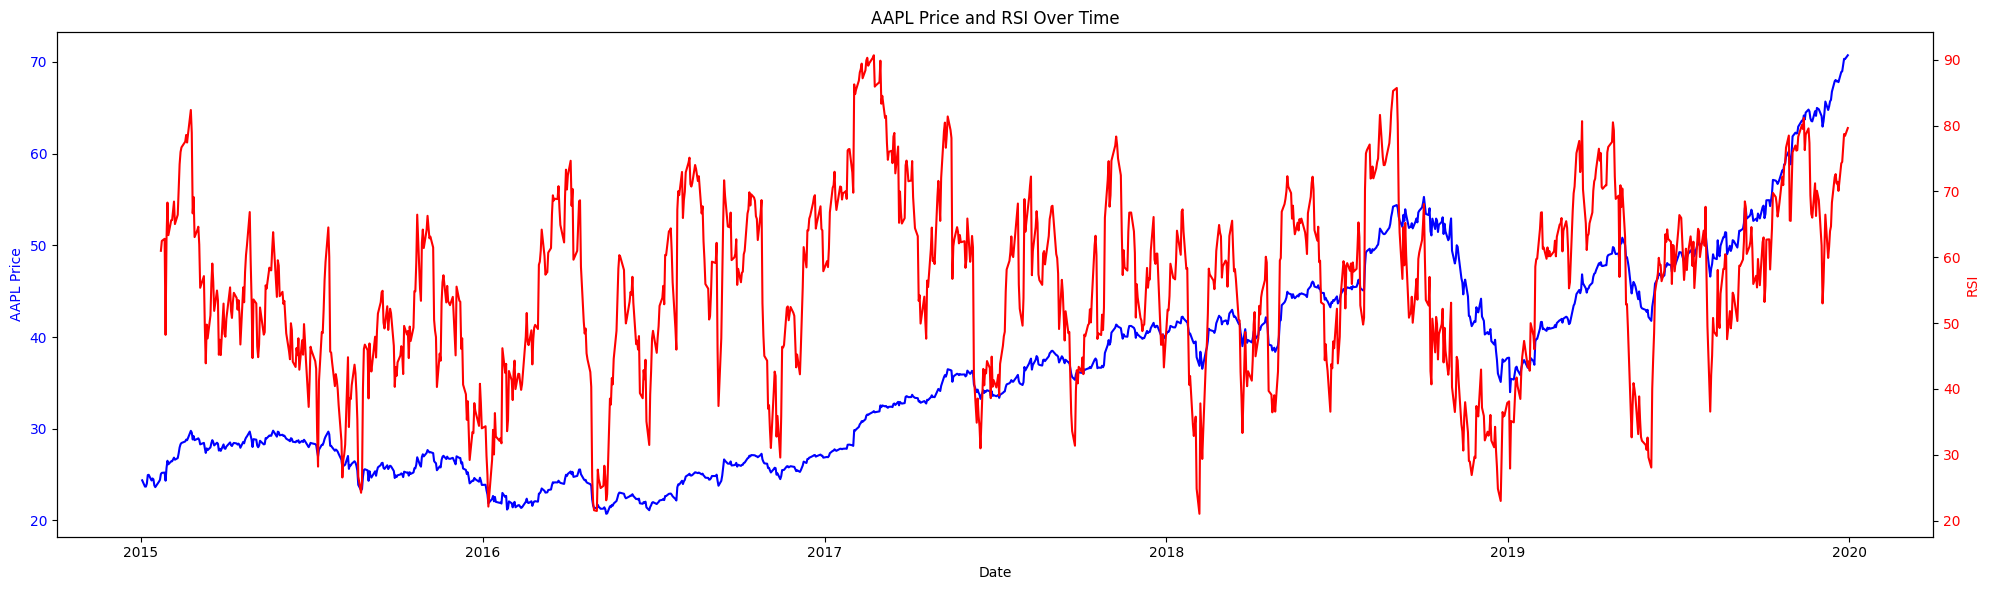

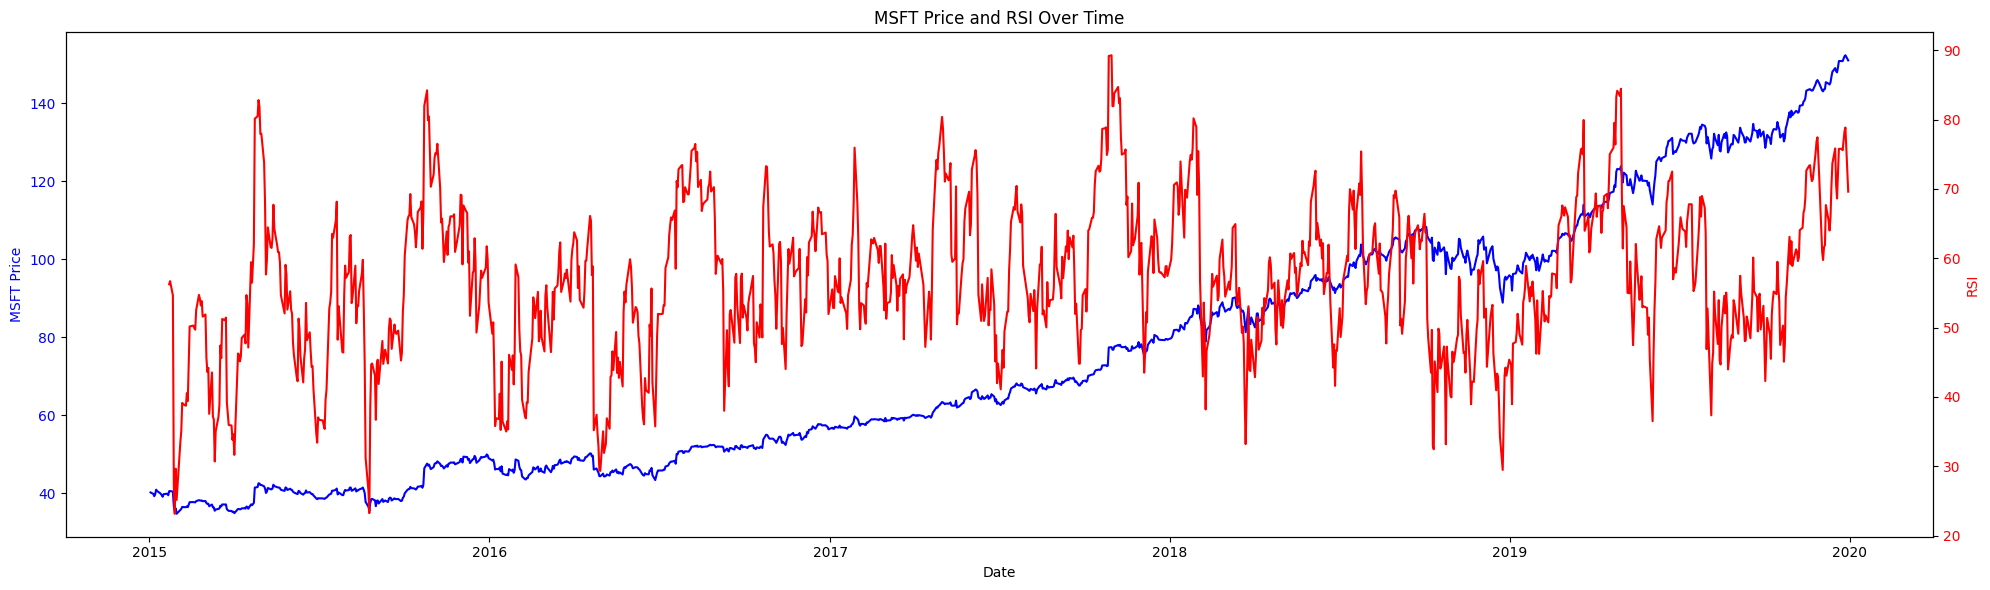

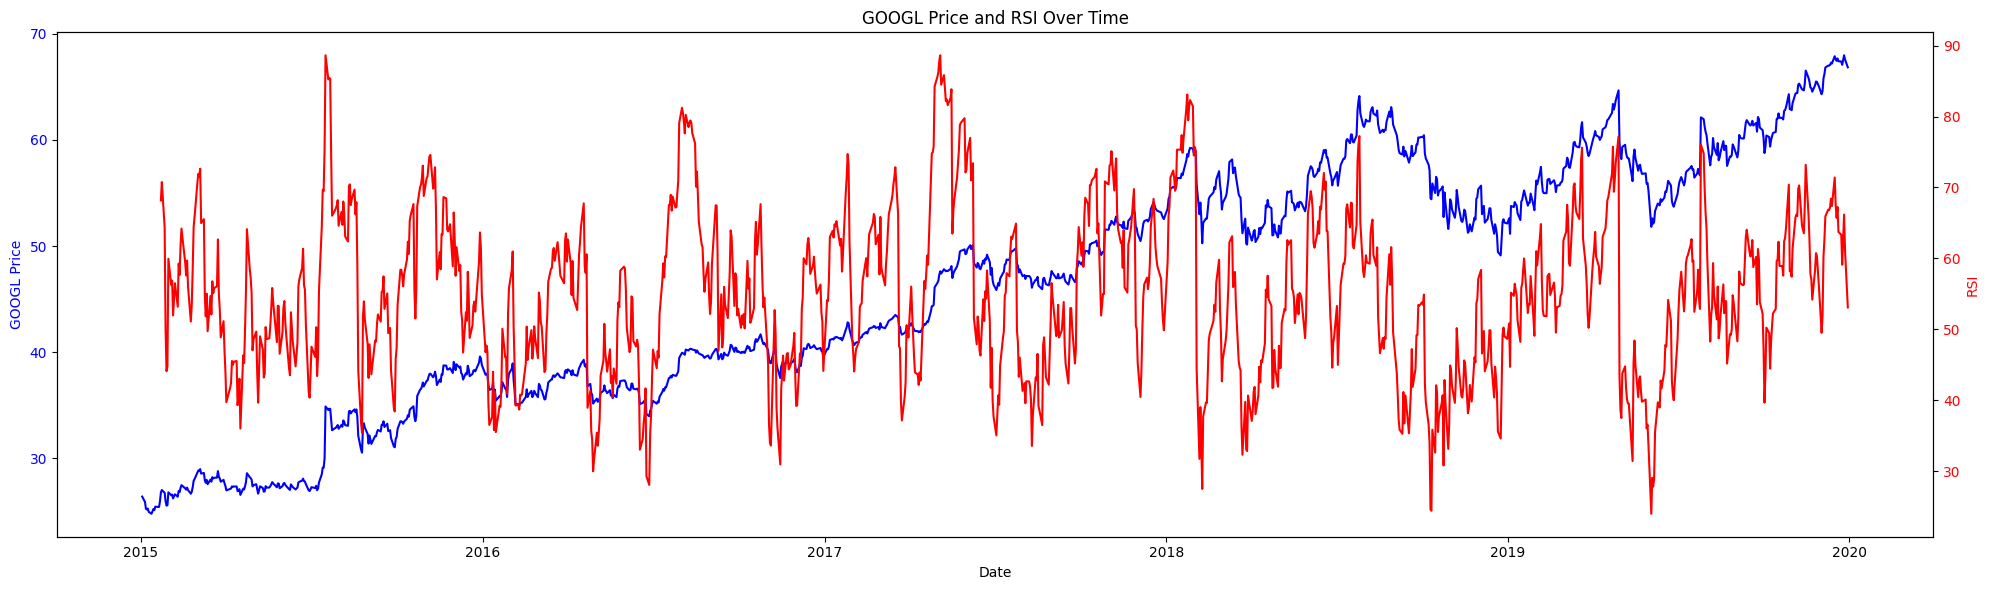

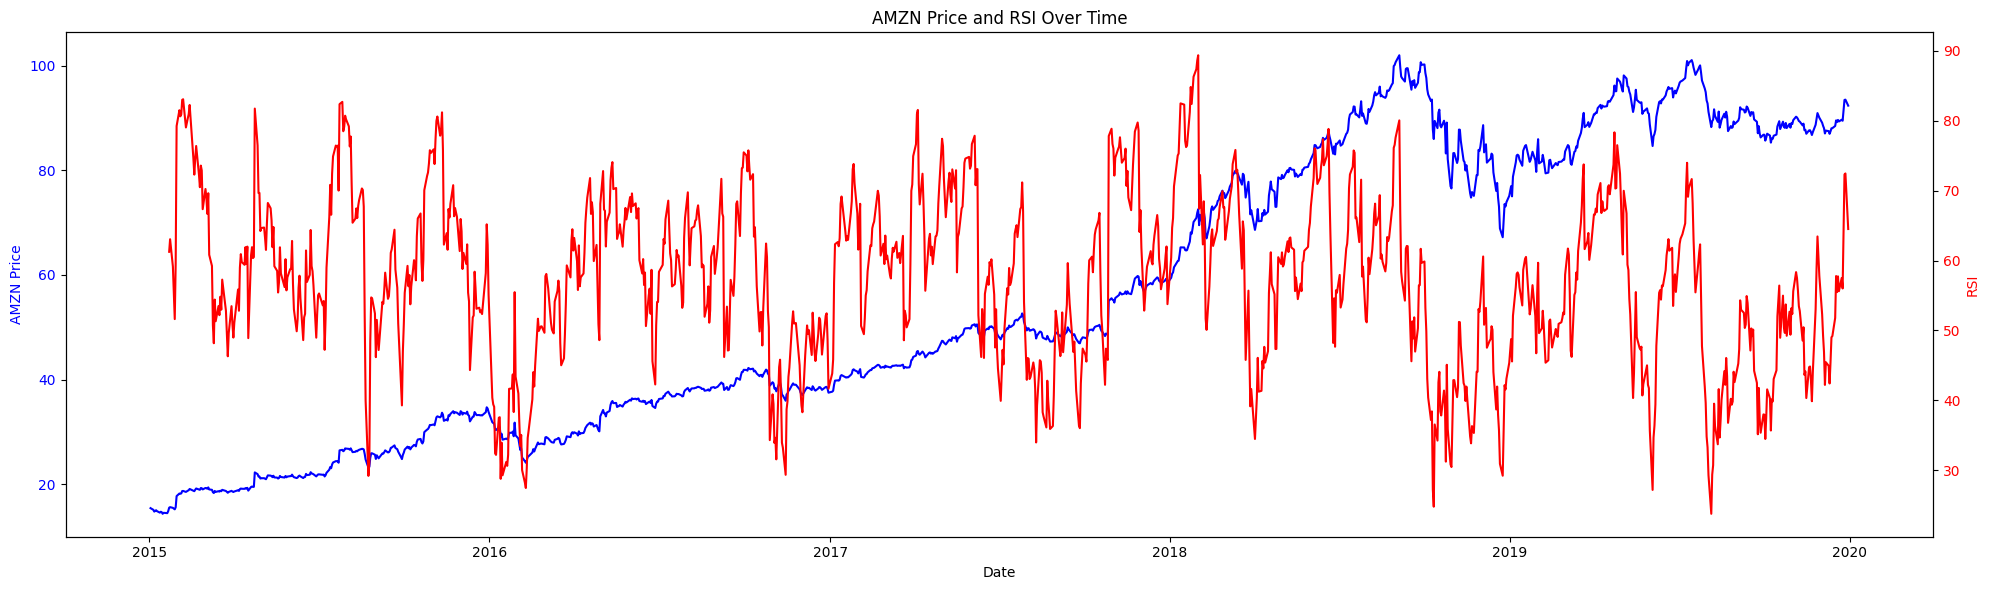

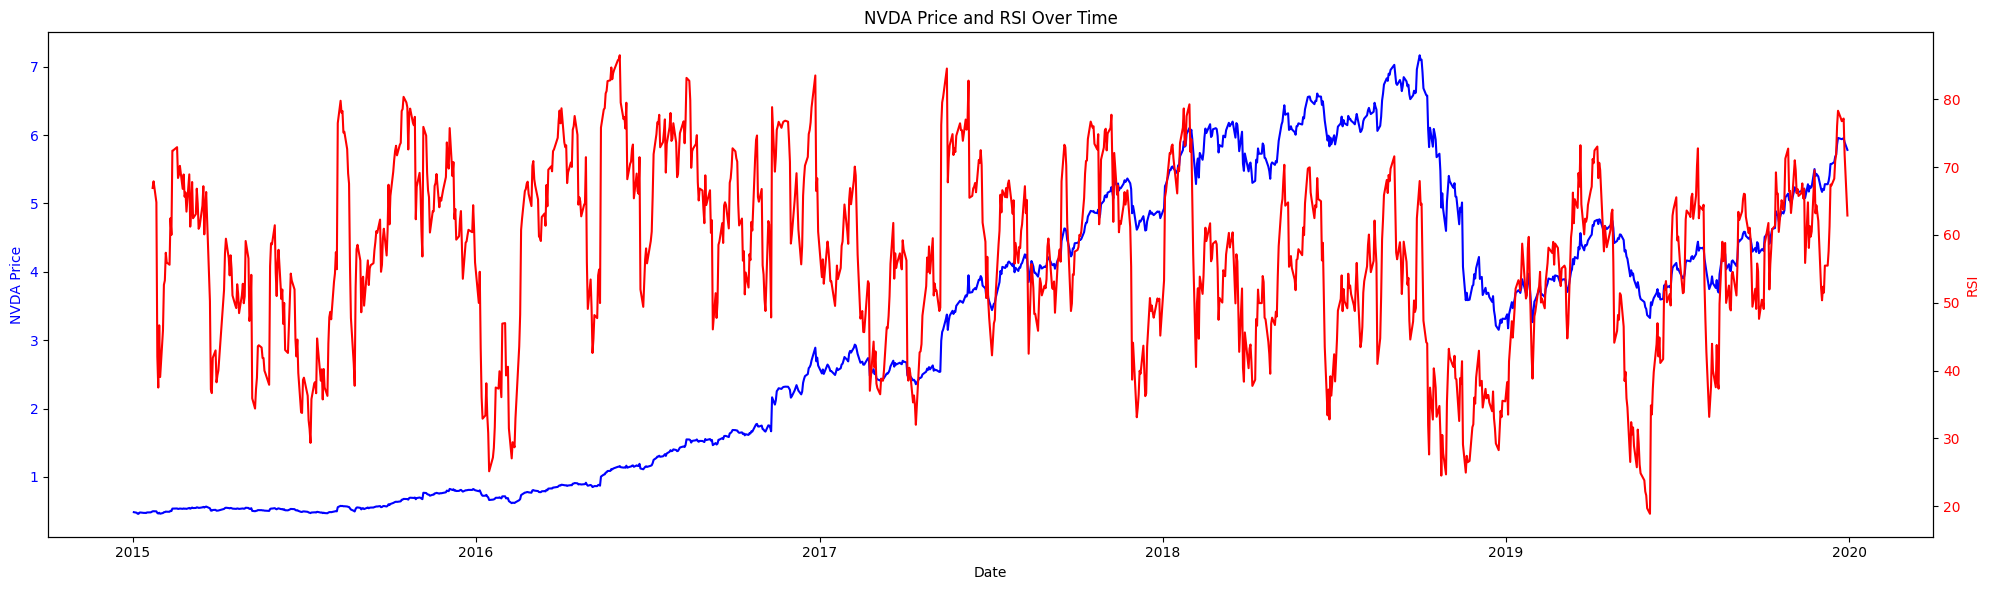

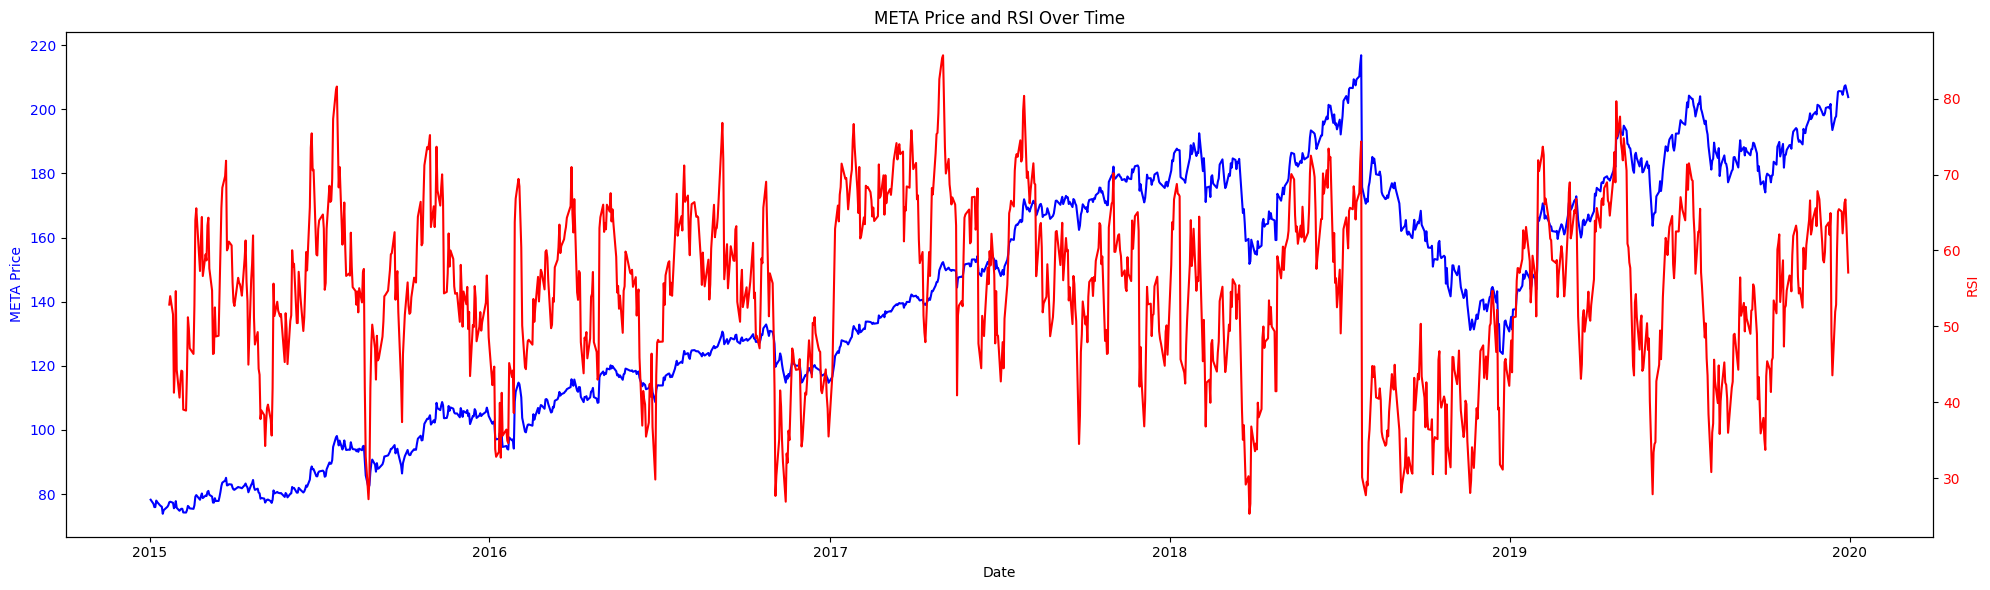

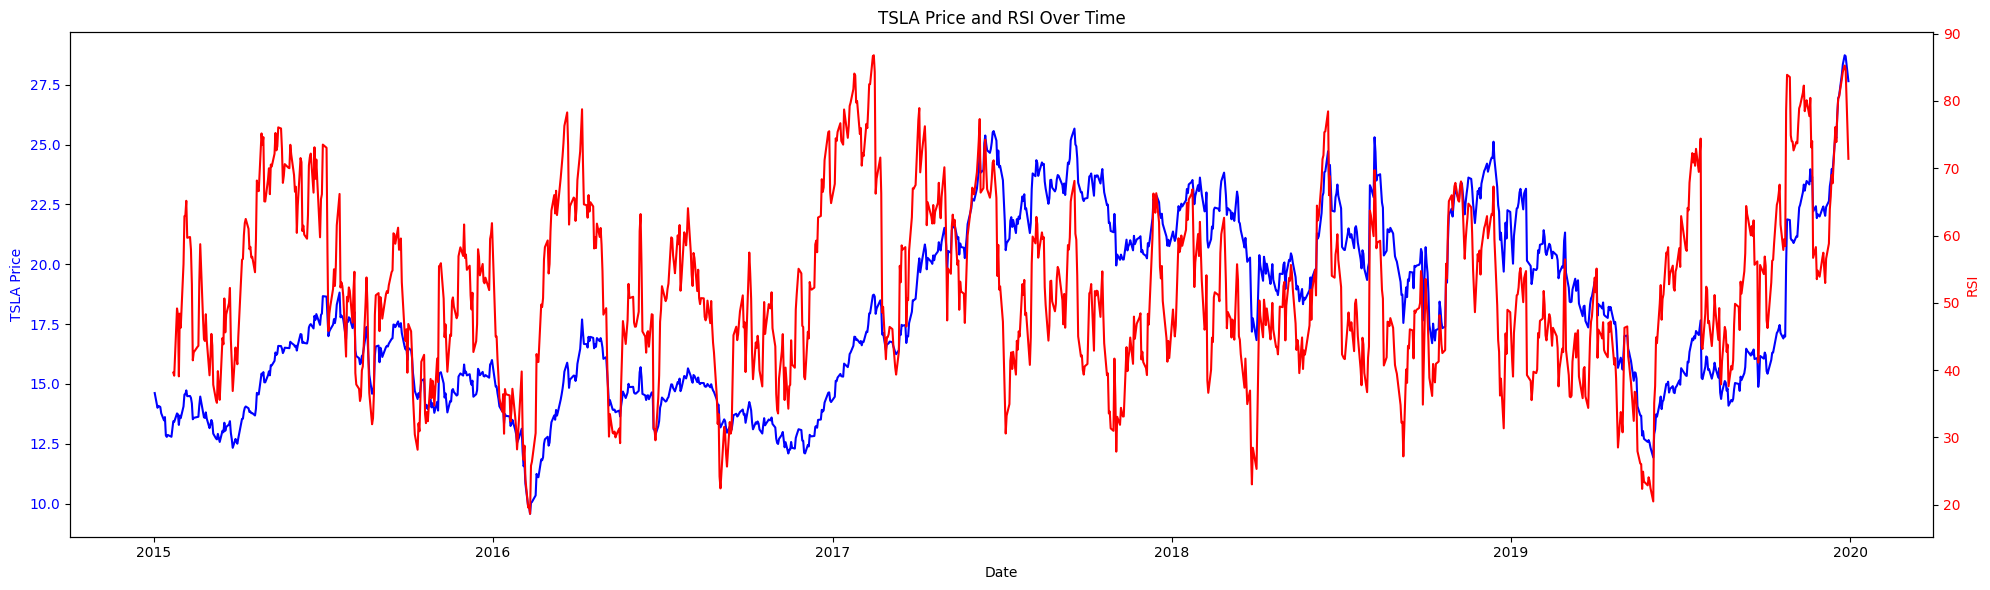

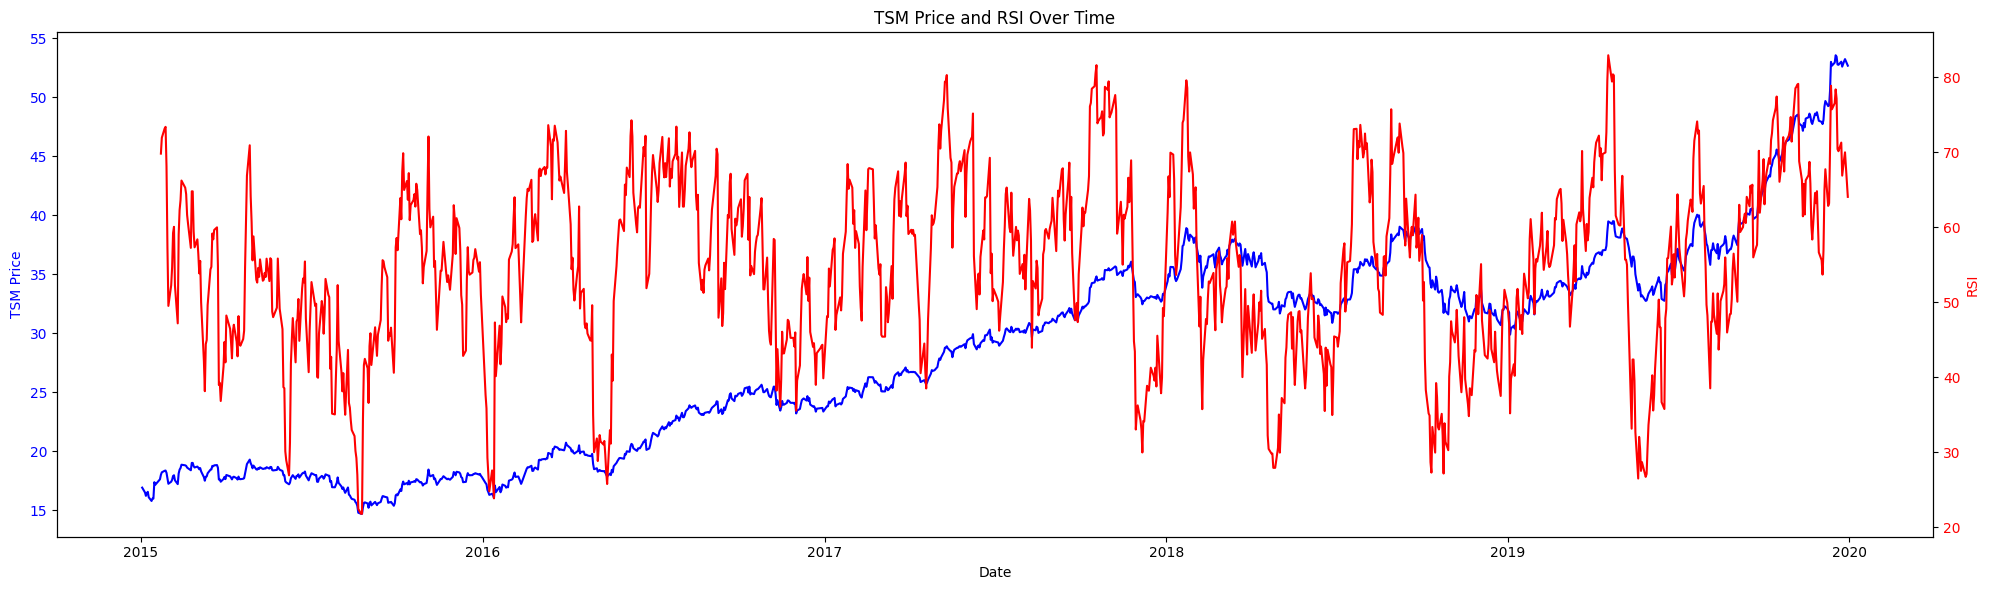

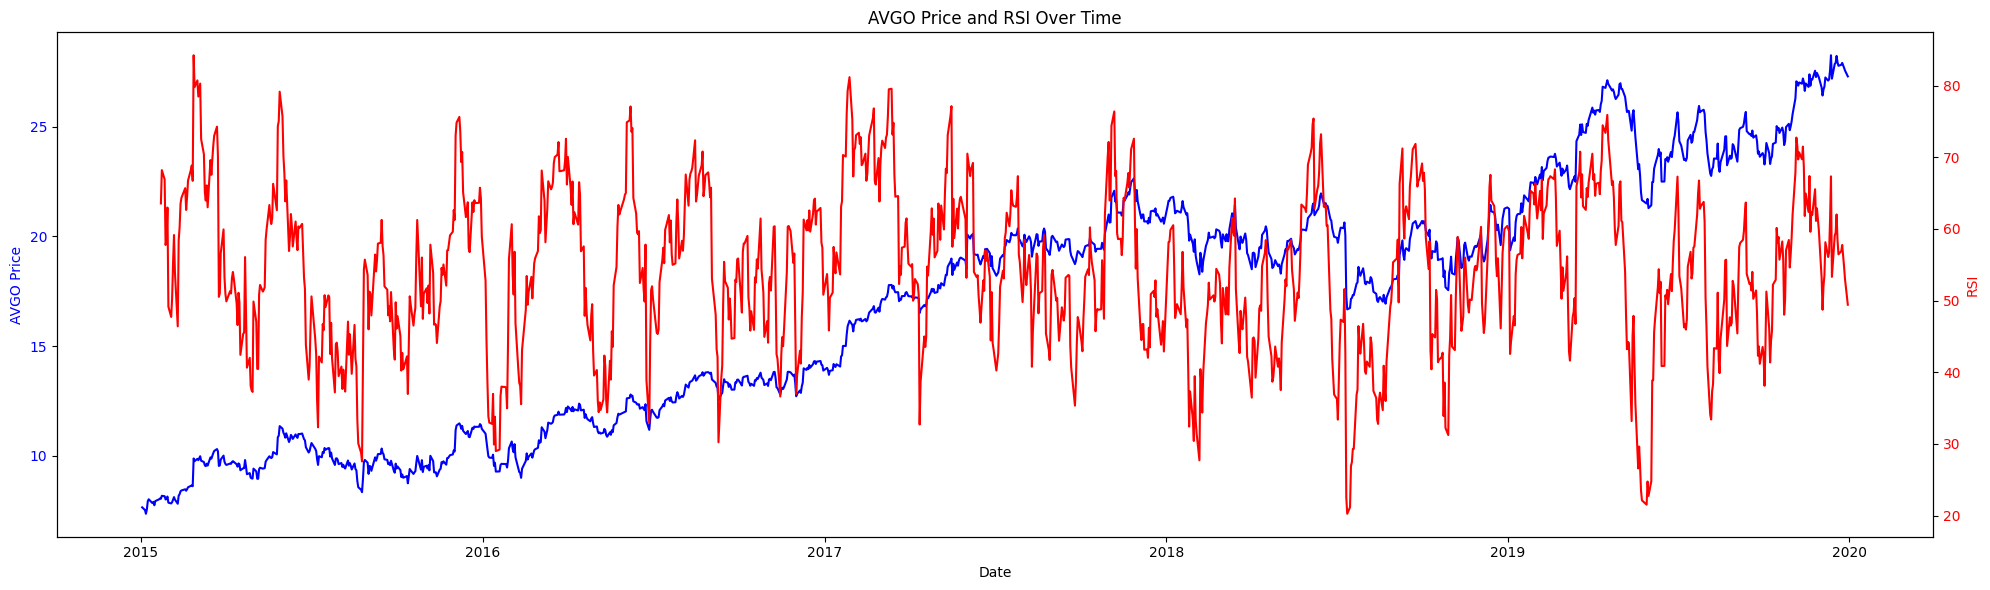

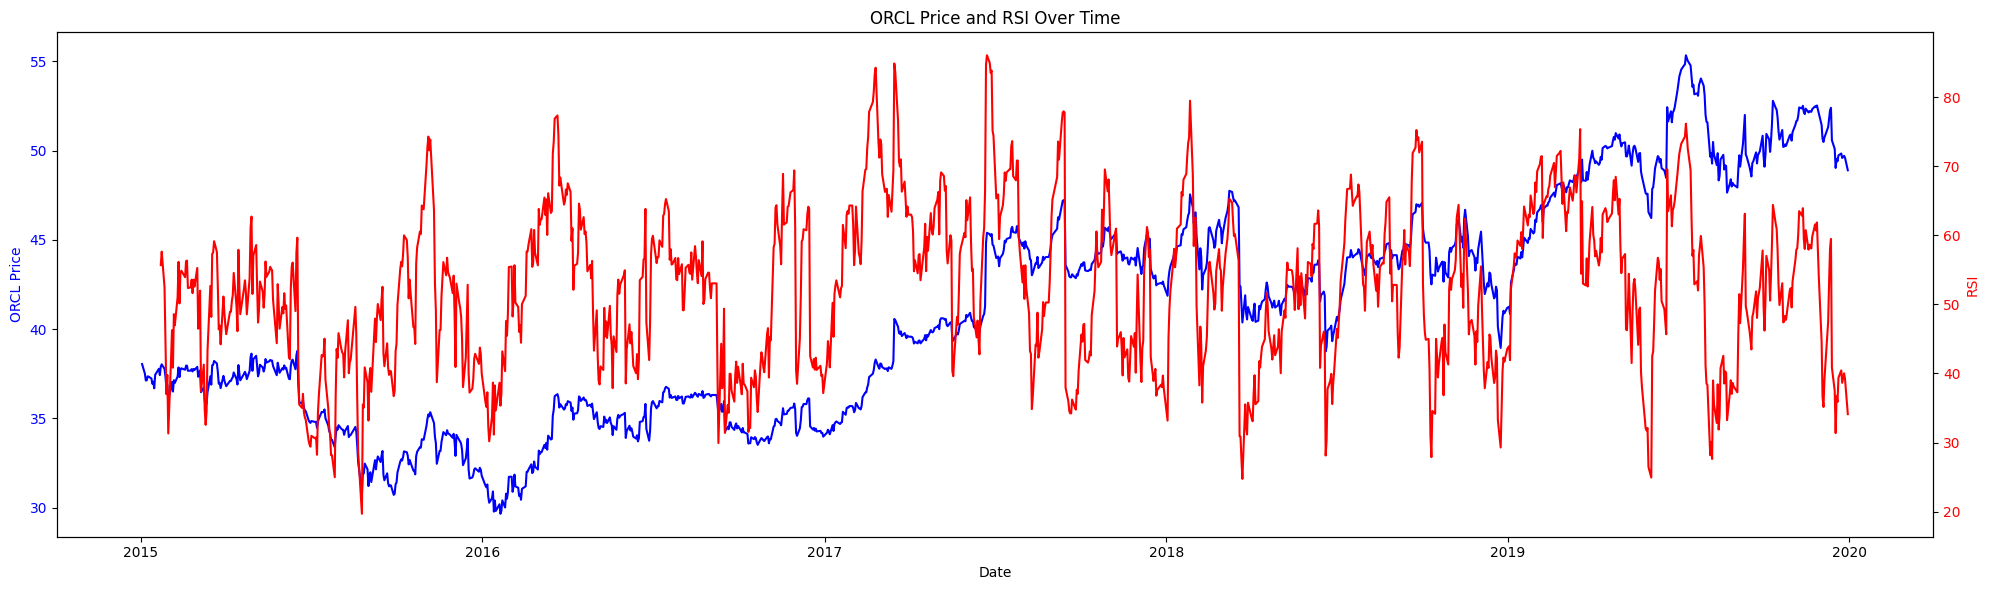

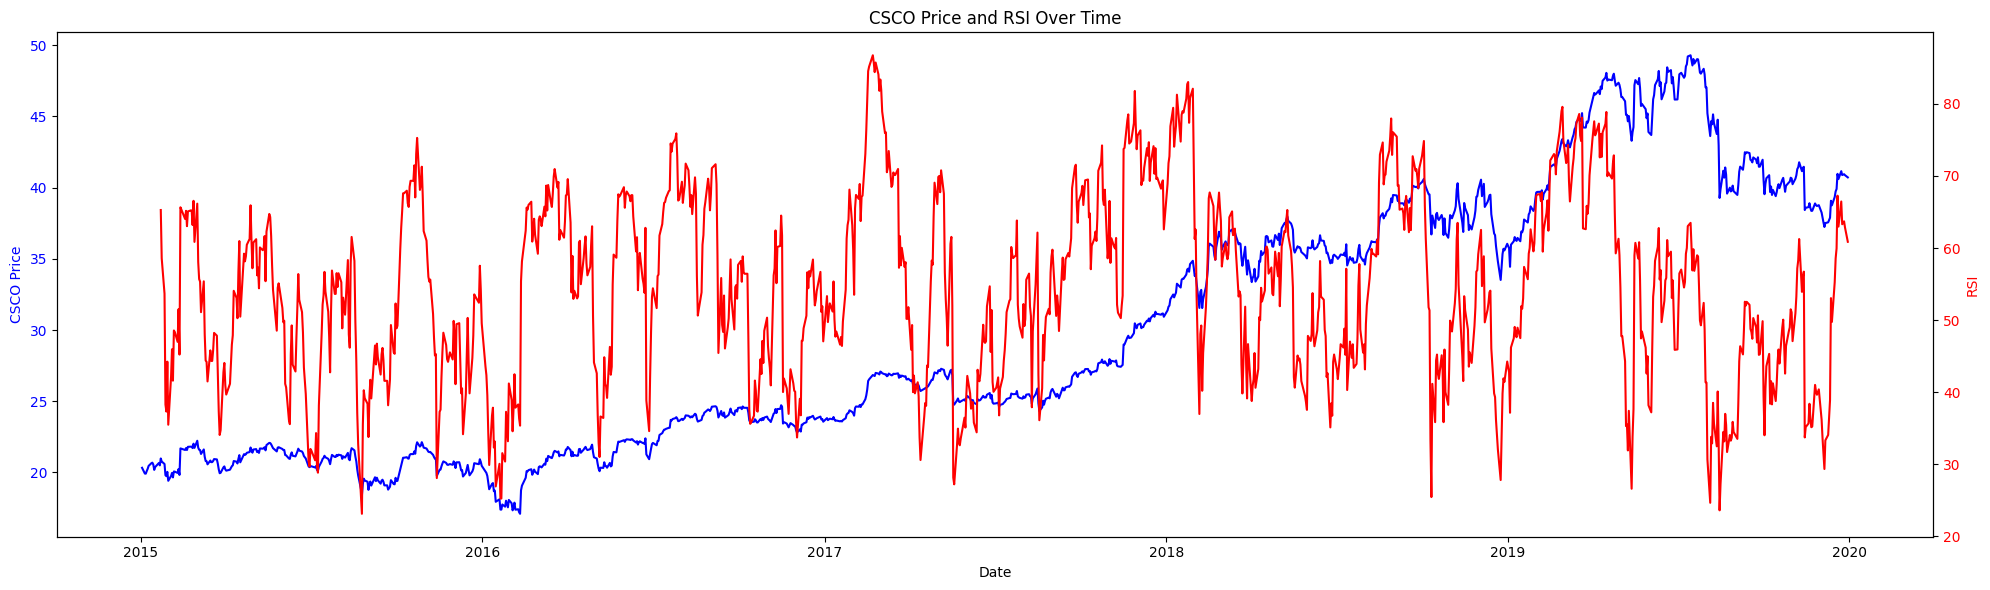

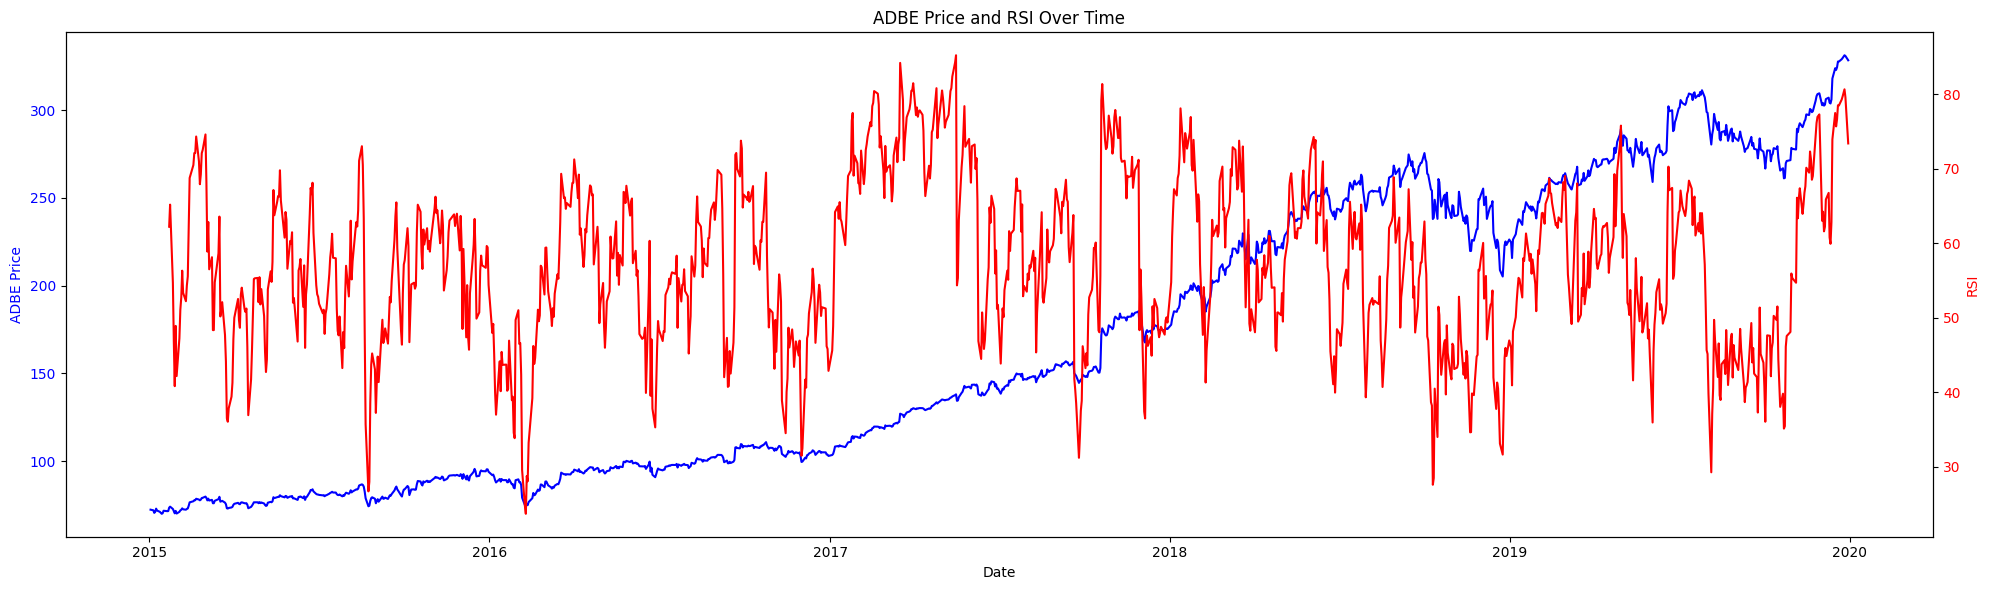

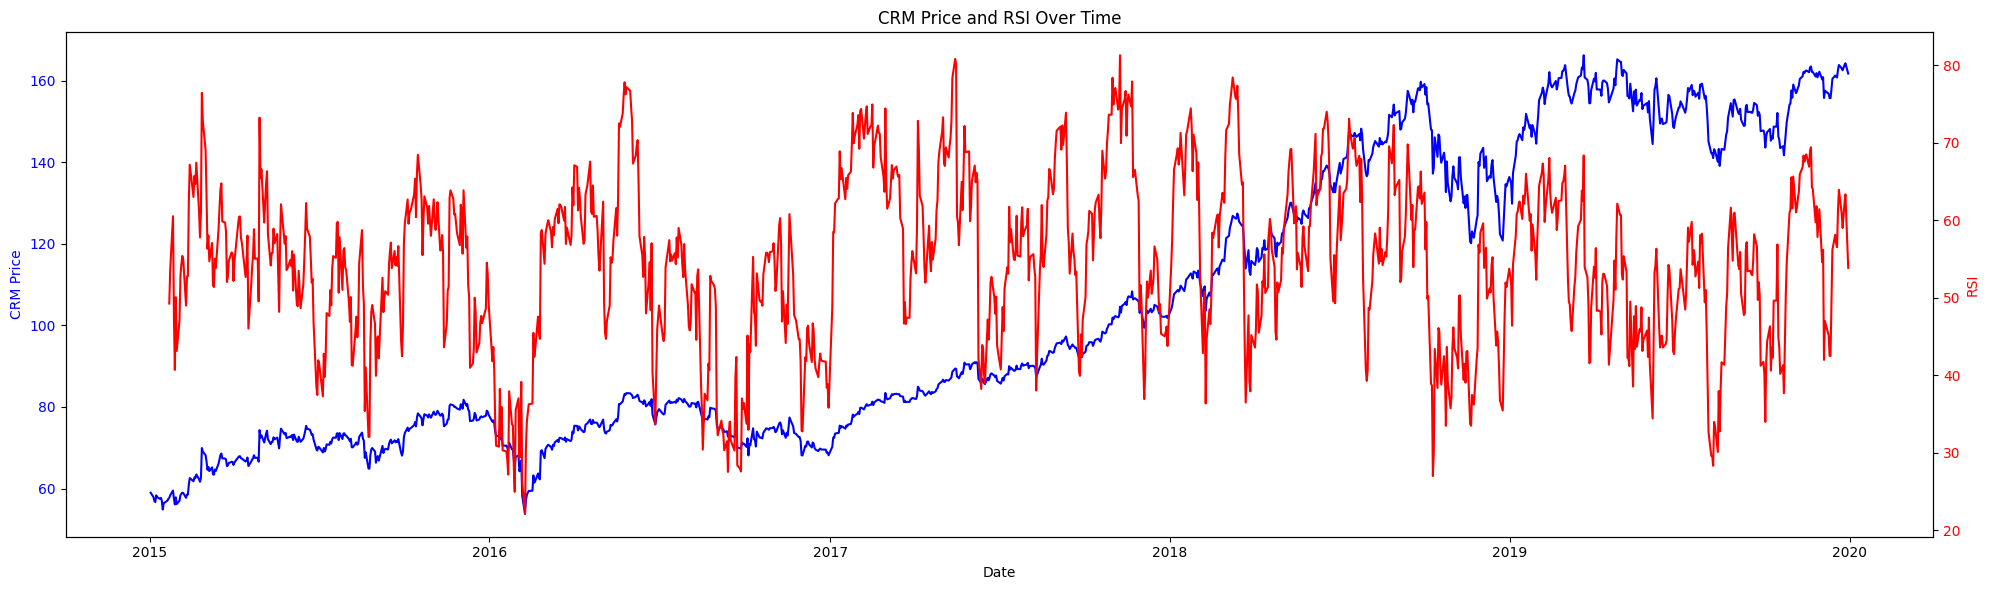

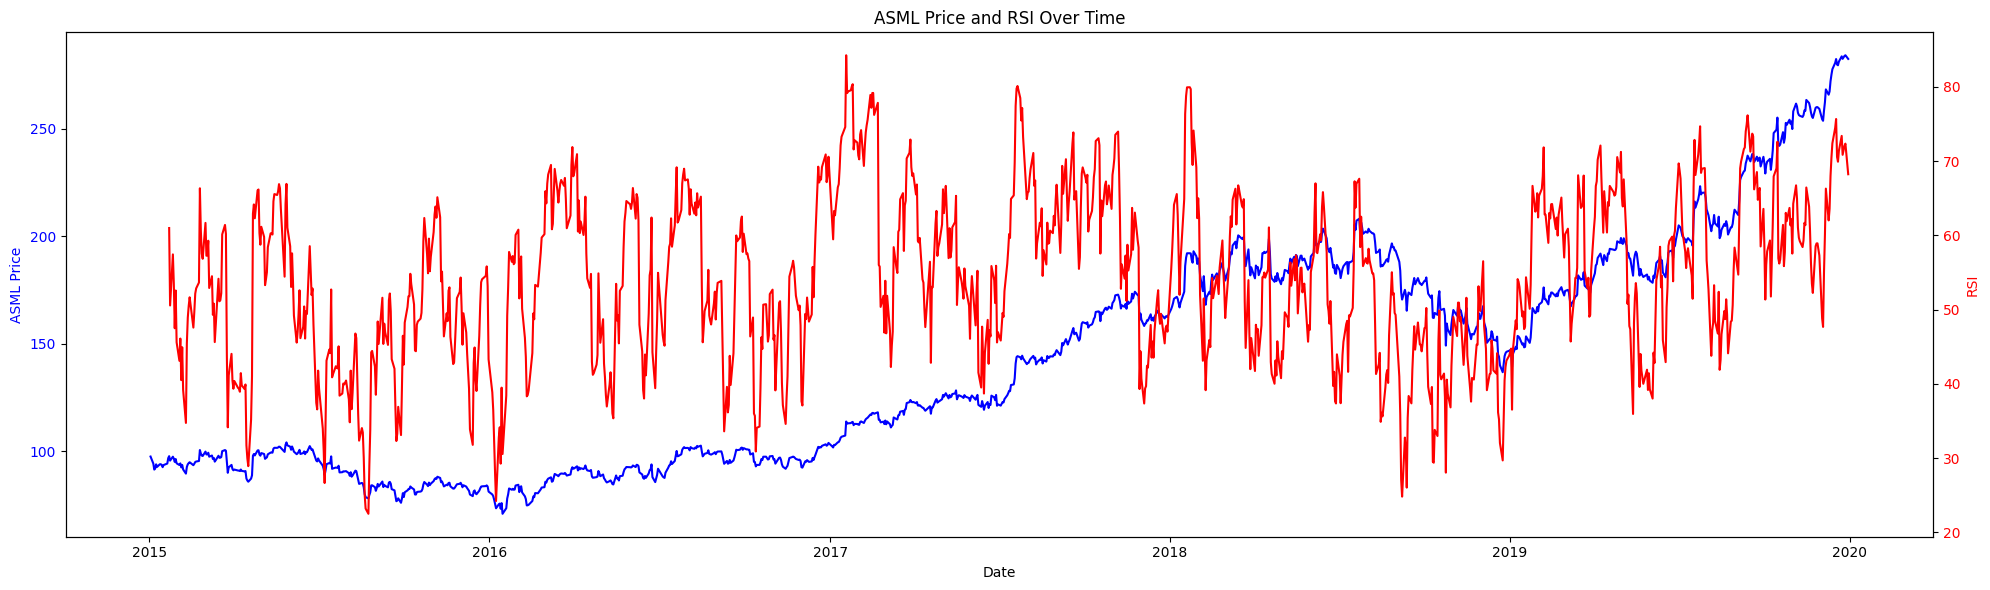

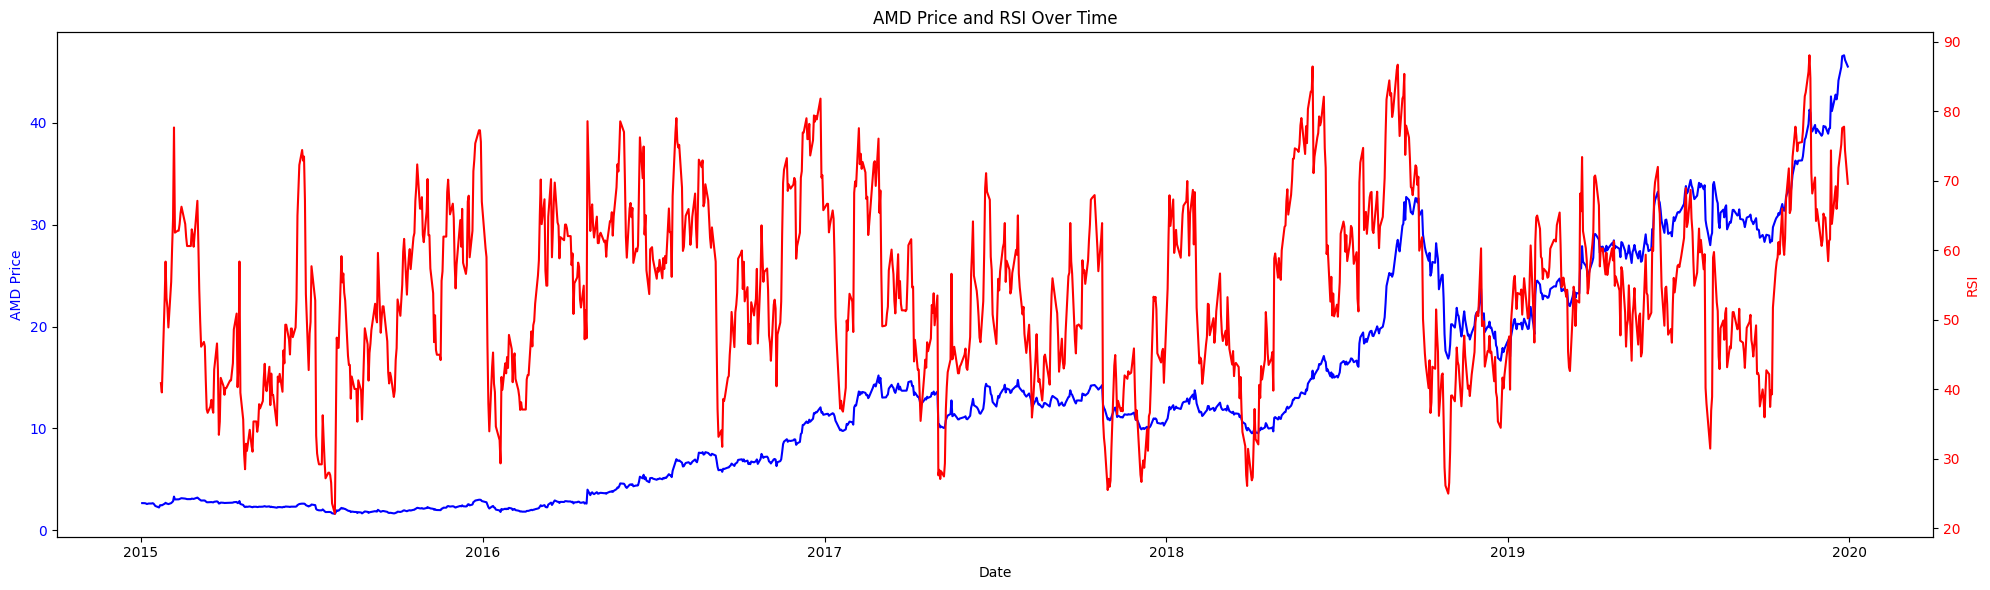

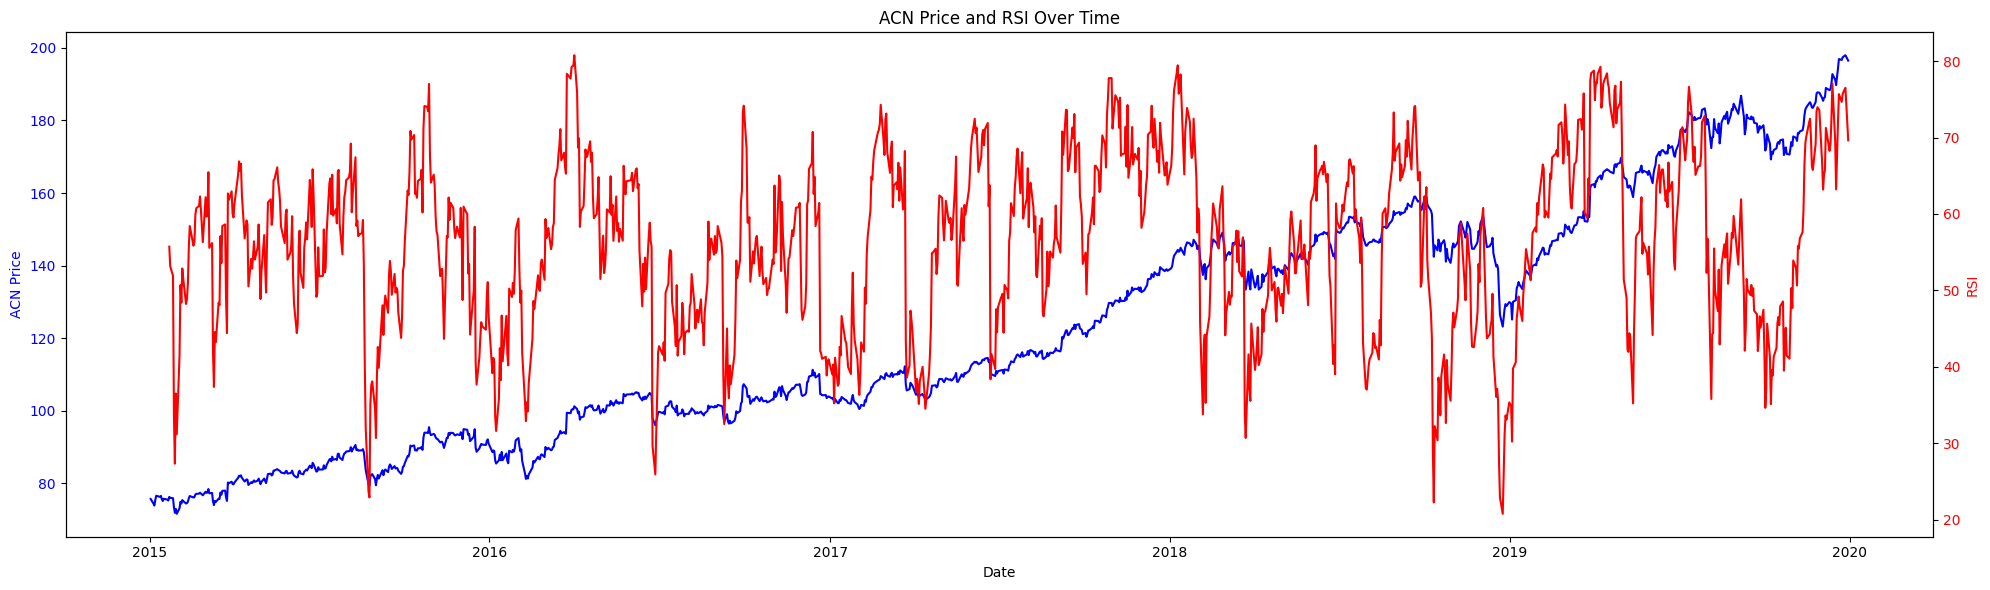

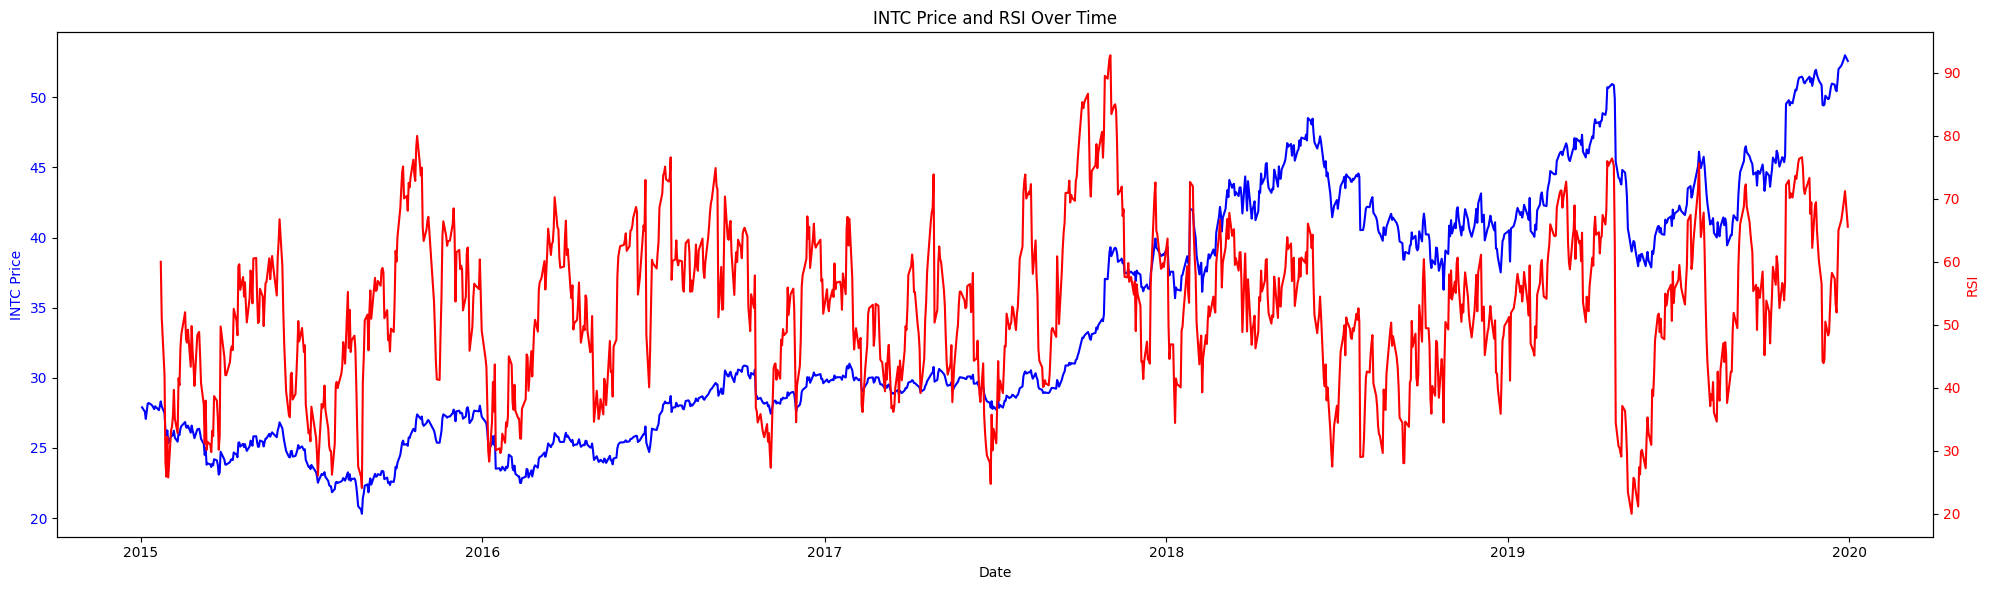

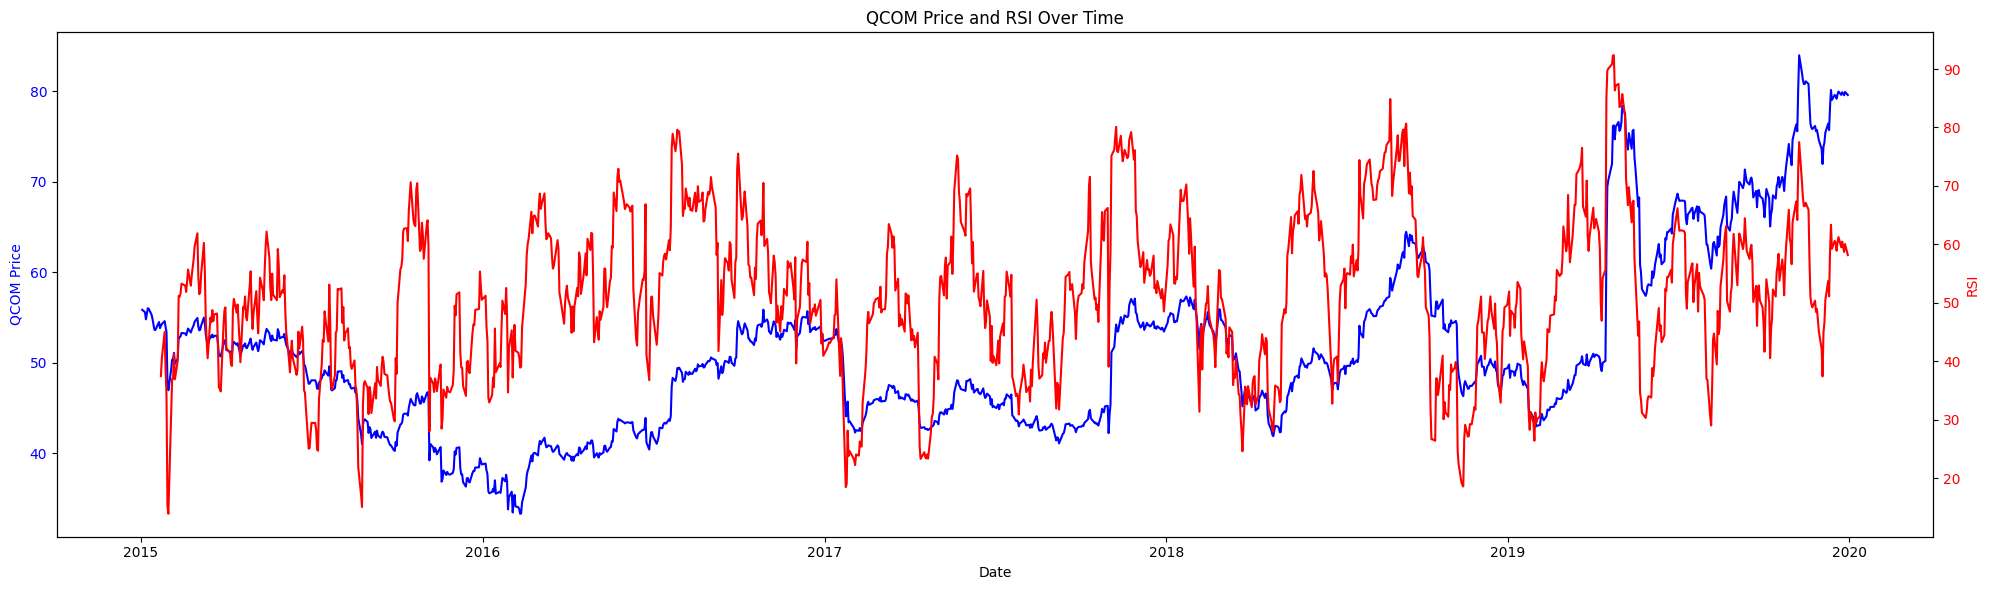

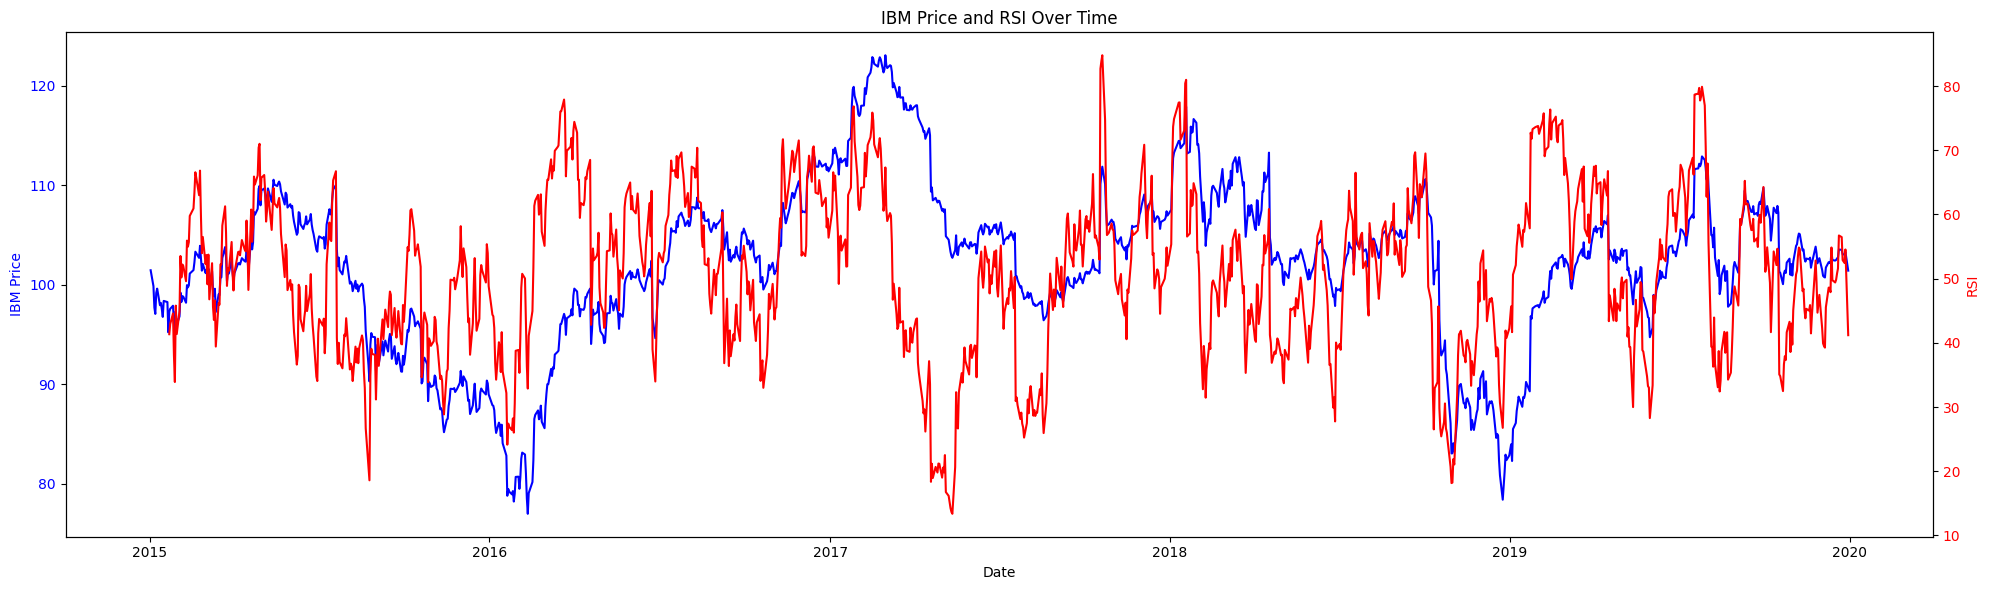

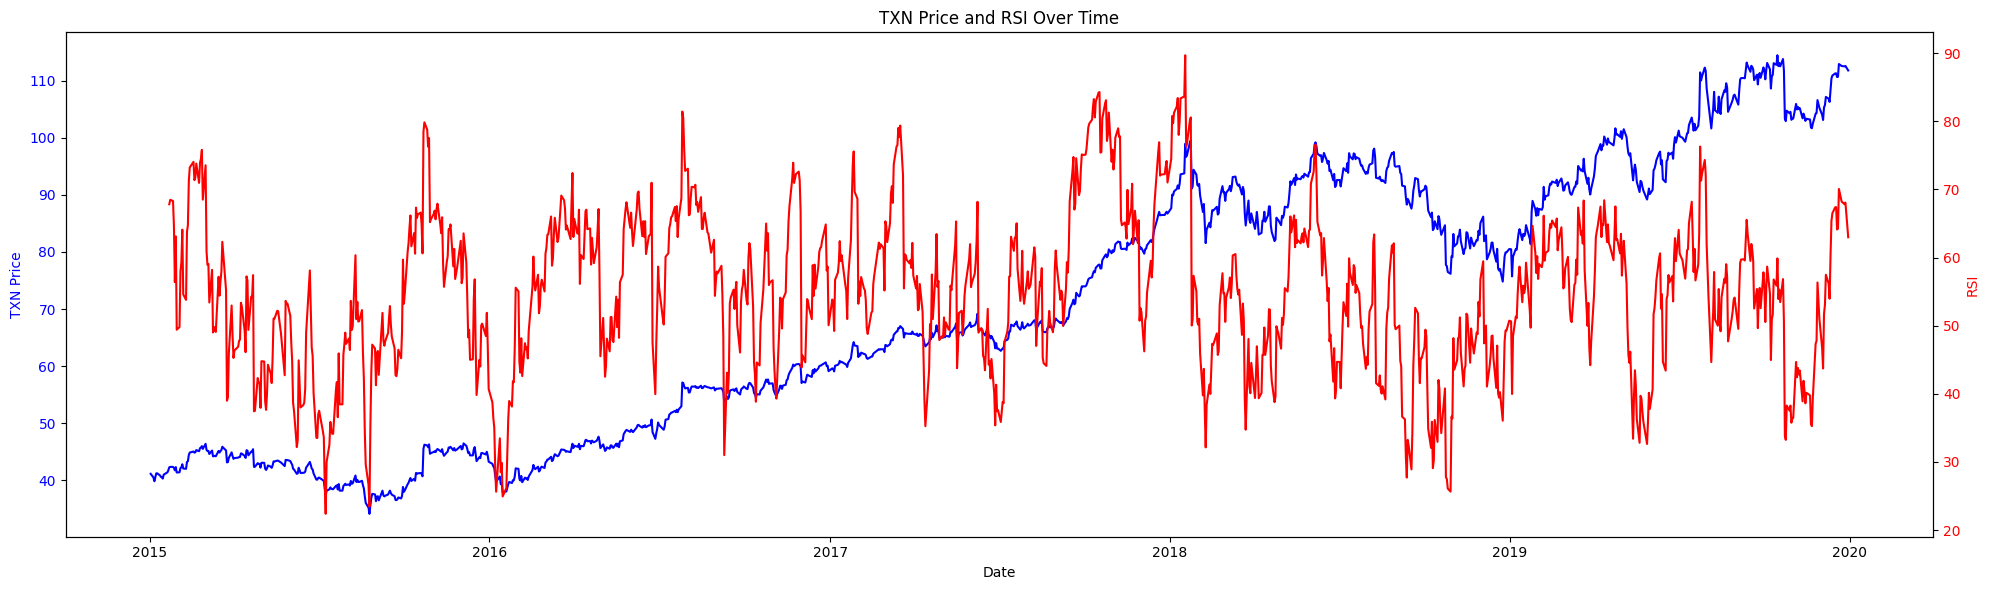

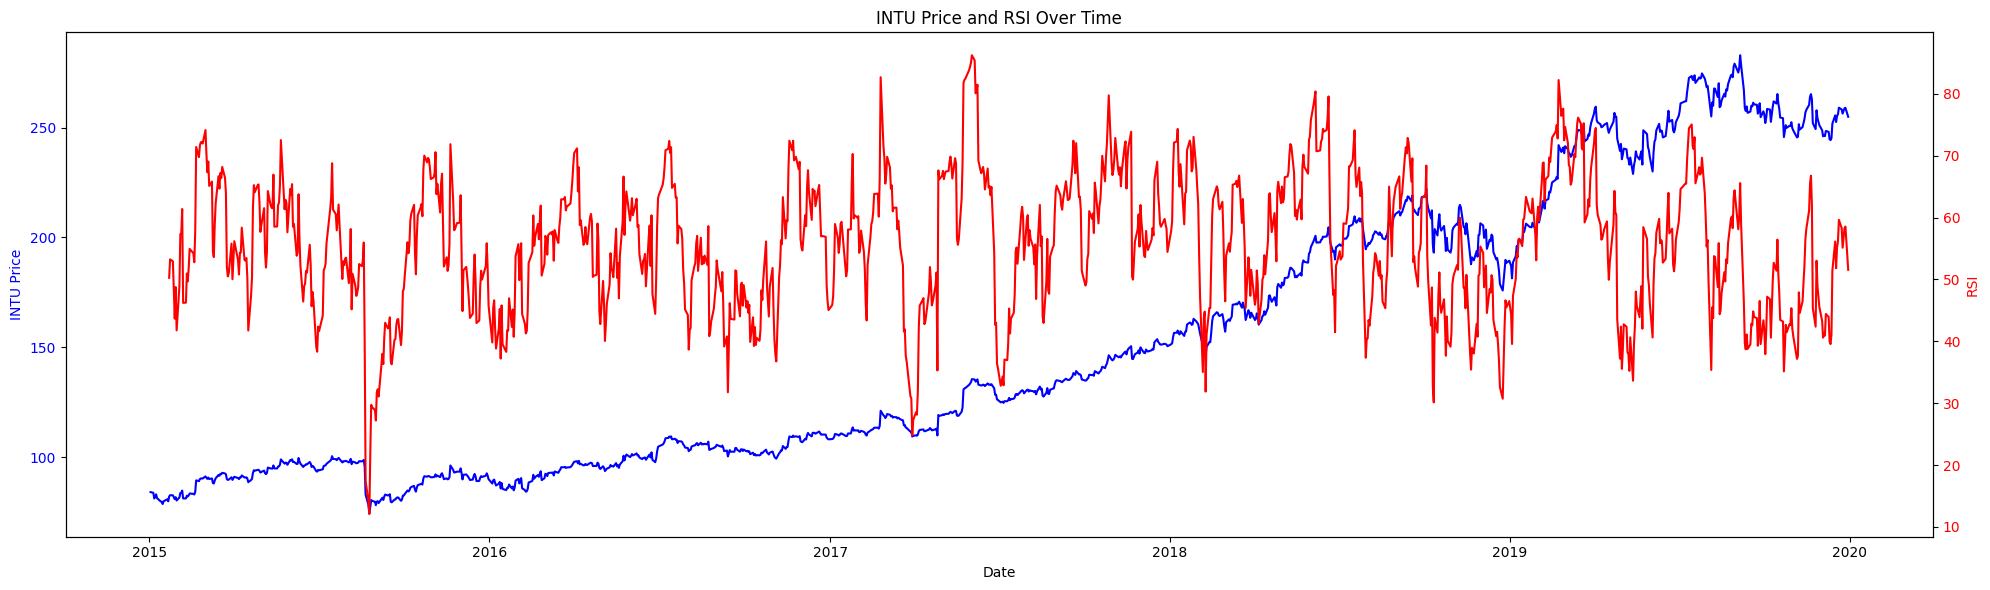

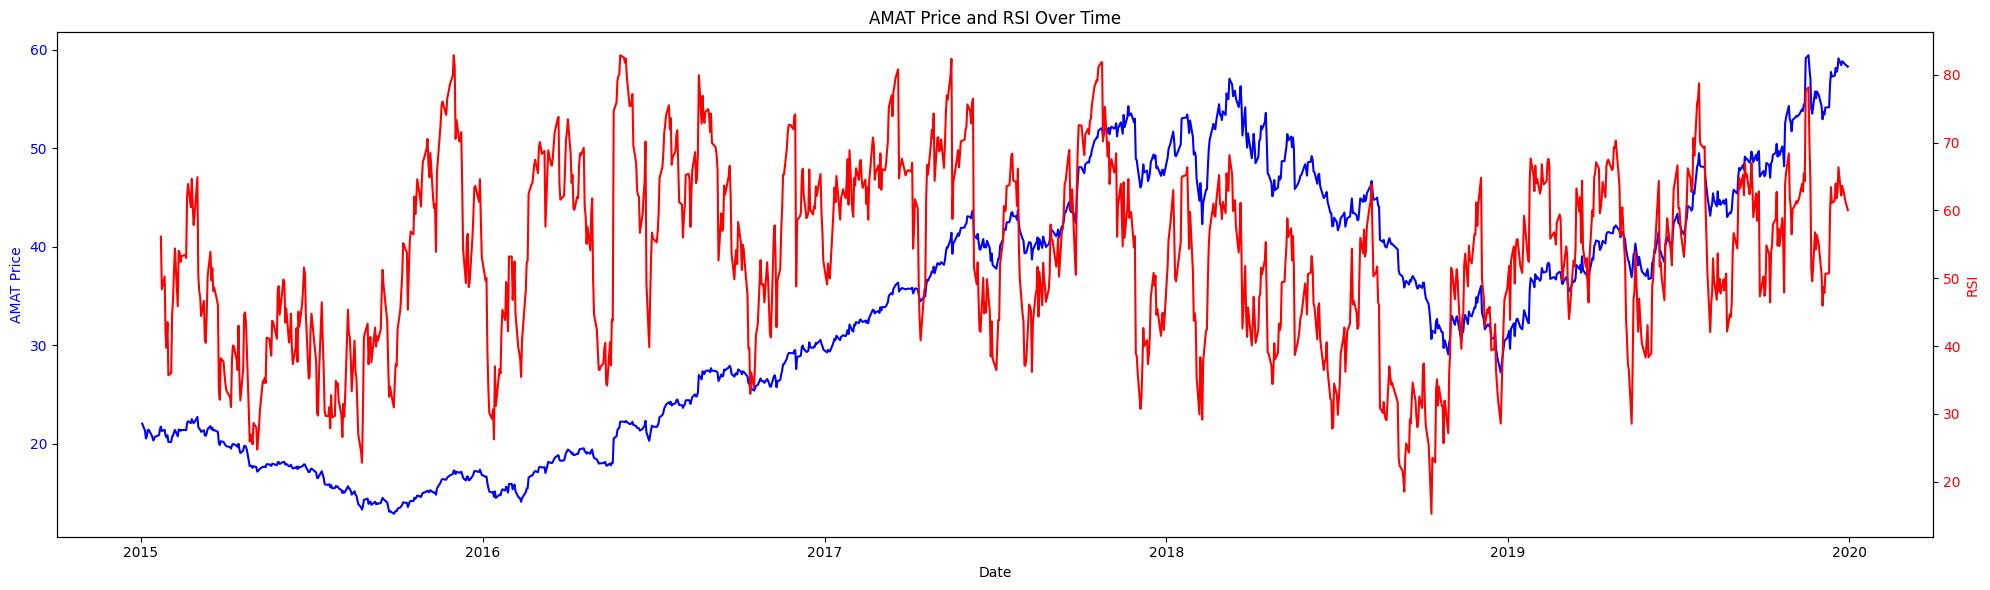

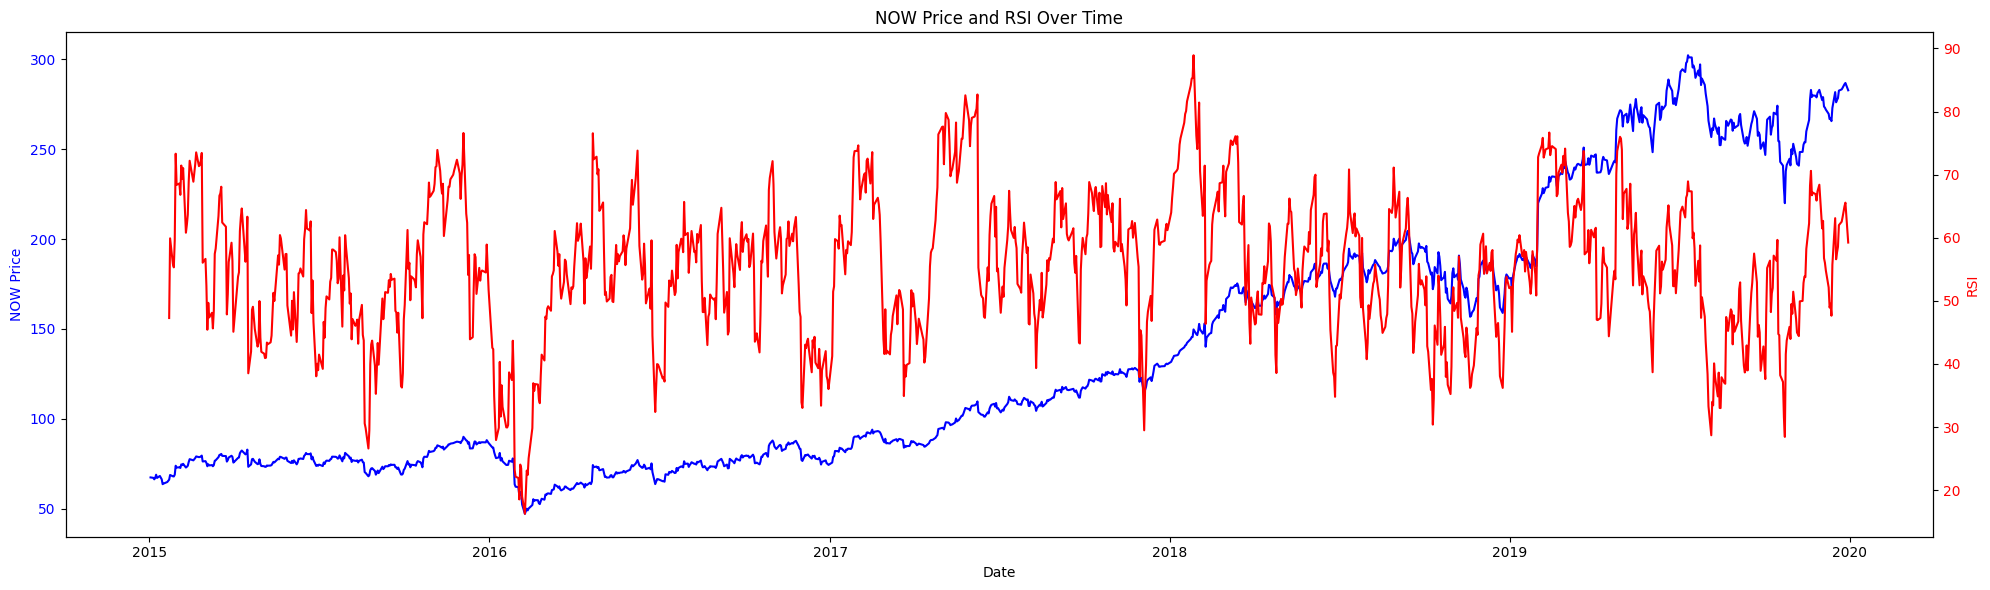

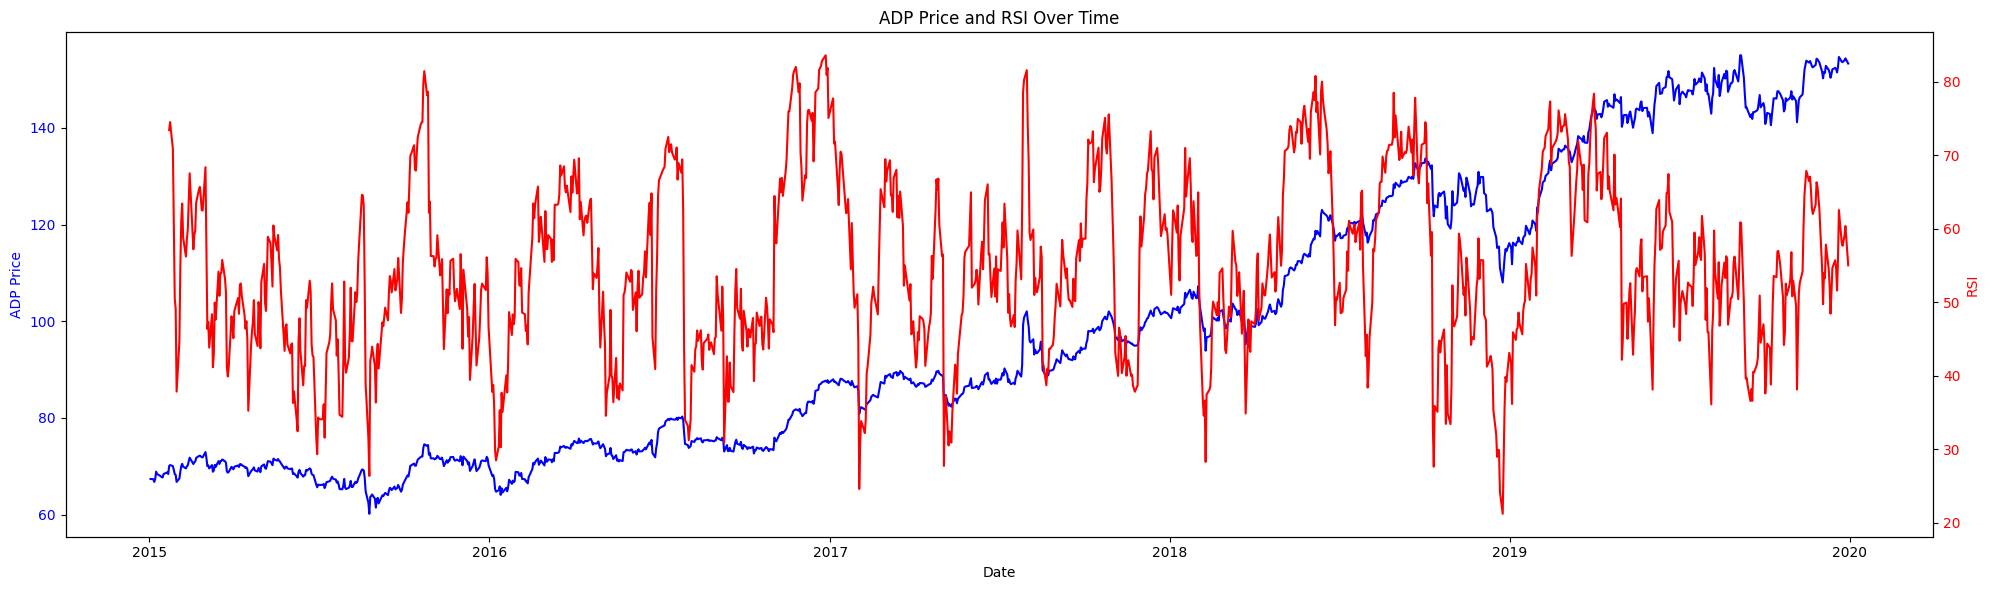

In [9]:
for s in top_25_tech_stocks:
    plot_symbol_and_rsi(all_data_rsi, s)

In [10]:
all_data_rsi['total_MC'] = all_data_rsi[[f'{s}_MC' for s in top_25_tech_stocks]].sum(axis=1)

for s in top_25_tech_stocks:
    all_data_rsi[f'{s}_weight'] = all_data_rsi[f'{s}_MC'] / all_data_rsi['total_MC']
    all_data_rsi[f'{s}_mcweighted_rsi'] = all_data_rsi[f'{s}_rsi'] * all_data_rsi[f'{s}_weight']

all_data_rsi['all_mcweighted_rsi'] = all_data_rsi[[f'{s}_mcweighted_rsi' for s in top_25_tech_stocks]].sum(axis=1)
industry_mcweighted_rsi = all_data_rsi.dropna().reset_index(drop=True)[['timestamp_utc', 'datetime', 'all_mcweighted_rsi']]
industry_mcweighted_rsi

timestamp_utc                  datetime  all_mcweighted_rsi
0     1421902800000 2015-01-22 05:00:00+00:00           59.983609
1     1421989200000 2015-01-23 05:00:00+00:00           61.144636
2     1422248400000 2015-01-26 05:00:00+00:00           59.714104
3     1422334800000 2015-01-27 05:00:00+00:00           45.911794
4     1422421200000 2015-01-28 05:00:00+00:00           44.909361
...             ...                       ...                 ...
1239  1577077200000 2019-12-23 05:00:00+00:00           69.414260
1240  1577163600000 2019-12-24 05:00:00+00:00           68.348500
1241  1577336400000 2019-12-26 05:00:00+00:00           72.109497
1242  1577422800000 2019-12-27 05:00:00+00:00           70.860223
1243  1577682000000 2019-12-30 05:00:00+00:00           64.321326

[1244 rows x 3 columns]

<Axes: title={'center': 'Industry MC Weighted RSI'}, xlabel='datetime'>

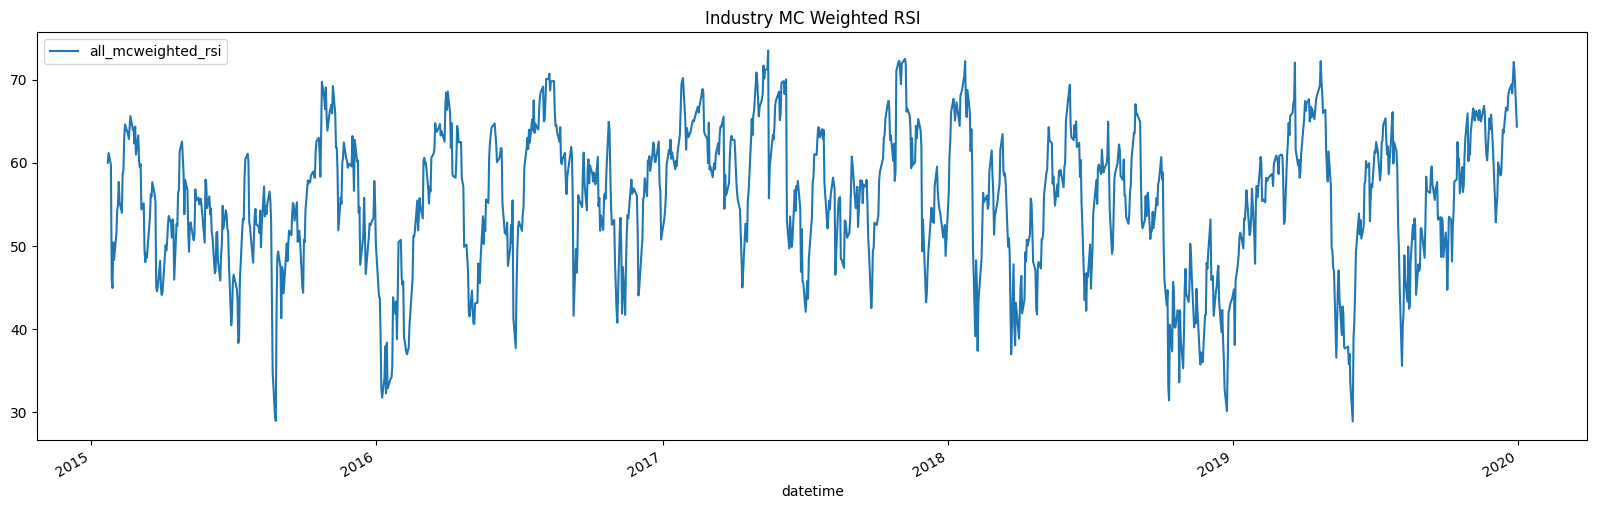

In [11]:
industry_mcweighted_rsi.plot(x='datetime', y='all_mcweighted_rsi', figsize=(20, 6), title="Industry MC Weighted RSI")

# Strategy Development

In [12]:
top_25_tech_stocks = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL",  # Alphabet (Google)
    "AMZN",  # Amazon
    "NVDA",  # NVIDIA
    "META",  # Meta Platforms
    "TSLA",  # Tesla
    "TSM",   # Taiwan Semiconductor Manufacturing Company
    "AVGO",  # Broadcom
    "ORCL",  # Oracle
    "CSCO",  # Cisco Systems
    "ADBE",  # Adobe
    "CRM",   # Salesforce
    "ASML",  # ASML Holding
    "AMD",   # Advanced Micro Devices
    "ACN",   # Accenture
    "INTC",  # Intel
    "QCOM",  # Qualcomm
    "IBM",   # IBM
    "TXN",   # Texas Instruments
    # "PYPL",  # PayPal - Has missing values before 2015
    "INTU",  # Intuit
    "AMAT",  # Applied Materials
    "NOW",   # ServiceNow
    "ADP"    # Automatic Data Processing
]
from ta.momentum import RSIIndicator

def generate_mcweighted_rsi(symbols, start_date, end_date, interval, rsi_window):
    all_data = None
    for s in symbols:
        try:
            data = prepare_data(s, start_date, end_date, interval)
            if all_data is None:
                all_data = data[['timestamp_utc', 'Close', 'MC']].rename(columns={'Close': s + '_Close', 'MC': s + '_MC'})
            else:
                all_data = all_data.merge(data[['timestamp_utc', 'Close', 'MC']].rename(columns={'Close': s + '_Close', 'MC': s + '_MC'}), on='timestamp_utc', how='left')
        except Exception as e:
            print(f"Error processing {s}: {e}")
    all_data_rsi = all_data.copy()
    rsi_params = {
        'window': rsi_window,
        'fillna': False
    }
    for s in symbols:
        all_data_rsi[f'{s}_rsi'] = RSIIndicator(close = all_data_rsi[s + '_Close'],
            window=rsi_params['window'],
            fillna=rsi_params['fillna']).rsi()
    all_data_rsi['total_MC'] = all_data_rsi[[f'{s}_MC' for s in top_25_tech_stocks]].sum(axis=1)

    for s in top_25_tech_stocks:
        all_data_rsi[f'{s}_weight'] = all_data_rsi[f'{s}_MC'] / all_data_rsi['total_MC']
        all_data_rsi[f'{s}_mcweighted_rsi'] = all_data_rsi[f'{s}_rsi'] * all_data_rsi[f'{s}_weight']

    all_data_rsi['industry_mcweighted_rsi'] = all_data_rsi[[f'{s}_mcweighted_rsi' for s in top_25_tech_stocks]].sum(axis=1)
    industry_mcweighted_rsi = all_data_rsi.dropna().reset_index(drop=True)[['timestamp_utc','industry_mcweighted_rsi']]
    return industry_mcweighted_rsi

generate_mcweighted_rsi(top_25_tech_stocks, start_date=start_date, end_date=end_date, interval=interval, rsi_window=14)

timestamp_utc  industry_mcweighted_rsi
0     1421902800000                59.983609
1     1421989200000                61.144636
2     1422248400000                59.714104
3     1422334800000                45.911794
4     1422421200000                44.909361
...             ...                      ...
1239  1577077200000                69.414260
1240  1577163600000                68.348500
1241  1577336400000                72.109497
1242  1577422800000                70.860223
1243  1577682000000                64.321326

[1244 rows x 2 columns]

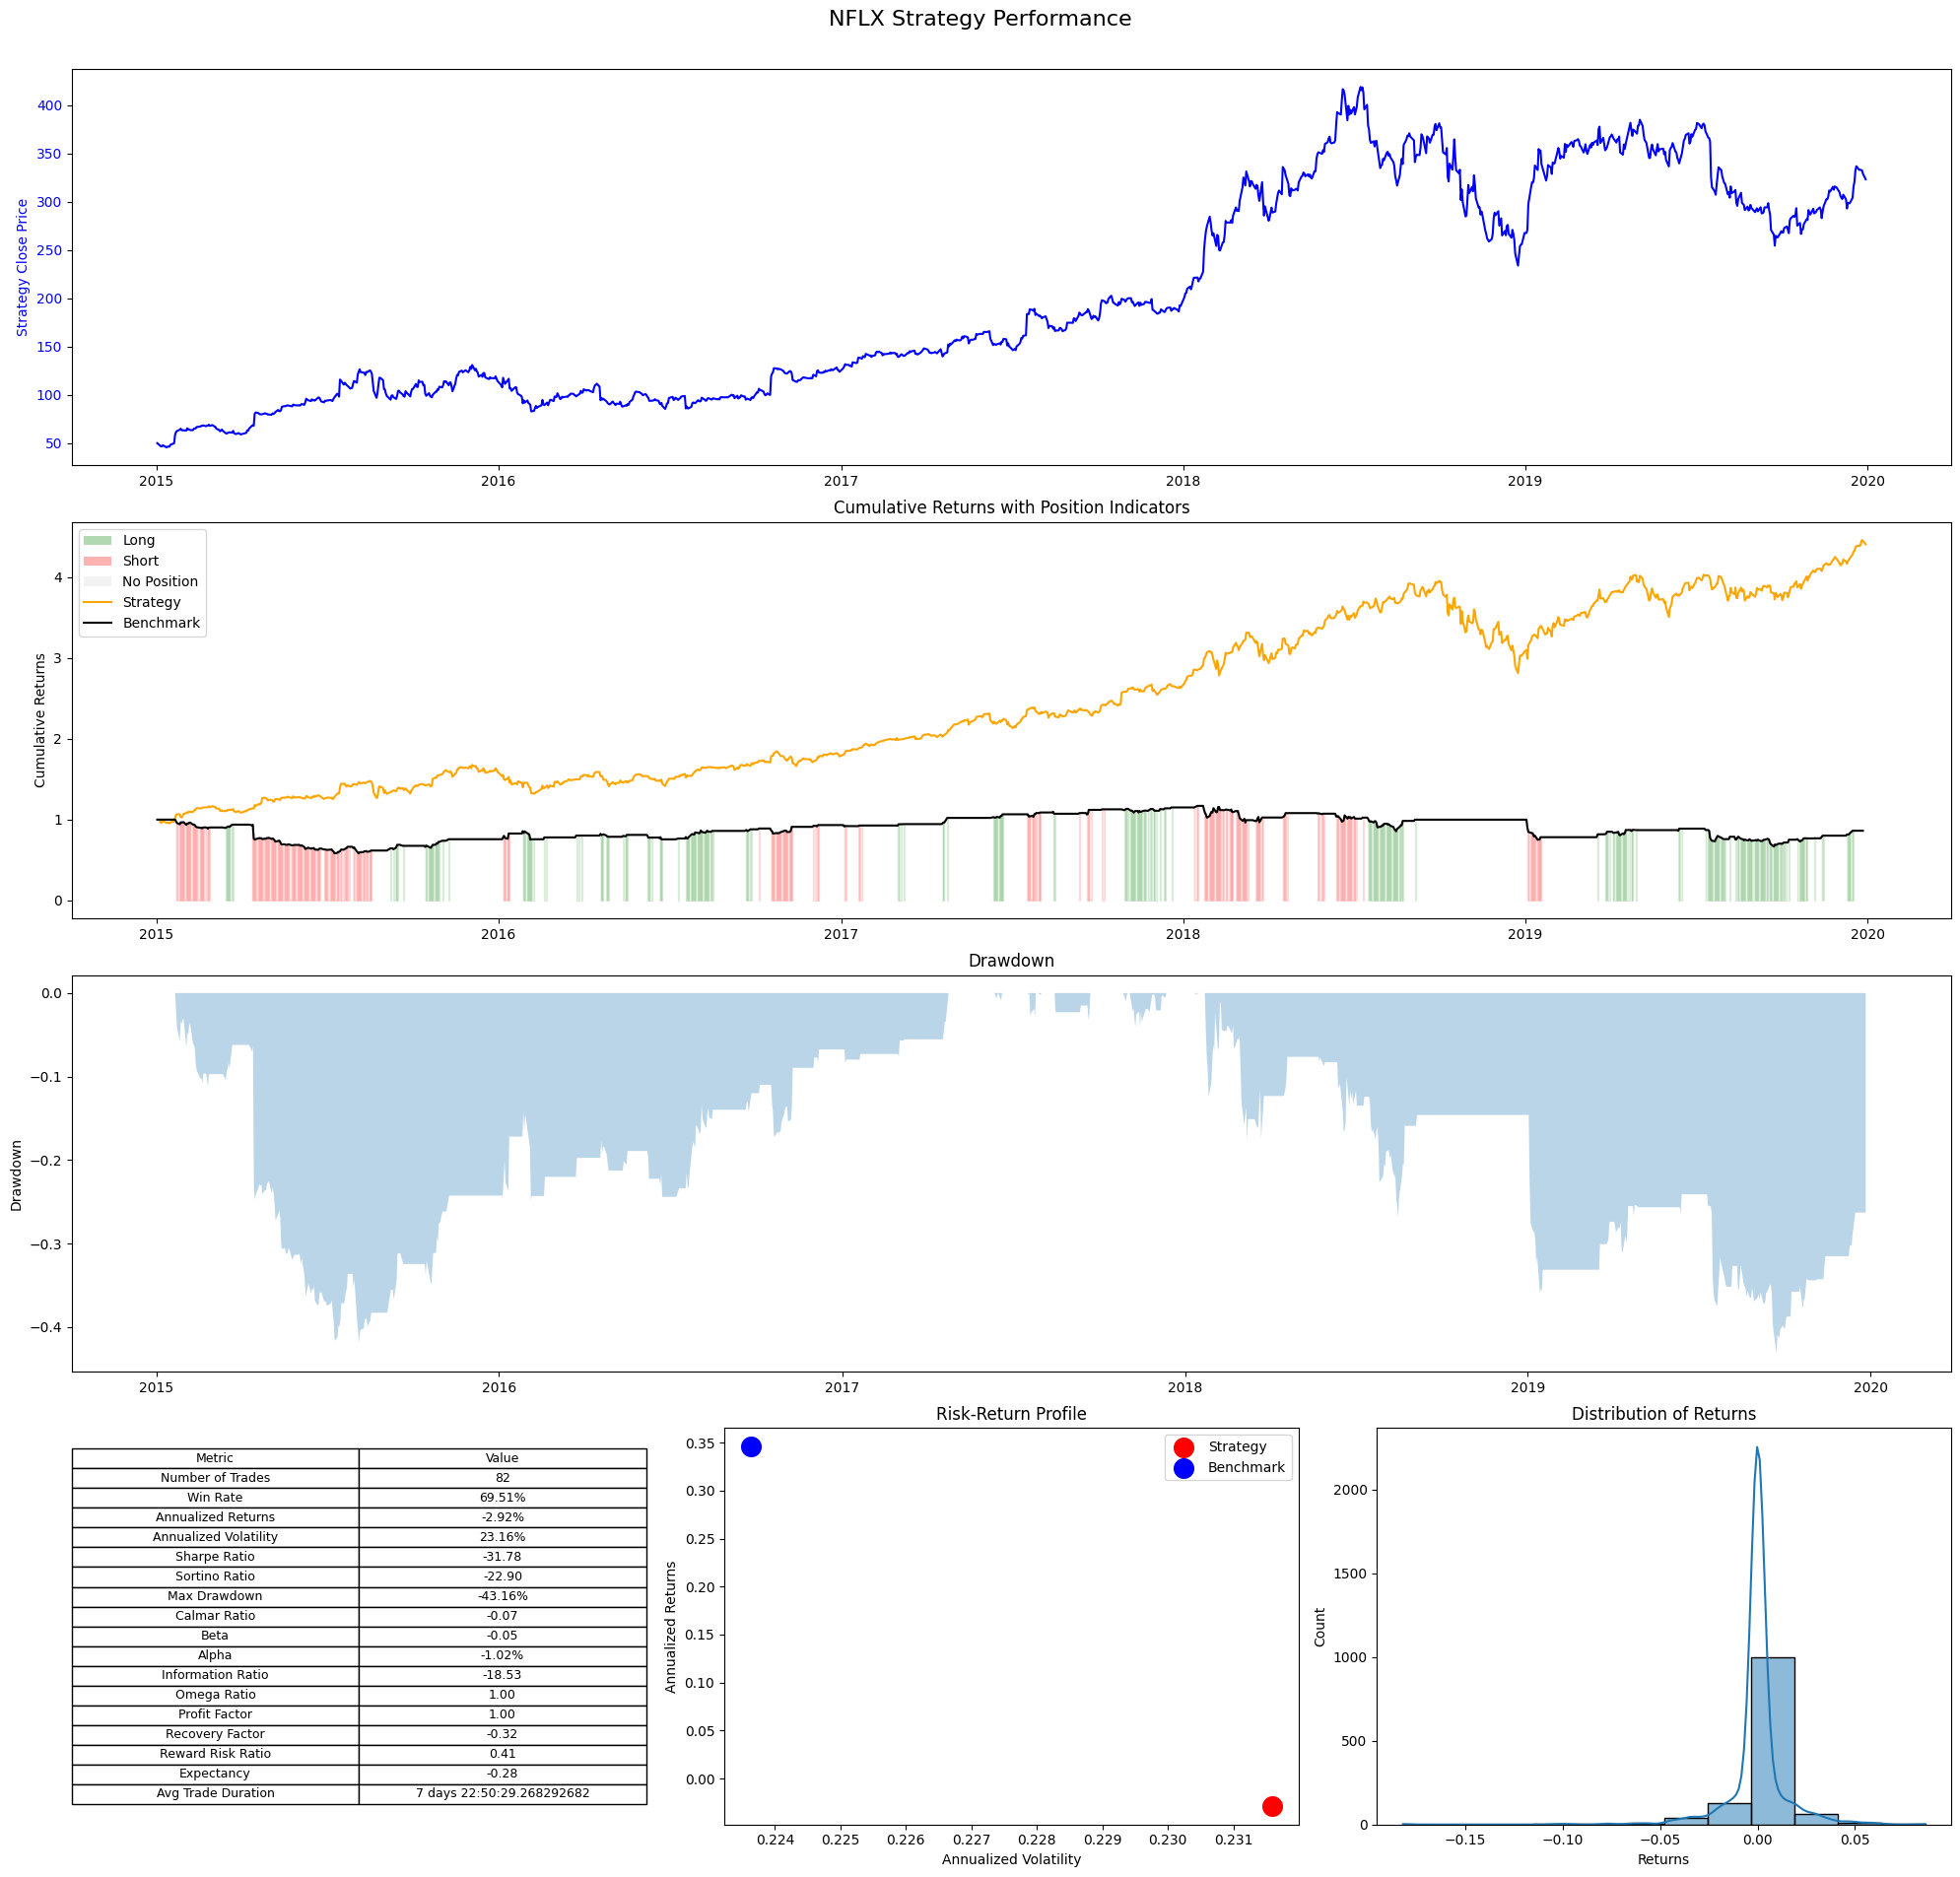

In [13]:
class YFinance_RSI_MCWEIGHTED_Strategy(YFinanceStrategy):
    def __init__(self, symbol: str, start_date: str, end_date: str, interval: str, params : dict, benchmark_symbol : str = "^GSPC", risk_free_rate : float = 0.0) -> None:
        super().__init__(symbol, start_date, end_date, interval, params, benchmark_symbol, risk_free_rate)
        # Set benchmark to Equal Weighted Portfolio of all 5 stocks.
        # Start with the first stock
        maang_stocks = ["MSFT", "AAPL", "AMZN", "NFLX", "GOOGL"]
        df_maang = prepare_data(symbol=maang_stocks[0], start_date=self.start_date, end_date=self.end_date, interval=self.interval)
        df_maang = df_maang.rename(columns={'returns_close': maang_stocks[0] + '_returns_close'})
        df_maang = df_maang[['Date', maang_stocks[0] + '_returns_close']]

        # Merge data for the remaining stocks
        for stock in maang_stocks[1:]:
            df_temp = prepare_data(symbol=stock, start_date=self.start_date, end_date=self.end_date, interval=self.interval)
            df_temp = df_temp.rename(columns={'returns_close': stock + '_returns_close'})
            df_temp = df_temp[['Date', stock + '_returns_close']]
            df_maang = pd.merge(df_maang, df_temp, on='Date', how='outer')

        # Calculate the mean returns
        df_maang['returns_close'] = df_maang[[stock + '_returns_close' for stock in maang_stocks]].mean(axis=1)
        self.data_benchmark = df_maang
    def strategy(self):
        """
        1. Generate MC Weighted RSI Signal.
        2. Calculate Symbol RSI.
        3. Generate Signal based on Symbol RSI.
        """
        self.data_strategy['rsi'] = RSIIndicator(close = self.data_strategy['Close'], window = self.params['rsi_window'],fillna=False).rsi()
        top_25_tech_stocks = [
            "AAPL",  # Apple
            "MSFT",  # Microsoft
            "GOOGL",  # Alphabet (Google)
            "AMZN",  # Amazon
            "NVDA",  # NVIDIA
            "META",  # Meta Platforms
            "TSLA",  # Tesla
            "TSM",   # Taiwan Semiconductor Manufacturing Company
            "AVGO",  # Broadcom
            "ORCL",  # Oracle
            "CSCO",  # Cisco Systems
            "ADBE",  # Adobe
            "CRM",   # Salesforce
            "ASML",  # ASML Holding
            "AMD",   # Advanced Micro Devices
            "ACN",   # Accenture
            "INTC",  # Intel
            "QCOM",  # Qualcomm
            "IBM",   # IBM
            "TXN",   # Texas Instruments
            # "PYPL",  # PayPal - Has missing values before 2015
            "INTU",  # Intuit
            "AMAT",  # Applied Materials
            "NOW",   # ServiceNow
            "ADP"    # Automatic Data Processing
        ]
        df_industry_rsi = generate_mcweighted_rsi(symbols=top_25_tech_stocks, start_date=self.start_date, end_date=self.end_date, interval=self.interval, rsi_window=self.params['rsi_window'])
        self.data_strategy = self.data_strategy.merge(right=df_industry_rsi, on = 'timestamp_utc', how = 'left')
        self.data_strategy['rsi_delta'] = self.data_strategy['rsi'] - self.data_strategy['industry_mcweighted_rsi']

        self.data_strategy['signal'] = 0
        self.data_strategy['signal'] = np.where(self.data_strategy['rsi_delta'] > self.params['upper_limit'], -1, np.where(self.data_strategy['rsi_delta'] < -self.params['lower_limit'], 1, 0))

rsi_mcweighted_strategy_1 = YFinance_RSI_MCWEIGHTED_Strategy(
    symbol="NFLX",
    start_date = '2015-01-01',
    end_date = '2019-12-31',
    interval = '1d',
    params = {'rsi_window' : 14, 'upper_limit' : 10, 'lower_limit' : 10},
    benchmark_symbol='NFLX',
    risk_free_rate=0.0
)
rsi_mcweighted_strategy_1.strategy()
rsi_mcweighted_strategy_1.calculate_strategy_performance()
rsi_mcweighted_strategy_1.plot_performance()

<Axes: xlabel='Date'>

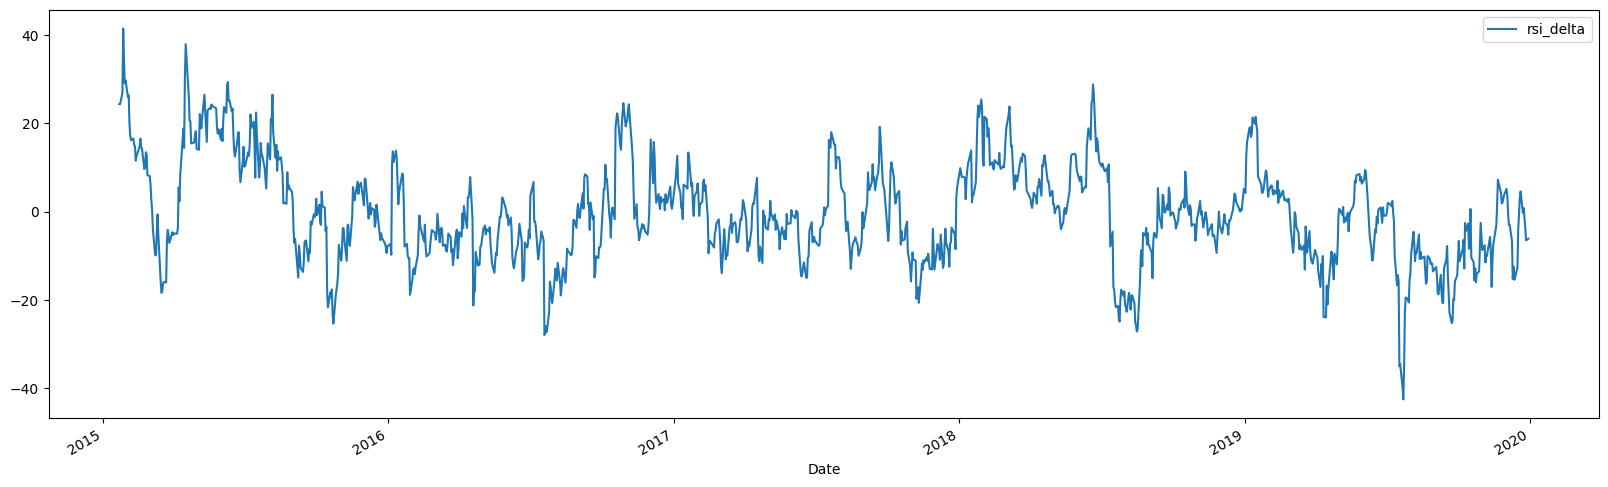

In [14]:
rsi_mcweighted_strategy_1.data_strategy.plot(
    x='Date',
    y='rsi_delta',
    figsize=(20,6)
)

# Portfolio Optimization

In [15]:
# rsi_mcweighted_list_strategies = []

# for s in maang_stocks:
#     strategy = YFinance_RSI_MCWEIGHTED_Strategy(
#         symbol=s,
#         start_date = '2015-01-01',
#         end_date = '2019-12-31',
#         interval = '1d',
#         params = {'rsi_window' : 28, 'upper_limit' : 15, 'lower_limit' : 2.5},
#         benchmark_symbol=s,
#         risk_free_rate=0.0
#     )
#     strategy.strategy()
#     strategy.calculate_strategy_performance()
#     strategy.plot_performance()
#     rsi_mcweighted_list_strategies.append(strategy)

# portfolio = YFinancePortfolio(list_strategies)
# portfolio.calculate_portfolio_performance()
# print(portfolio.portfolio_performance)

In [16]:
from itertools import product

rsi_window = [7, 14, 21, 28]
limits = [2.5, 5, 10, 12.5, 15, 17.5, 20]

optimization_parameters = product(rsi_window, limits, limits)

portfolio_optimization = []

for wind, ul, ll in optimization_parameters:
    temp_list_strategies = []
    for s in maang_stocks:
        strategy = YFinance_RSI_MCWEIGHTED_Strategy(
            symbol=s,
            start_date = '2015-01-01',
            end_date = '2019-12-31',
            interval = '1d',
            params = {'rsi_window' : wind, 'upper_limit' : ul, 'lower_limit' : ll},
            benchmark_symbol=s,
            risk_free_rate=0.0
        )
        strategy.strategy()
        strategy.calculate_strategy_performance()
        temp_list_strategies.append(strategy)
    temp_portfolio = YFinancePortfolio(temp_list_strategies)
    temp_portfolio.calculate_portfolio_performance()
    temp_portfolio.portfolio_performance.update({
        'rsi_window' : wind,
        'upper_limit' : ul,
        'lower_limit' : ll
    })
    portfolio_optimization.append(temp_portfolio.portfolio_performance)
    print(f"""Testing for rsi:{rsi_window}, ul: {ul}, ll: {ll}""")
# portfolio_optimization

Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 2.5
Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 5
Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 10
Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 12.5
Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 15
Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 17.5
Testing for rsi:[7, 14, 21, 28], ul: 2.5, ll: 20
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 2.5
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 5
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 10
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 12.5
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 15
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 17.5
Testing for rsi:[7, 14, 21, 28], ul: 5, ll: 20
Testing for rsi:[7, 14, 21, 28], ul: 10, ll: 2.5
Testing for rsi:[7, 14, 21, 28], ul: 10, ll: 5
Testing for rsi:[7, 14, 21, 28], ul: 10, ll: 10
Testing for rsi:[7, 14, 21, 28], ul: 10, ll: 12.5
Testing for rsi:[7, 14, 21, 28], ul: 10, ll: 15
Testing for rsi:[7, 14, 21, 28], ul: 10, ll: 17.5
Testing for rsi:[7, 14, 21, 

# Performance Analysis

In [17]:
df_portfolio_optimization = pd.DataFrame(portfolio_optimization).sort_values('portfolio_sharpe_ratio', ascending=False)
df_portfolio_optimization

number_strategies  portfolio_annualized_return  \
182                  5                     0.102699   
189                  5                     0.101212   
175                  5                     0.101666   
140                  5                     0.099425   
133                  5                     0.093507   
..                 ...                          ...   
104                  5                    -0.108452   
152                  5                    -0.108008   
55                   5                    -0.116603   
54                   5                    -0.117346   
53                   5                    -0.119957   

     portfolio_annualized_volatility  portfolio_sharpe_ratio  \
182                         0.093595                1.097271   
189                         0.093252                1.085365   
175                         0.093909                1.082598   
140                         0.092996                1.069136   
133                         0.093075                1.004638   
..                               ...                     ...   
104                         0.105510               -1.027889   
152                         0.104207               -1.036483   
55                          0.108654               -1.073156   
54                          0.108292               -1.083607   
53                          0.108132               -1.109354   

     portfolio_sortino_ratio  portfolio_max_drawdown  portfolio_calmar_ratio  \
182                 1.052205                0.103092                0.996190   
189                 1.033982                0.103092                0.981767   
175                 1.041320                0.103092                0.986168   
140                 1.045076                0.095467                1.041465   
133                 0.982434                0.095467                0.979469   
..                       ...                     ...                     ...   
104                -0.958798                0.435740               -0.248892   
152                -0.962219                0.457913               -0.235871   
55                 -0.981048                0.467110               -0.249626   
54                 -0.988967                0.465696               -0.251981   
53                 -1.010463                0.473519               -0.253330   

     benchmark_annualized_return  benchmark_annualized_volatility  \
182                     0.349468                         0.223669   
189                     0.349468                         0.223669   
175                     0.349468                         0.223669   
140                     0.349468                         0.223669   
133                     0.349468                         0.223669   
..                           ...                              ...   
104                     0.349468                         0.223669   
152                     0.349468                         0.223669   
55                      0.349468                         0.223669   
54                      0.349468                         0.223669   
53                      0.349468                         0.223669   

     benchmark_sharpe_ratio  ...      beta     alpha  annualized_treynor  \
182                1.562432  ... -0.007962  0.105481          -12.898192   
189                1.562432  ... -0.008766  0.104275          -11.546506   
175                1.562432  ... -0.009861  0.105112          -10.310010   
140                1.562432  ... -0.003430  0.100624          -28.988692   
133                1.562432  ... -0.004965  0.095242          -18.831396   
..                      ...  ...       ...       ...                 ...   
104                1.562432  ... -0.014333 -0.103443            7.566595   
152                1.562432  ... -0.017023 -0.102060            6.344997   
55                 1.562432  ... -0.010256 -0.113019           11.369129   
54                 1.5624

In [18]:
df_portfolio_optimization = pd.DataFrame(portfolio_optimization).sort_values('portfolio_annualized_return', ascending=False)
df_portfolio_optimization

number_strategies  portfolio_annualized_return  \
182                  5                     0.102699   
175                  5                     0.101666   
189                  5                     0.101212   
140                  5                     0.099425   
133                  5                     0.093507   
..                 ...                          ...   
152                  5                    -0.108008   
104                  5                    -0.108452   
55                   5                    -0.116603   
54                   5                    -0.117346   
53                   5                    -0.119957   

     portfolio_annualized_volatility  portfolio_sharpe_ratio  \
182                         0.093595                1.097271   
175                         0.093909                1.082598   
189                         0.093252                1.085365   
140                         0.092996                1.069136   
133                         0.093075                1.004638   
..                               ...                     ...   
152                         0.104207               -1.036483   
104                         0.105510               -1.027889   
55                          0.108654               -1.073156   
54                          0.108292               -1.083607   
53                          0.108132               -1.109354   

     portfolio_sortino_ratio  portfolio_max_drawdown  portfolio_calmar_ratio  \
182                 1.052205                0.103092                0.996190   
175                 1.041320                0.103092                0.986168   
189                 1.033982                0.103092                0.981767   
140                 1.045076                0.095467                1.041465   
133                 0.982434                0.095467                0.979469   
..                       ...                     ...                     ...   
152                -0.962219                0.457913               -0.235871   
104                -0.958798                0.435740               -0.248892   
55                 -0.981048                0.467110               -0.249626   
54                 -0.988967                0.465696               -0.251981   
53                 -1.010463                0.473519               -0.253330   

     benchmark_annualized_return  benchmark_annualized_volatility  \
182                     0.349468                         0.223669   
175                     0.349468                         0.223669   
189                     0.349468                         0.223669   
140                     0.349468                         0.223669   
133                     0.349468                         0.223669   
..                           ...                              ...   
152                     0.349468                         0.223669   
104                     0.349468                         0.223669   
55                      0.349468                         0.223669   
54                      0.349468                         0.223669   
53                      0.349468                         0.223669   

     benchmark_sharpe_ratio  ...      beta     alpha  annualized_treynor  \
182                1.562432  ... -0.007962  0.105481          -12.898192   
175                1.562432  ... -0.009861  0.105112          -10.310010   
189                1.562432  ... -0.008766  0.104275          -11.546506   
140                1.562432  ... -0.003430  0.100624          -28.988692   
133                1.562432  ... -0.004965  0.095242          -18.831396   
..                      ...  ...       ...       ...                 ...   
152                1.562432  ... -0.017023 -0.102060            6.344997   
104                1.562432  ... -0.014333 -0.103443            7.566595   
55                 1.562432  ... -0.010256 -0.113019           11.369129   
54                 1.5624

## Selecting the best model - Highest Annualized Return and Highest Sharpe Ratio

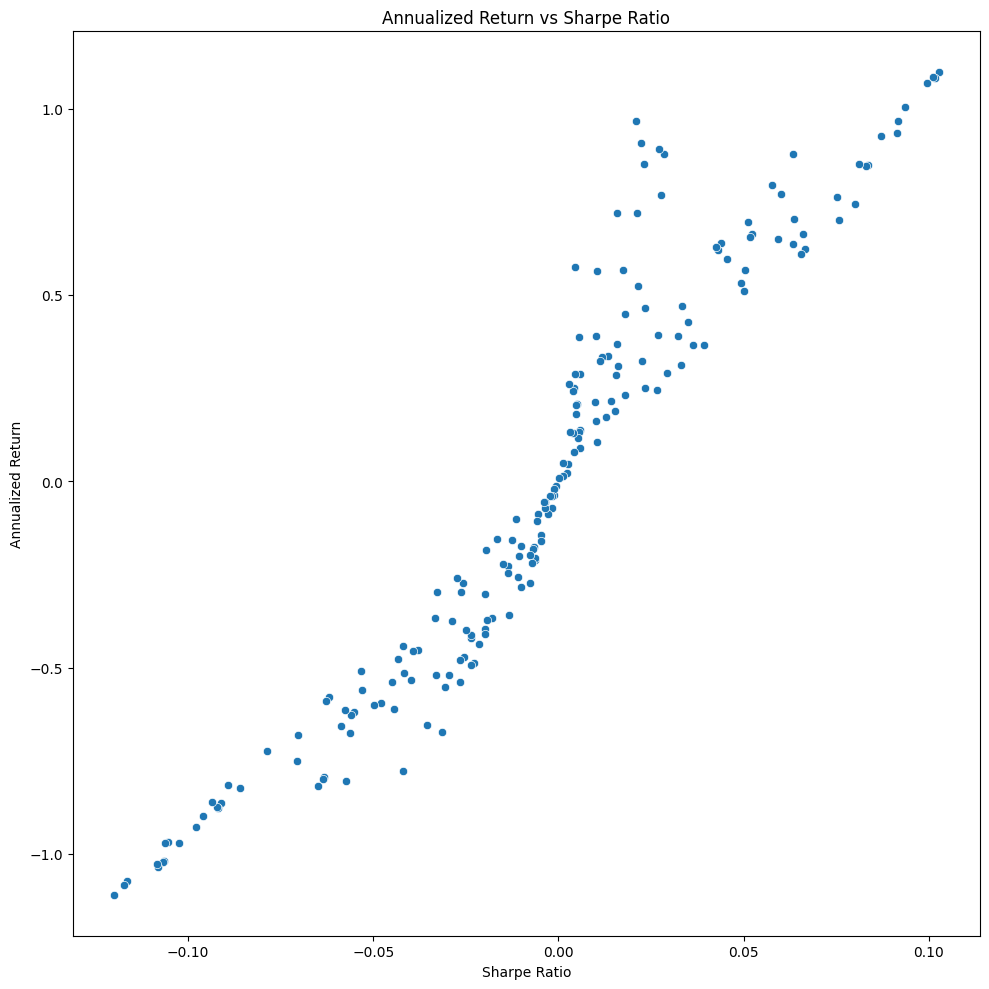

In [19]:
# Create the scatter plot
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_portfolio_optimization, x='portfolio_annualized_return', y='portfolio_sharpe_ratio')

# Set labels and title
plt.xlabel('Sharpe Ratio')
plt.ylabel('Annualized Return')
plt.title('Annualized Return vs Sharpe Ratio')

# Find the furthermost point (assuming it's the point with the highest Euclidean distance from origin)
furthest_point = df_portfolio_optimization.iloc[((df_portfolio_optimization['portfolio_sharpe_ratio']**2 + df_portfolio_optimization['portfolio_annualized_return']**2)**0.5).idxmax()]

# Annotate the furthest point
plt.annotate(f"RSI Window: {furthest_point['rsi_window']}\n"
             f"Upper Limit: {furthest_point['upper_limit']}\n"
             f"Lower Limit: {furthest_point['lower_limit']}",
             (furthest_point['portfolio_sharpe_ratio'], furthest_point['portfolio_annualized_return']),
             xytext=(5, 5), textcoords='offset points',
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.5),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))

plt.tight_layout()
plt.show()

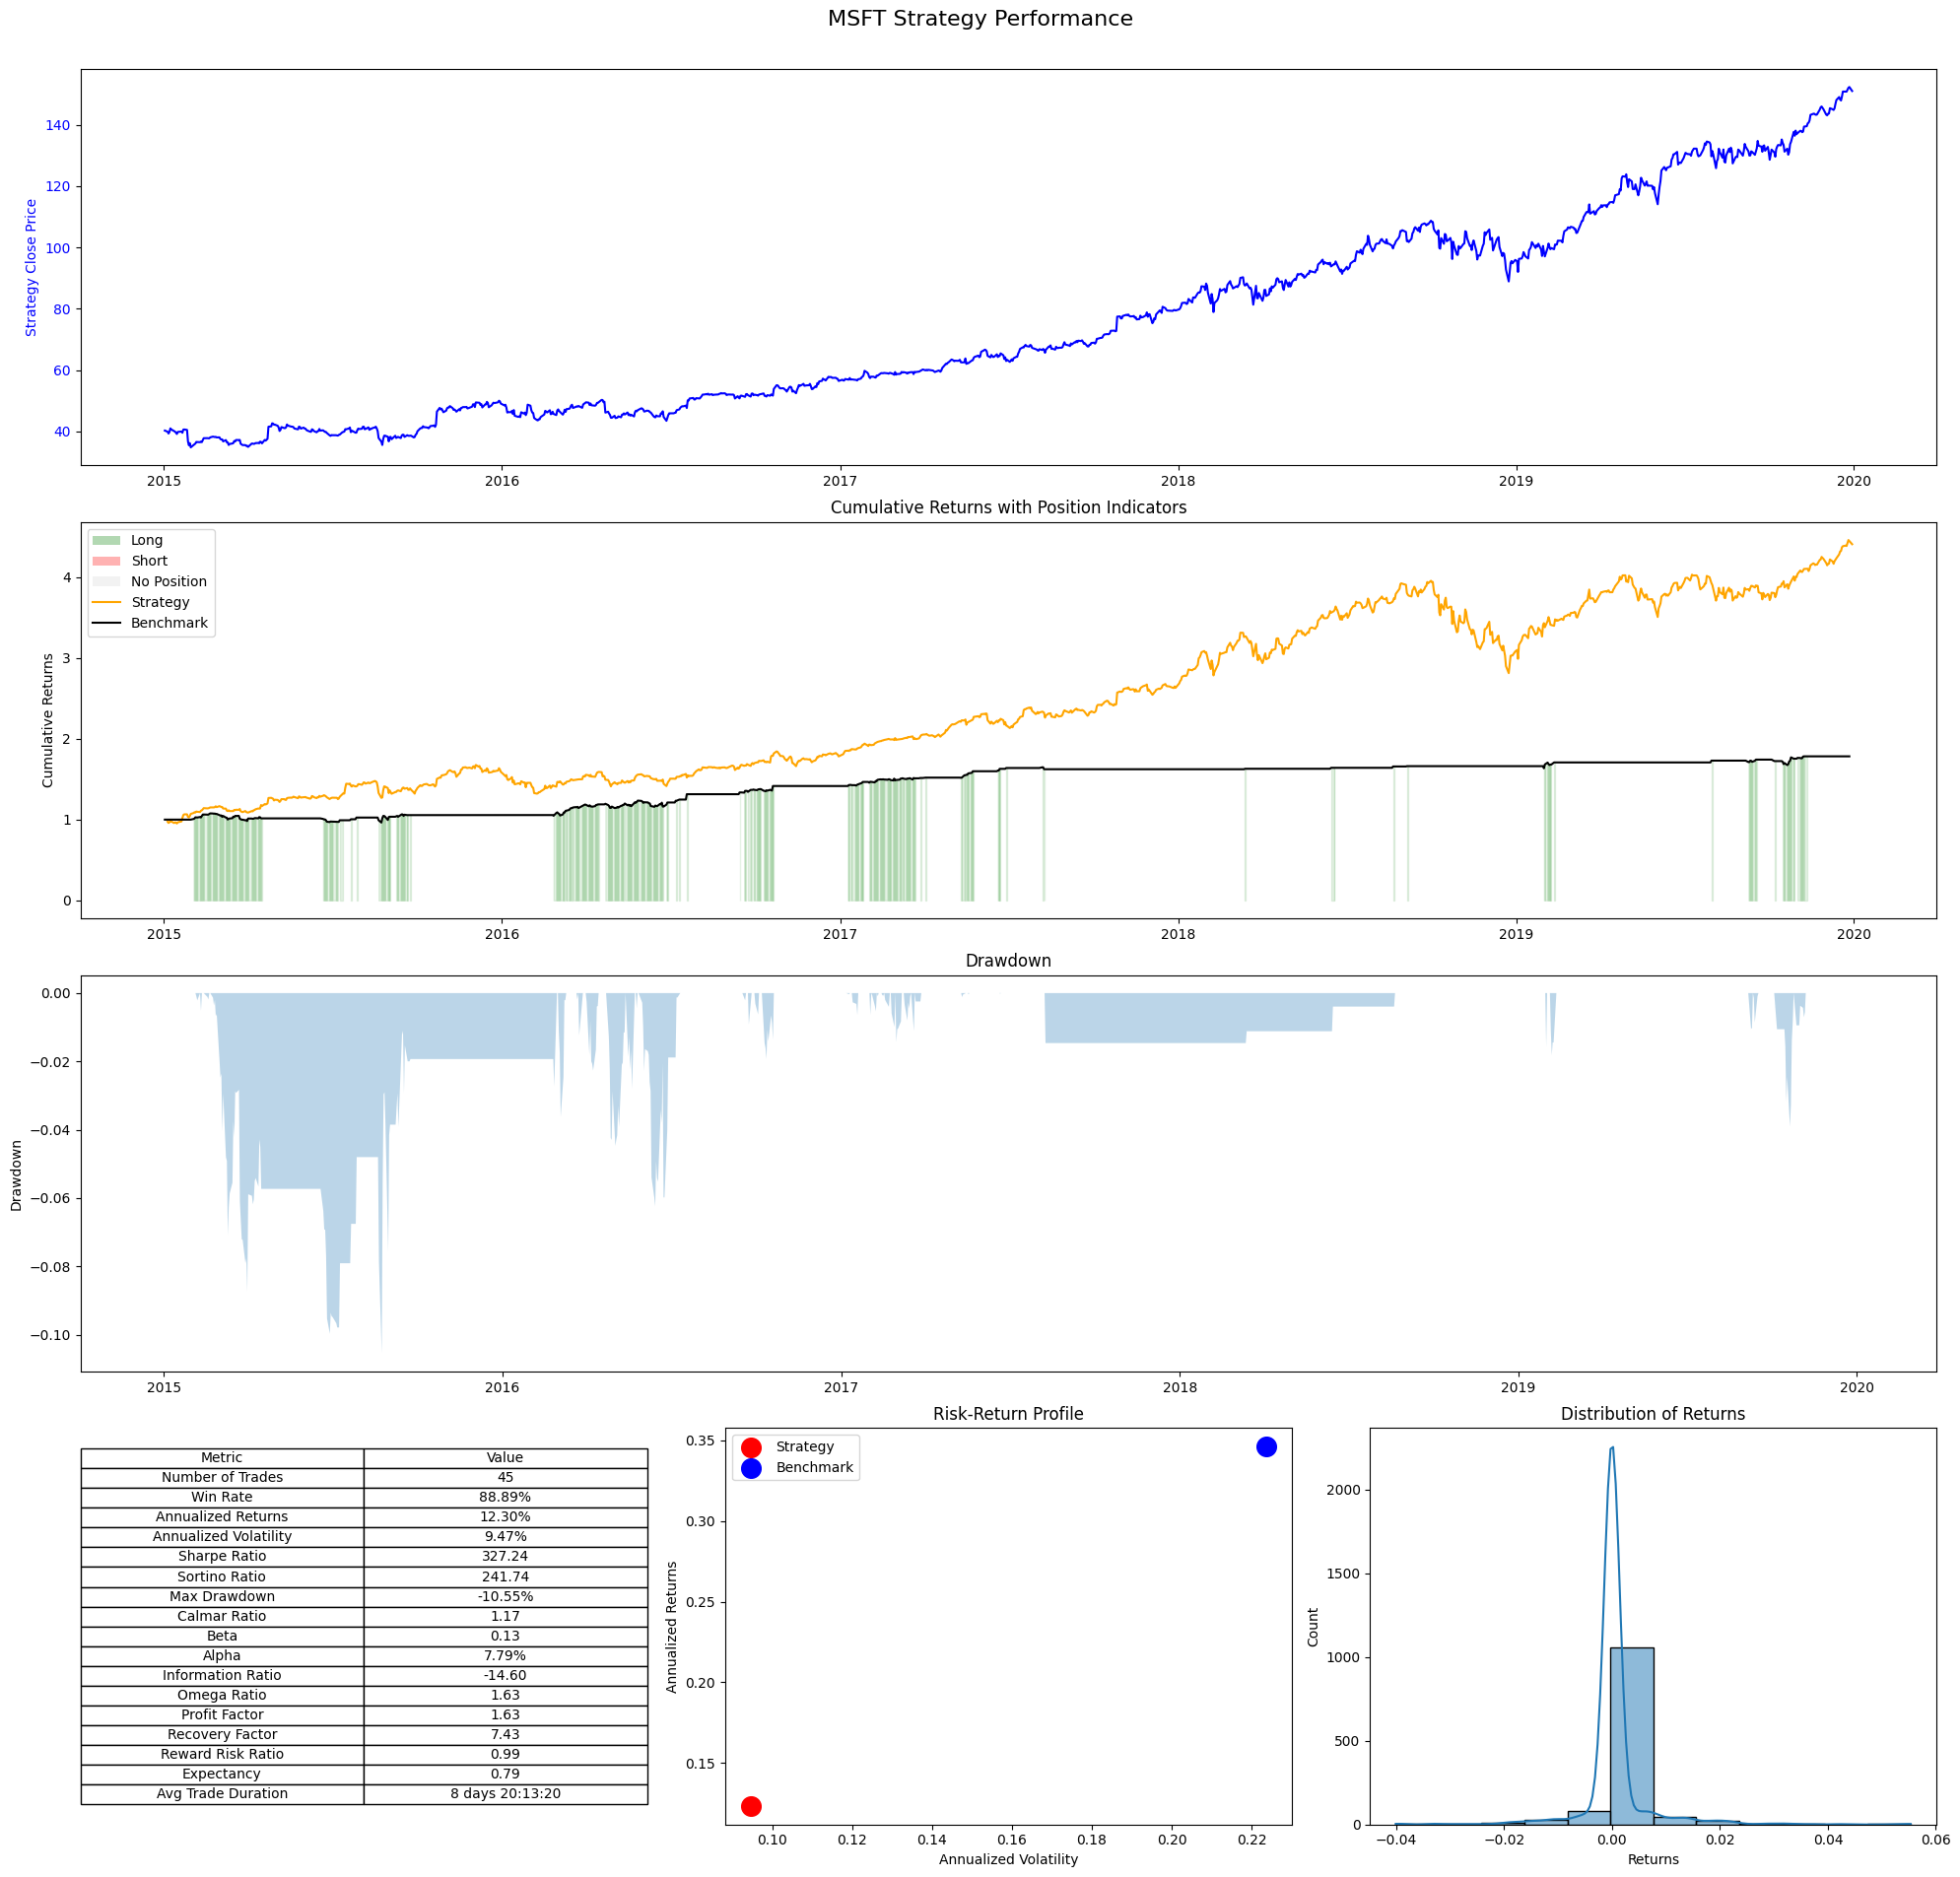

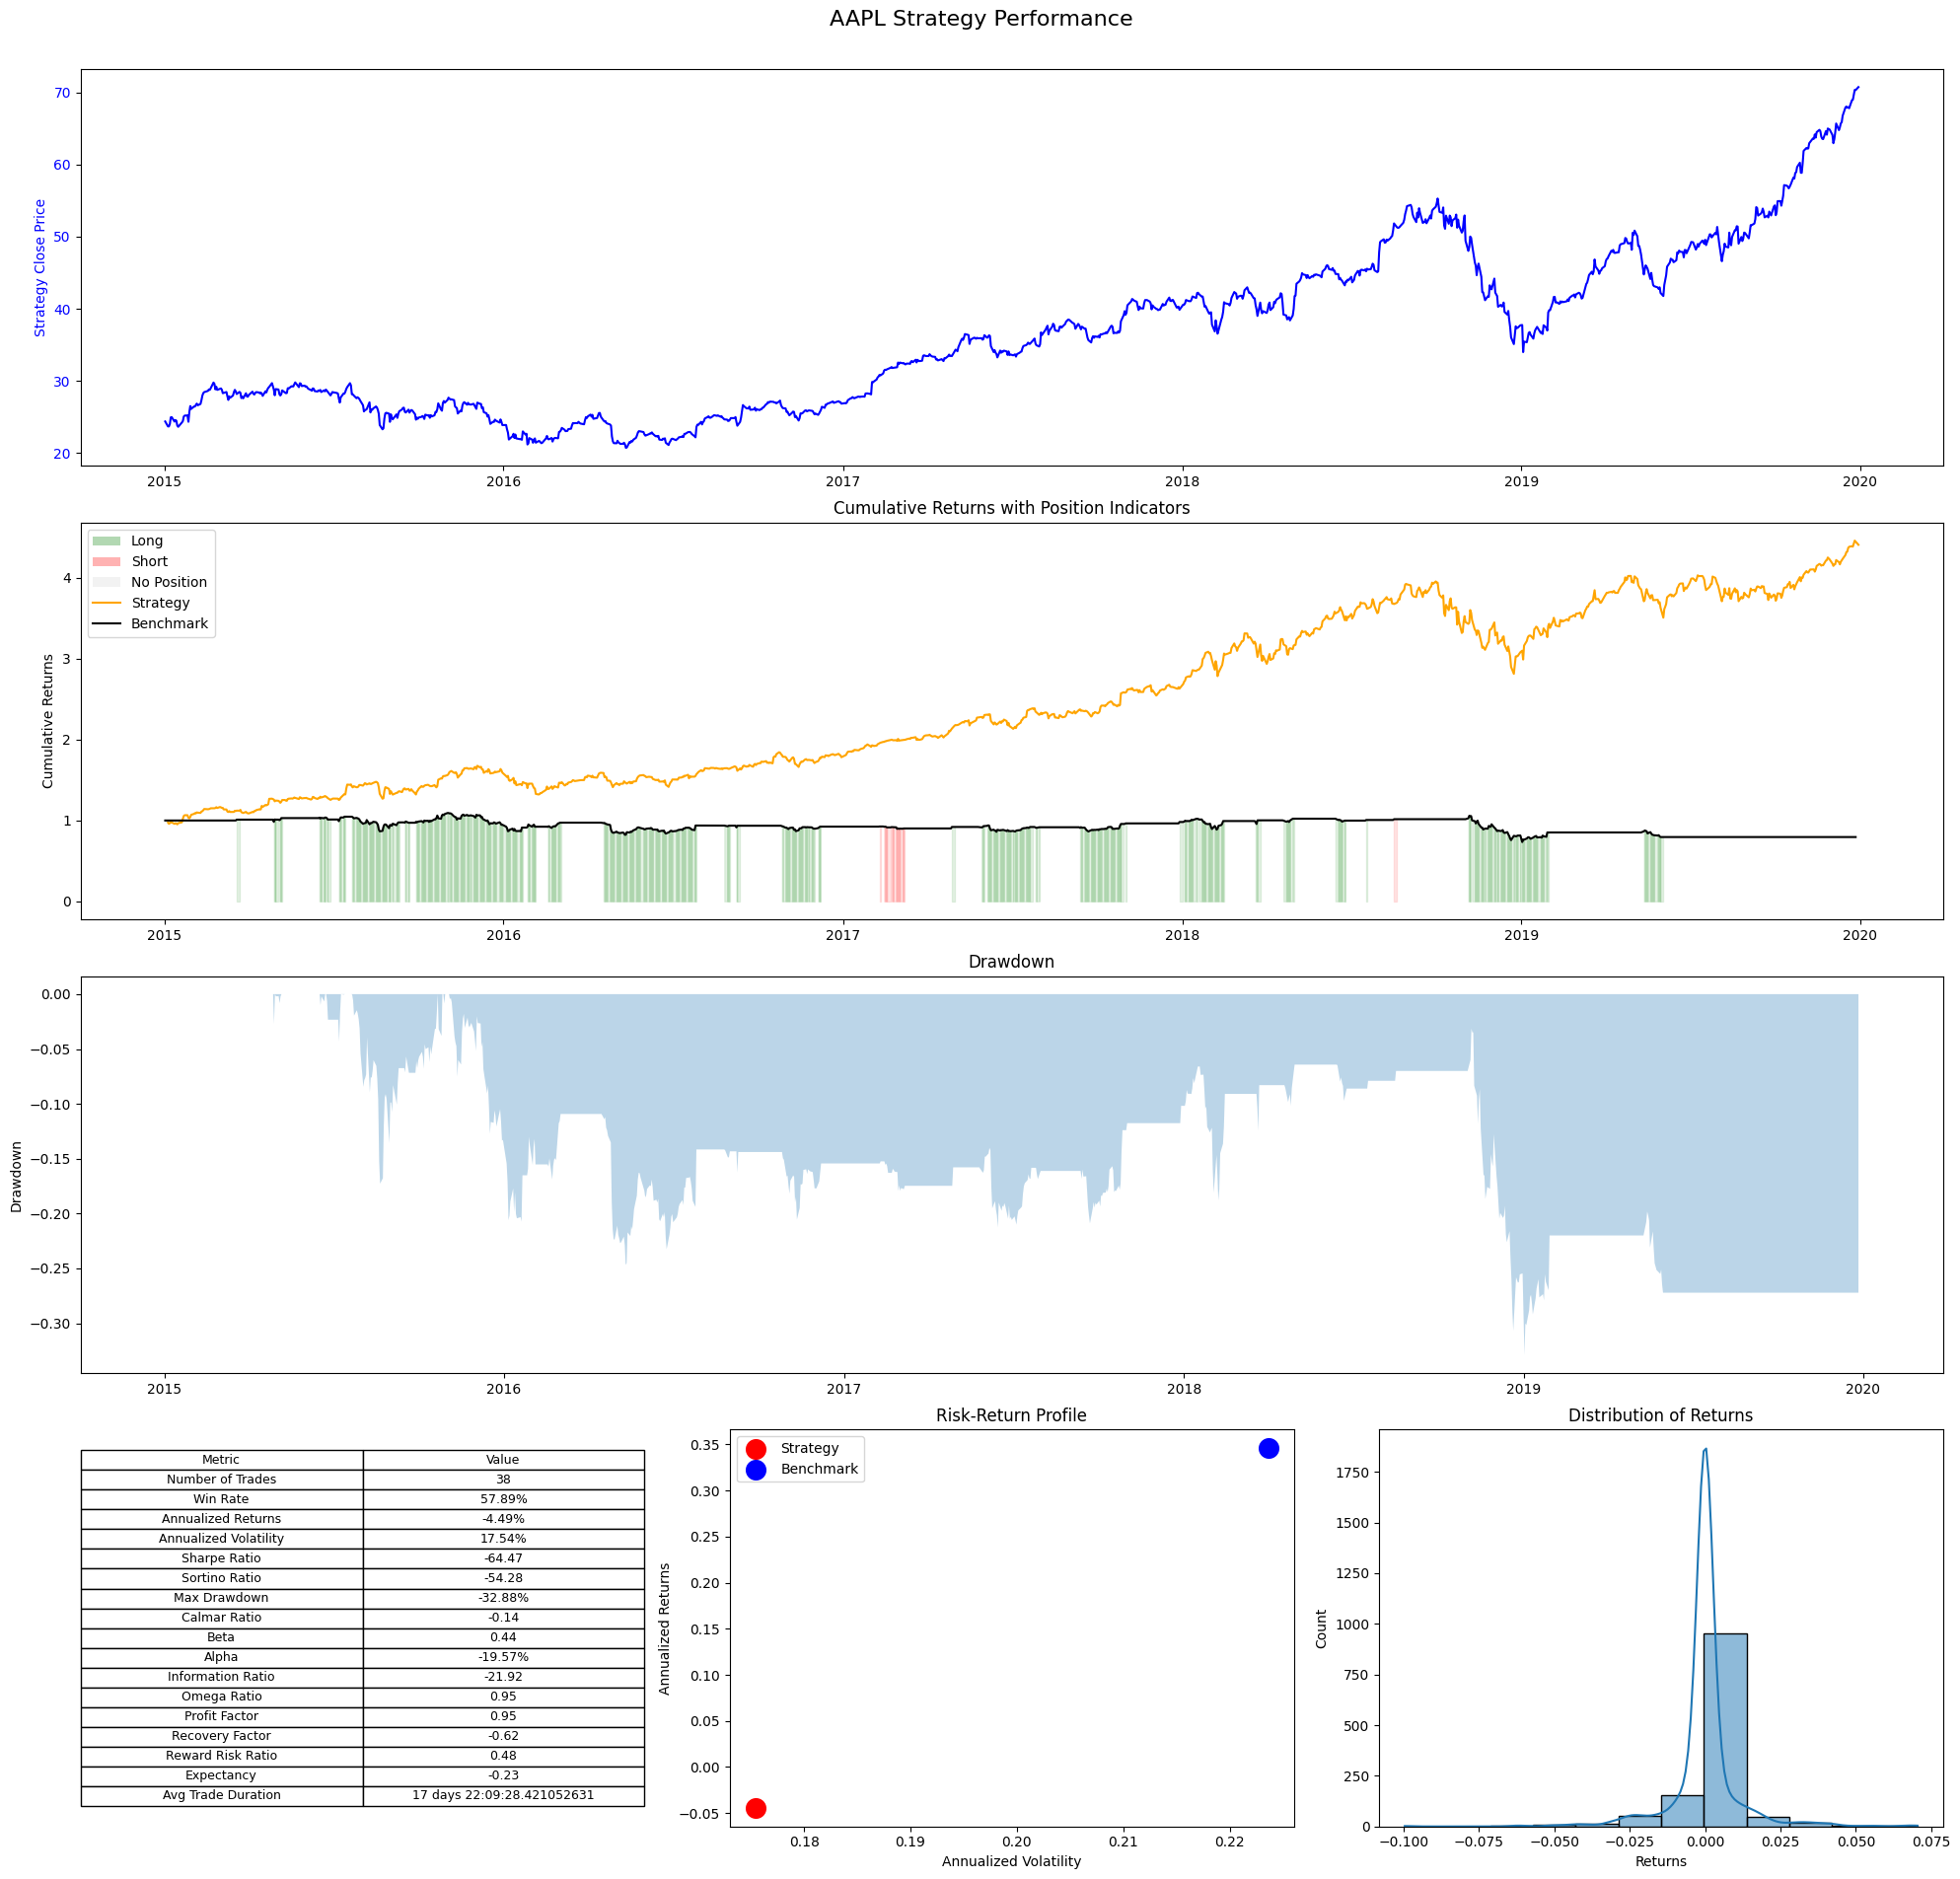

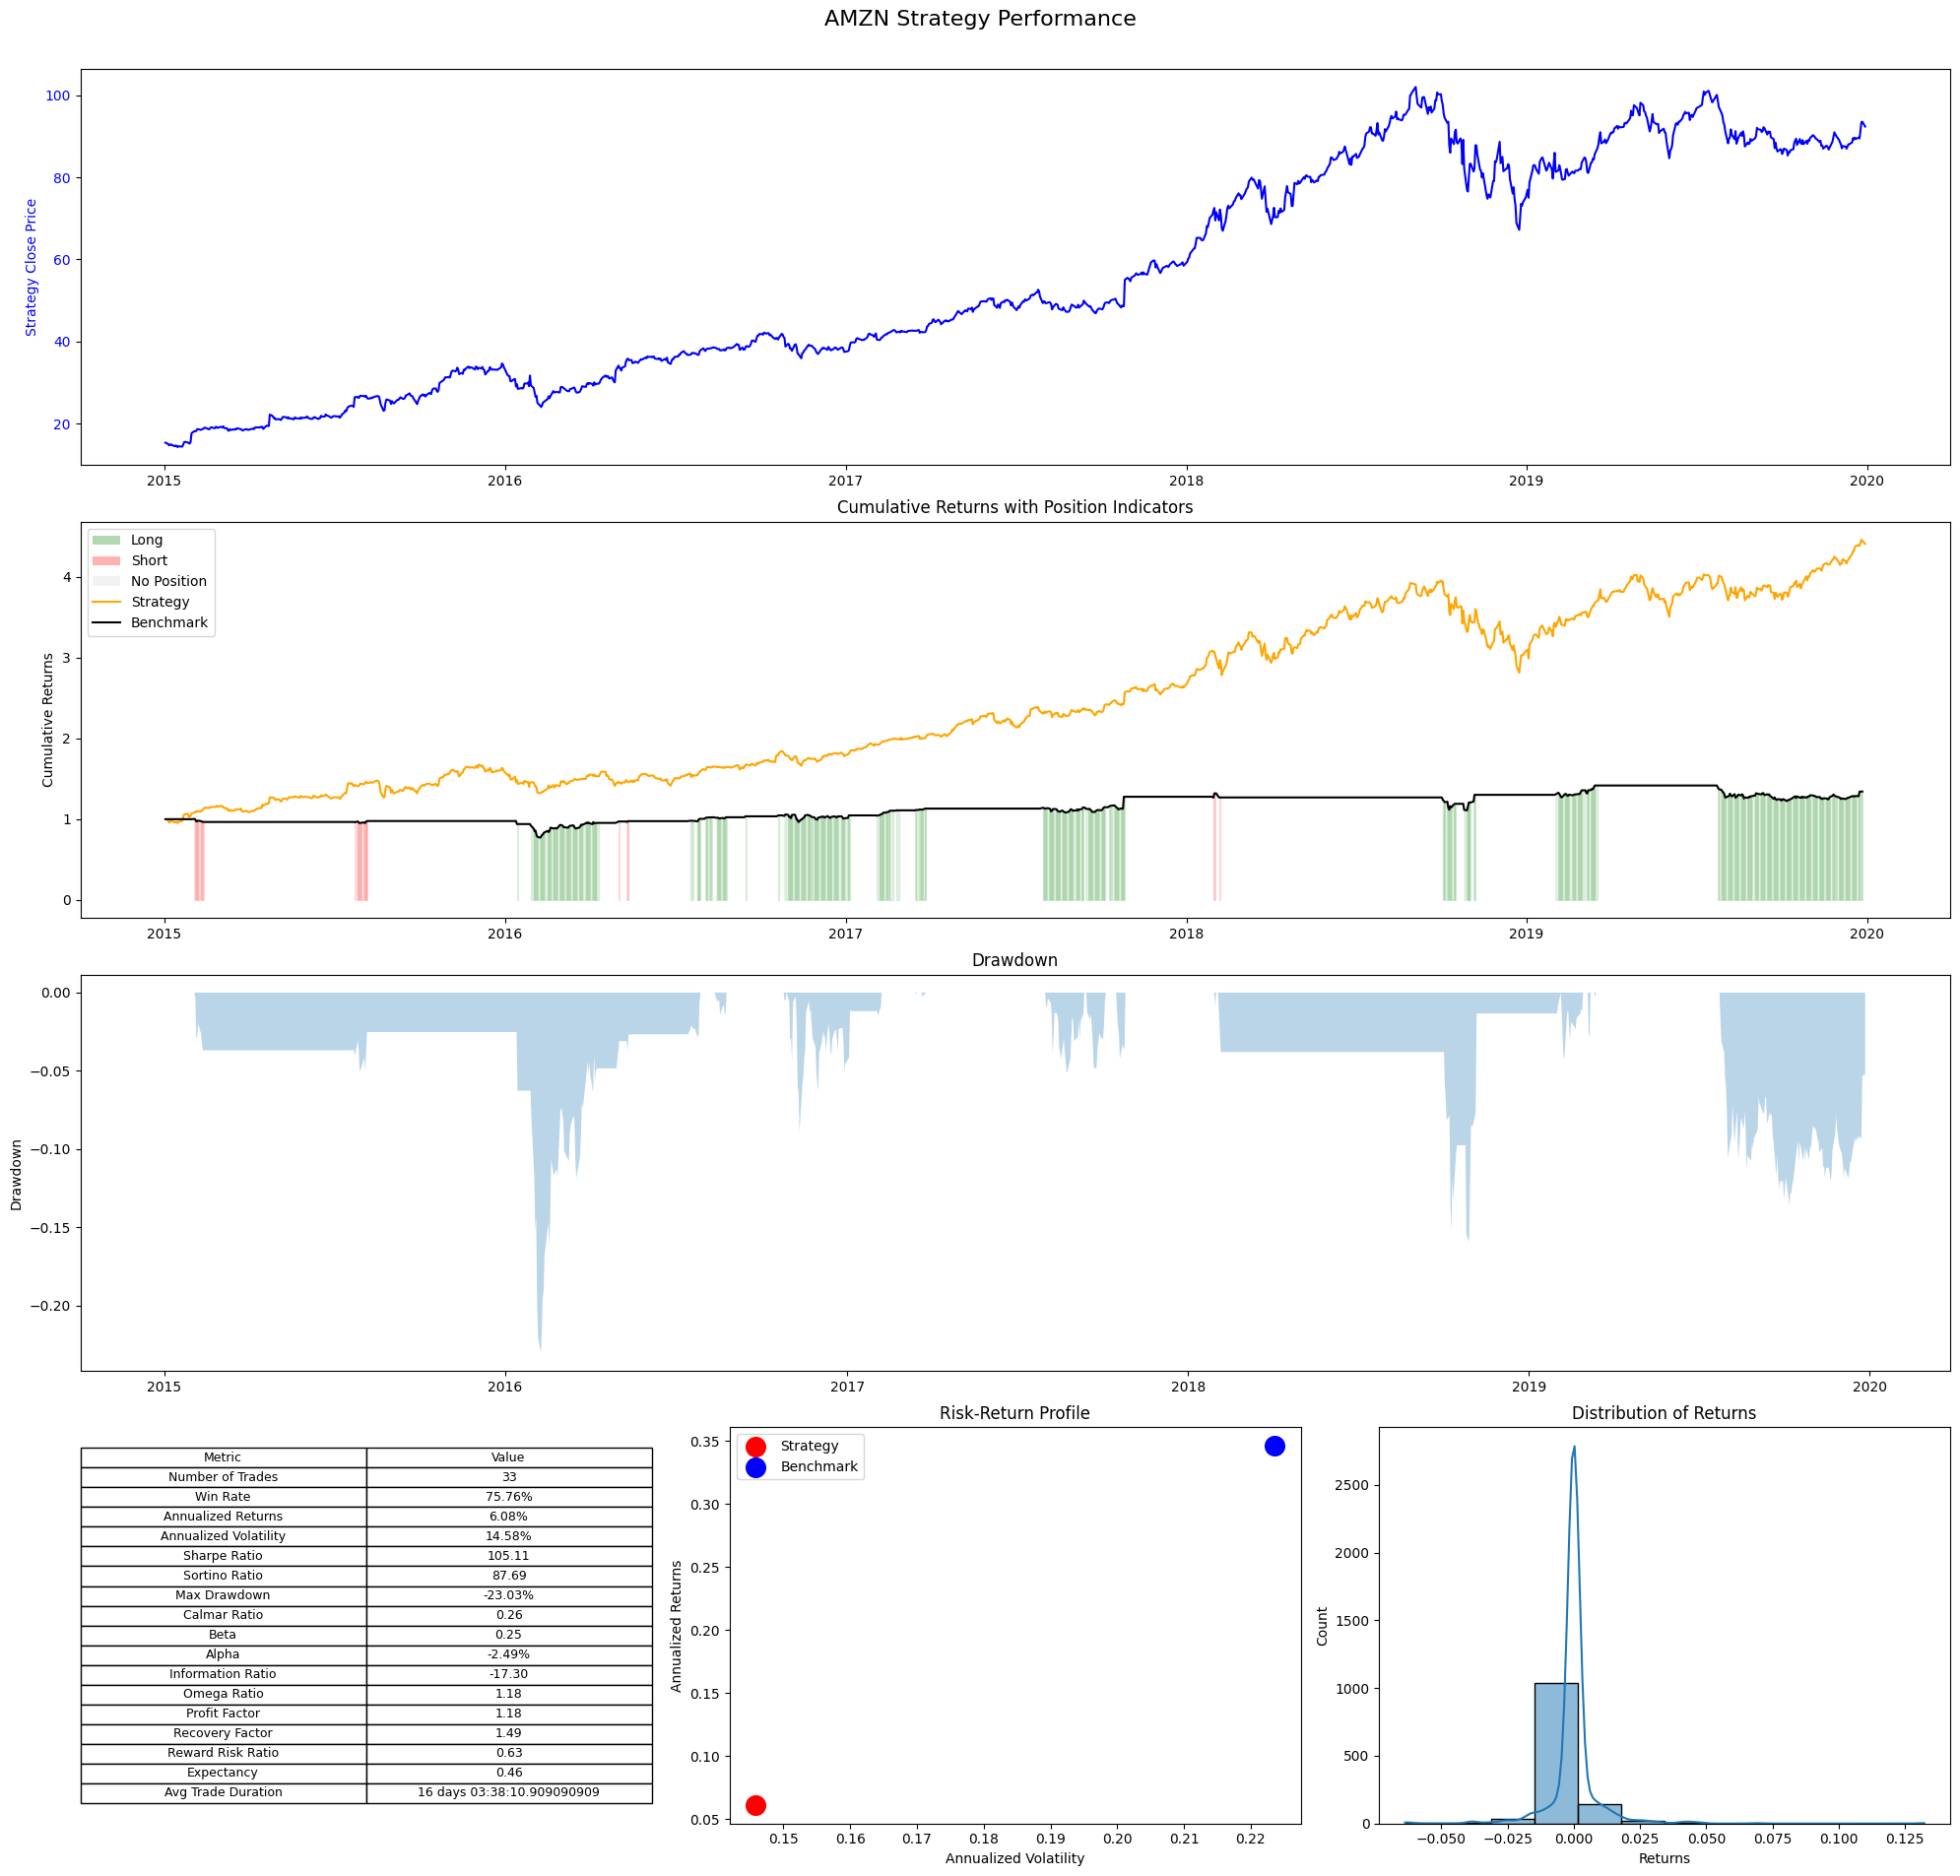

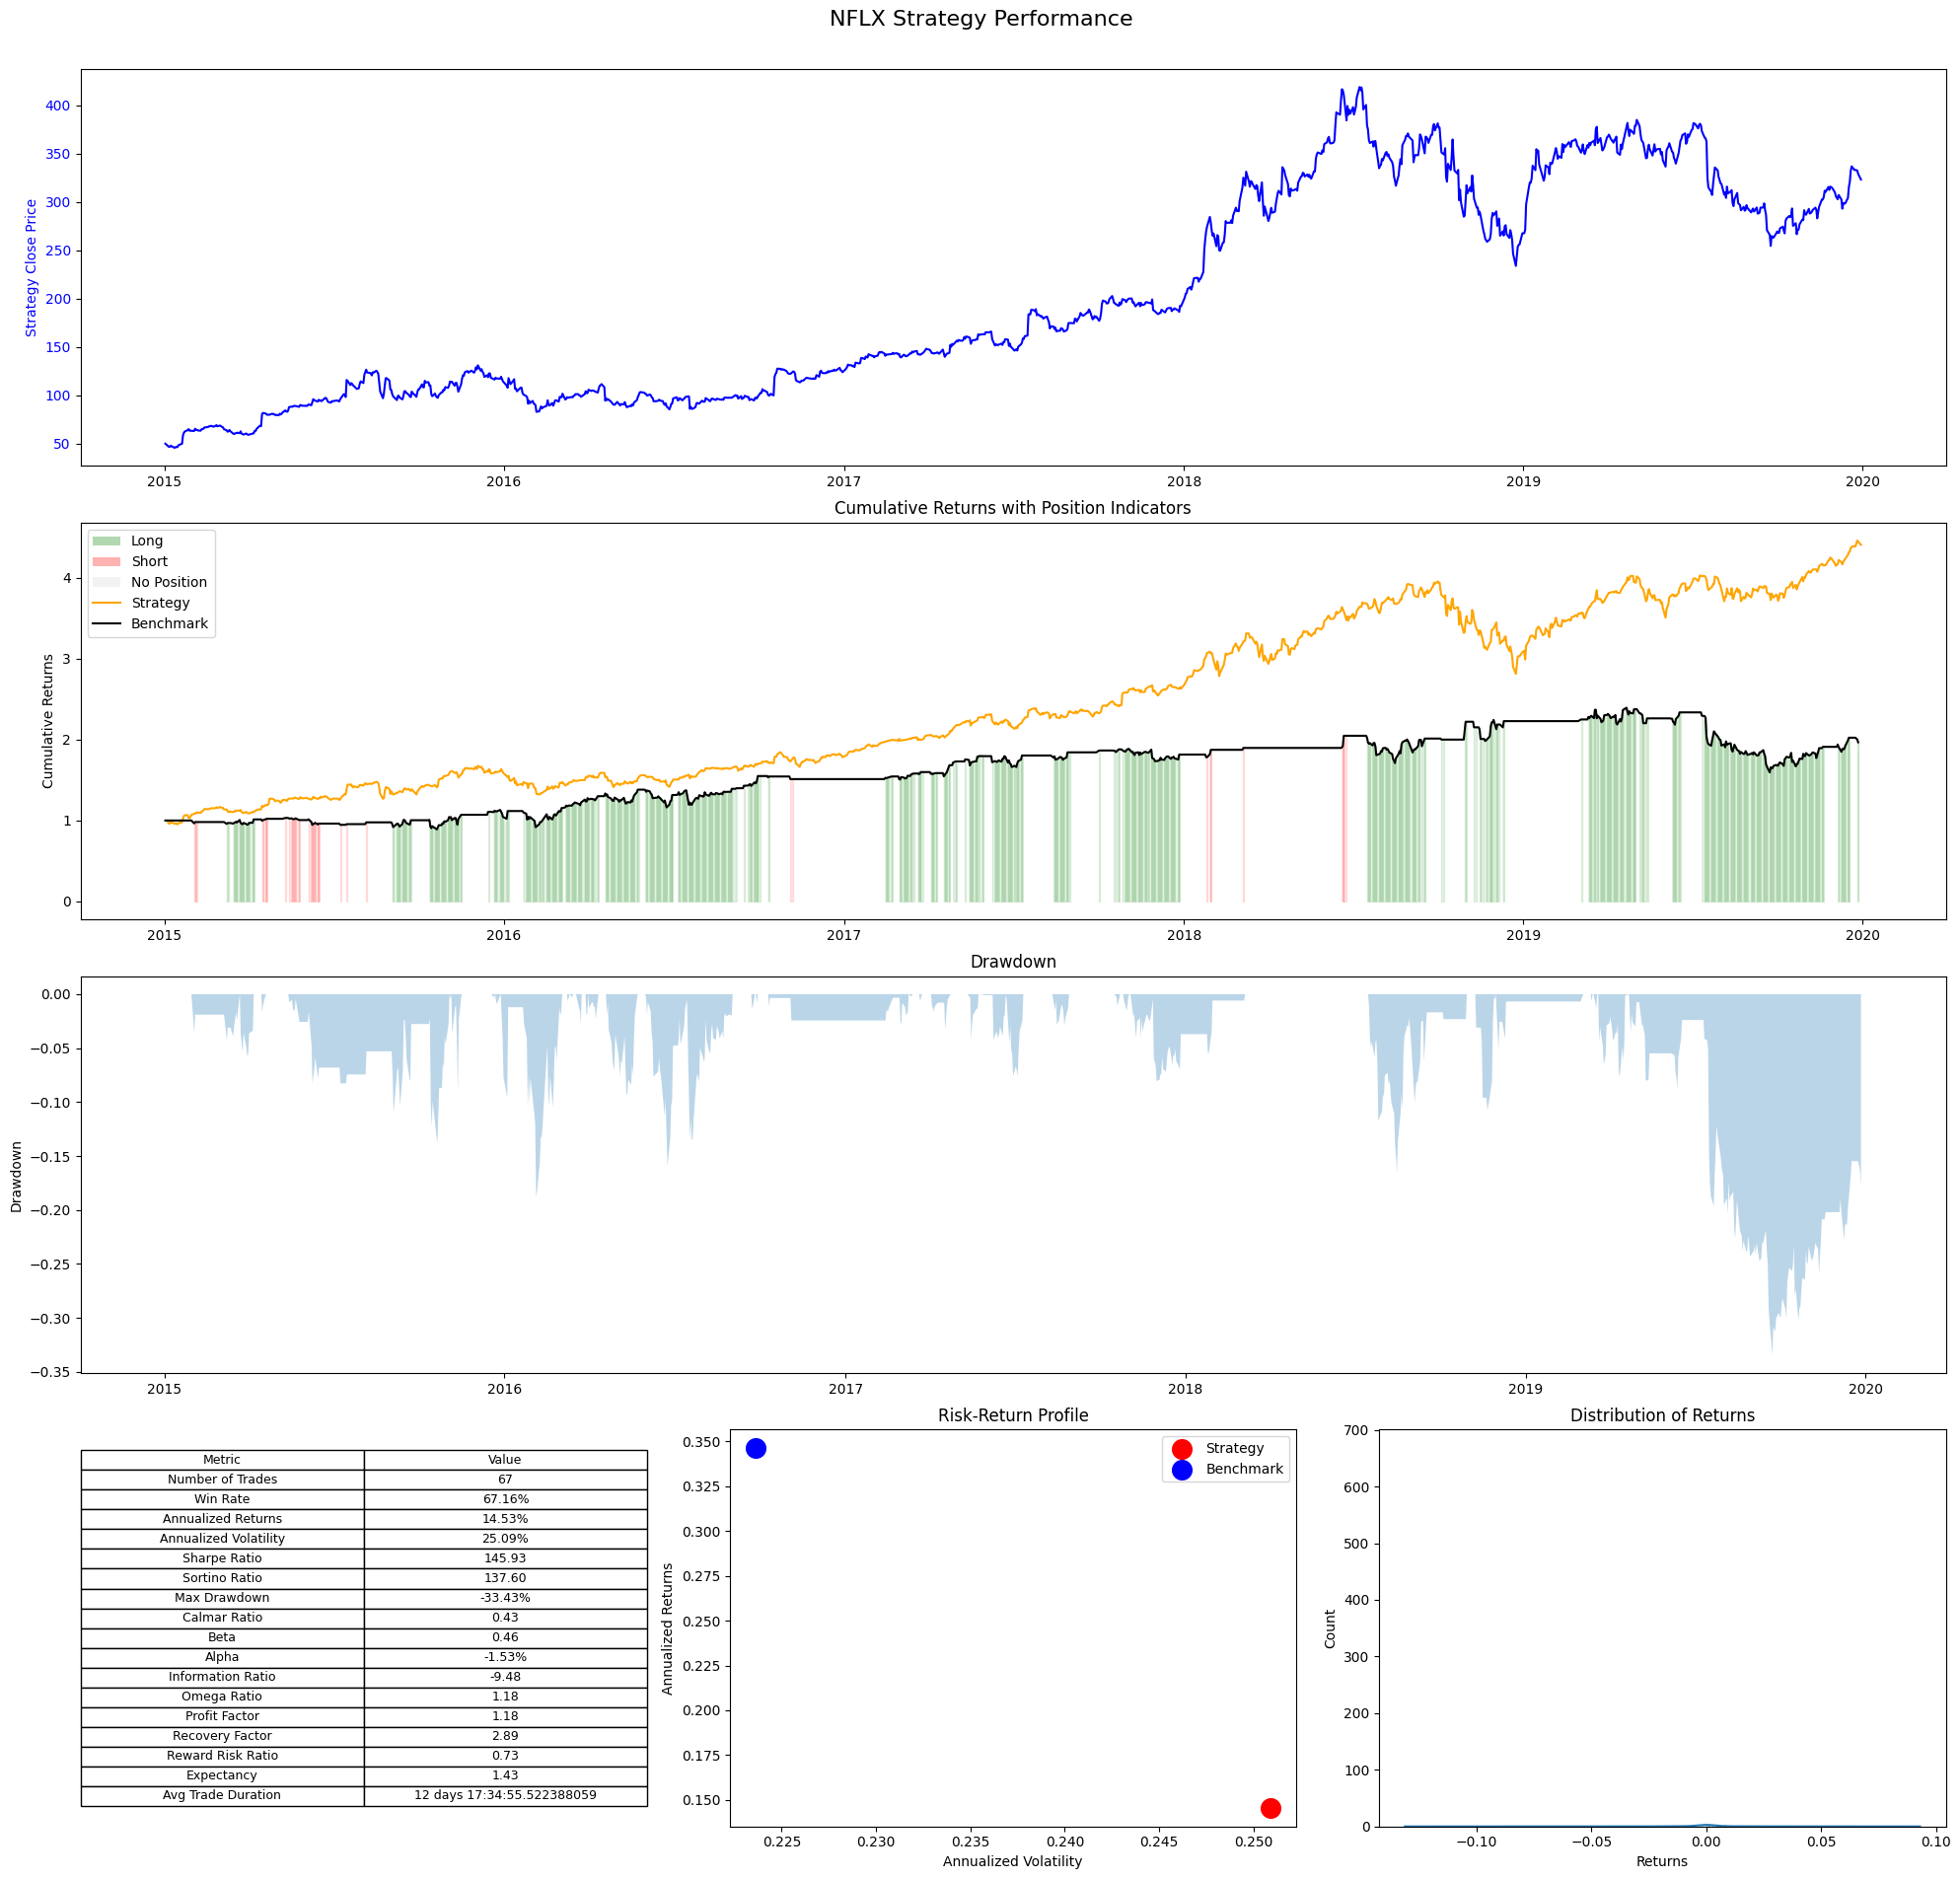

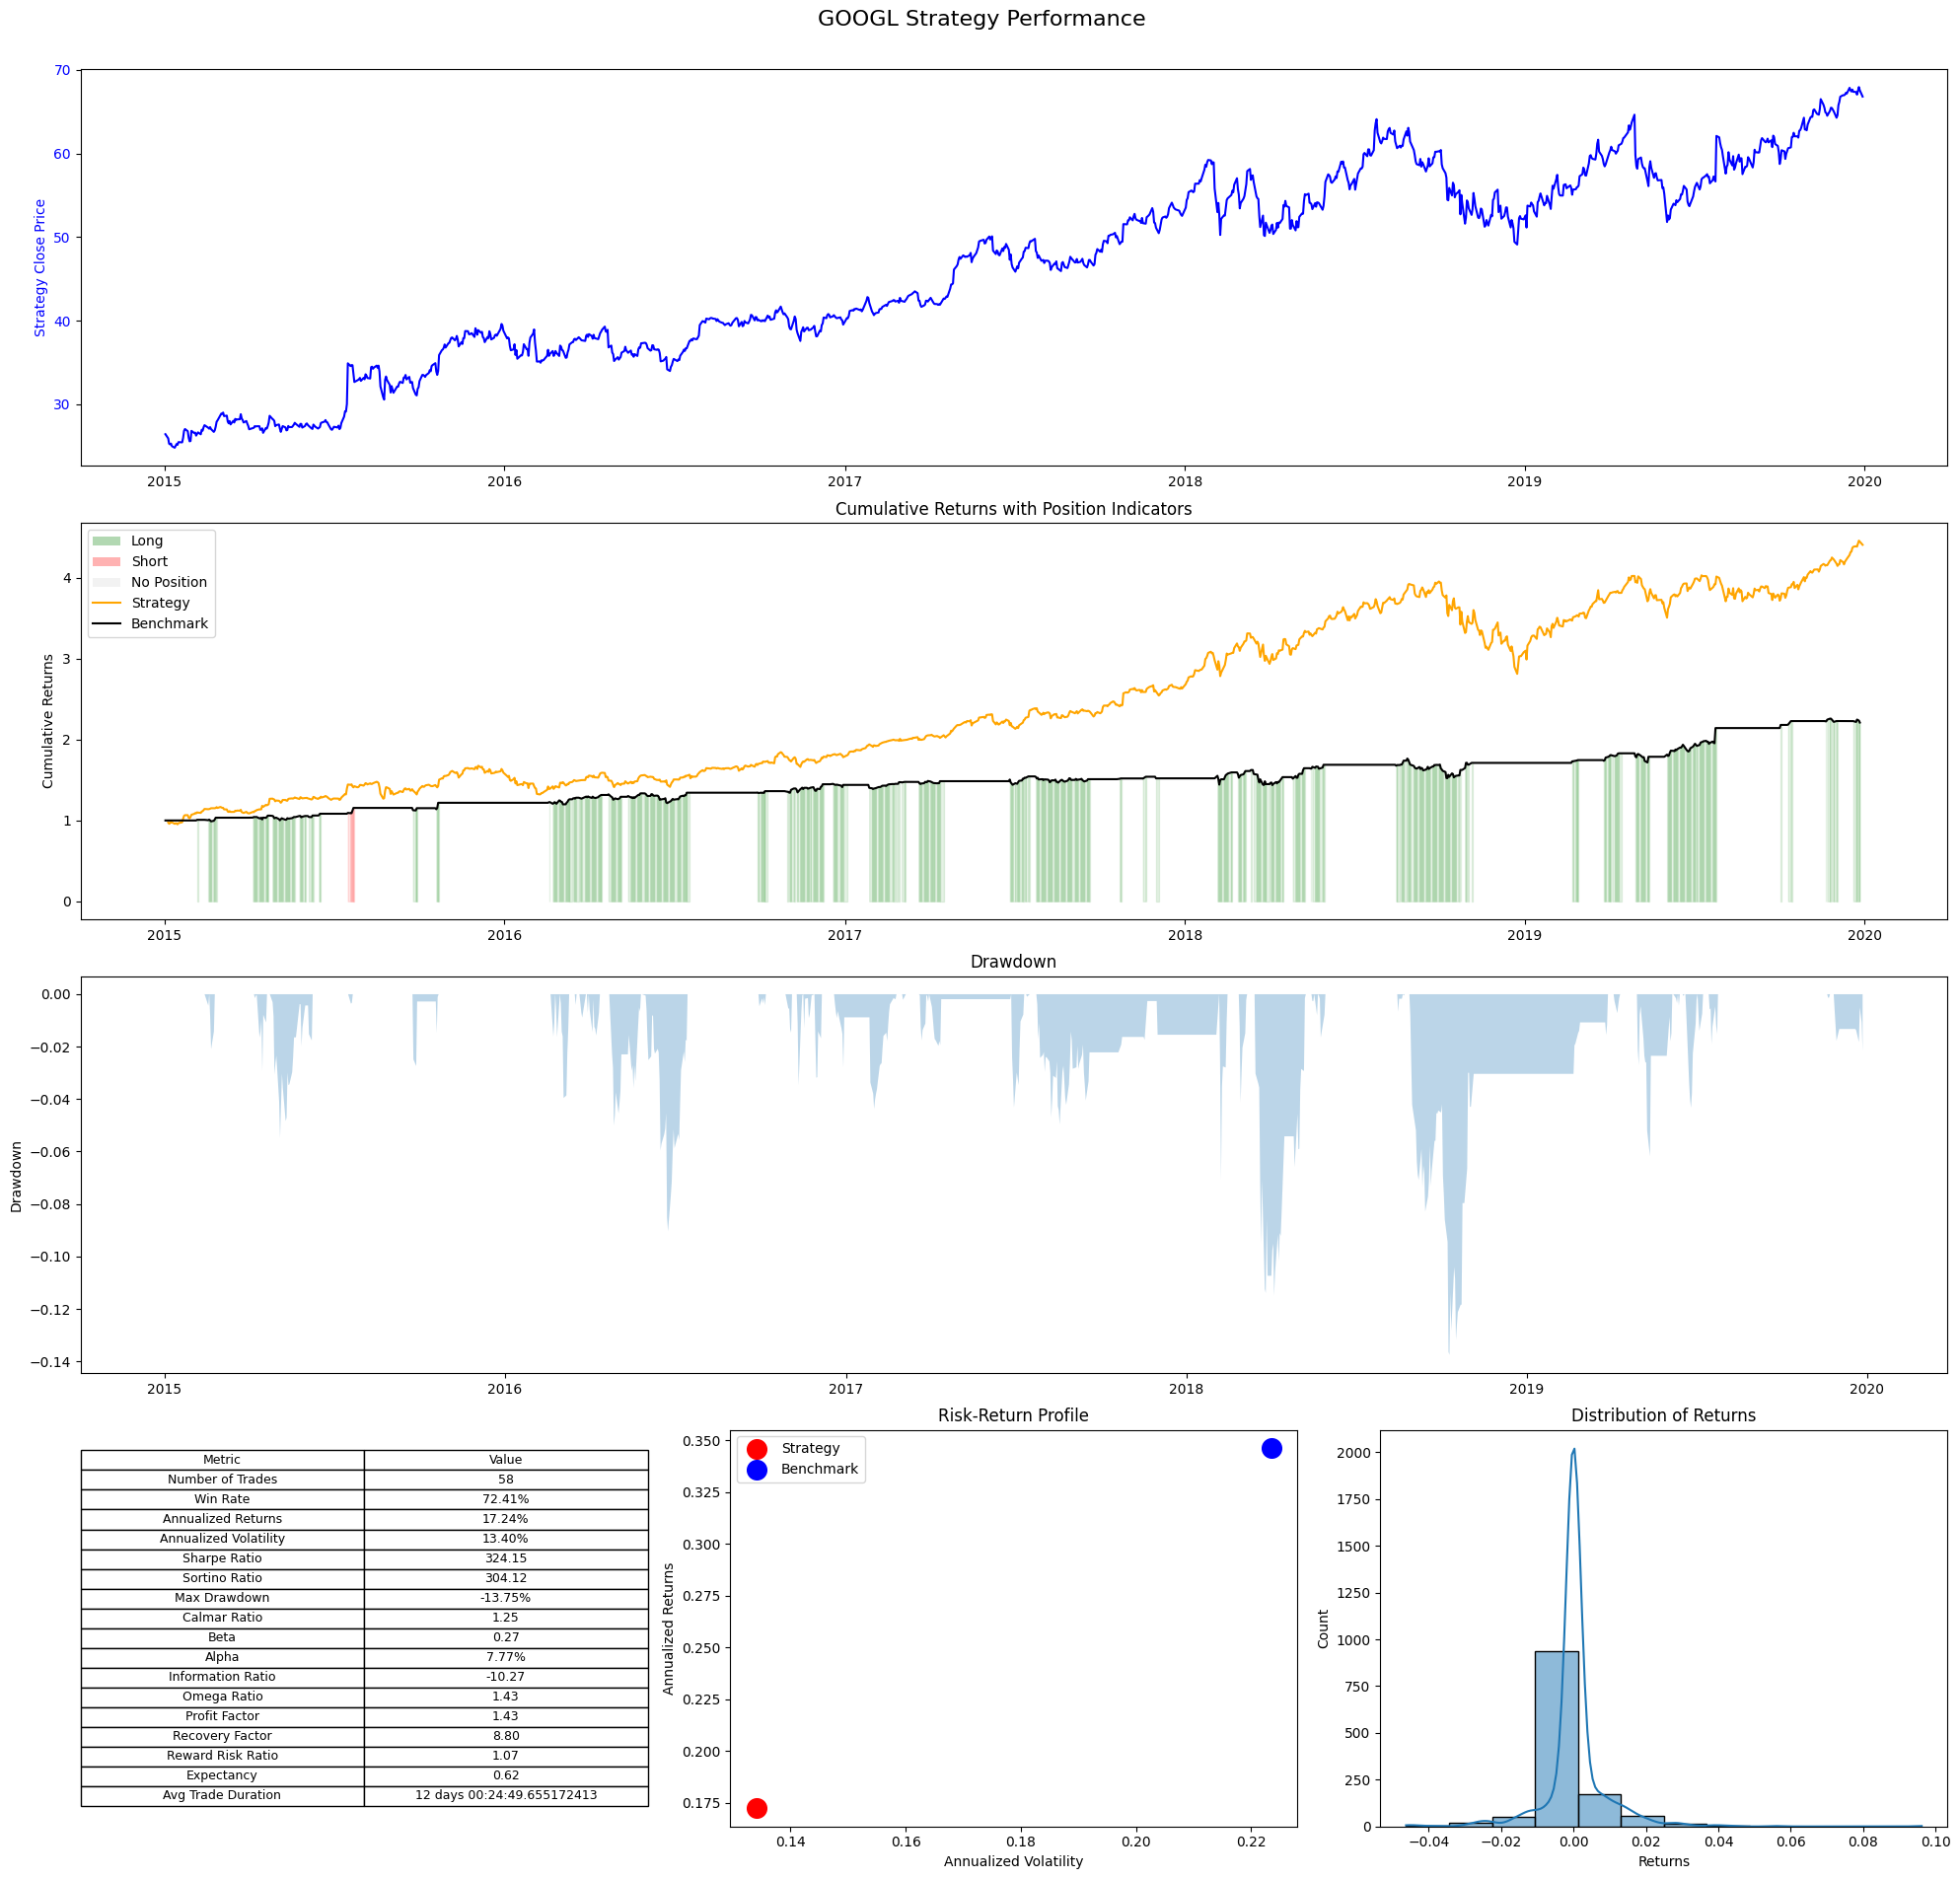

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_6497/181684543.py:183: RuntimeWarning: divide by zero encountered in scalar divide
  'benchmark_annualized_treynor': (benchmark_metrics['benchmark_annualized_return'] - risk_free_rate) / 0,


{'number_strategies': 5,
 'portfolio_annualized_return': 0.09942527251917821,
 'portfolio_annualized_volatility': 0.092995948686895,
 'portfolio_sharpe_ratio': 1.069135526042429,
 'portfolio_sortino_ratio': 1.0450764958453098,
 'portfolio_max_drawdown': 0.09546674657344788,
 'portfolio_calmar_ratio': 1.0414649717080786,
 'benchmark_annualized_return': 0.3494678033057319,
 'benchmark_annualized_volatility': 0.22366917856298818,
 'benchmark_sharpe_ratio': 1.562431648164332,
 'benchmark_sortino_ratio': 1.514278044806894,
 'benchmark_max_drawdown': 0.2889565247930169,
 'benchmark_calmar_ratio': 1.209413089239151,
 'beta': -0.0034297950167675993,
 'alpha': 0.10062387544947693,
 'portfolio_annualized_treynor': -28.988692336745327,
 'benchmark_annualized_treynor': inf,
 'annualized_information': -0.9292568625412769,
 'portfolio_omega_ratio': 1.2315888701390605,
 'benchmark_omega_ratio': 1.3013852752720843,
 'portfolio_profit_factor': 1.2315888701390605,
 'benchmark_profit_factor': 1.301385275

In [24]:
rsi_mcweighted_list_strategies = []

for s in maang_stocks:
    strategy = YFinance_RSI_MCWEIGHTED_Strategy(
        symbol=s,
        start_date = '2015-01-01',
        end_date = '2019-12-31',
        interval = '1d',
        params = {'rsi_window' : 21, 'upper_limit' : 20, 'lower_limit' : 2.5},
        benchmark_symbol=s,
        risk_free_rate=0.0
    )
    strategy.strategy()
    strategy.calculate_strategy_performance()
    strategy.plot_performance()
    rsi_mcweighted_list_strategies.append(strategy)

portfolio_rsi_mcweighted = YFinancePortfolio(rsi_mcweighted_list_strategies)
portfolio_rsi_mcweighted.calculate_portfolio_performance()

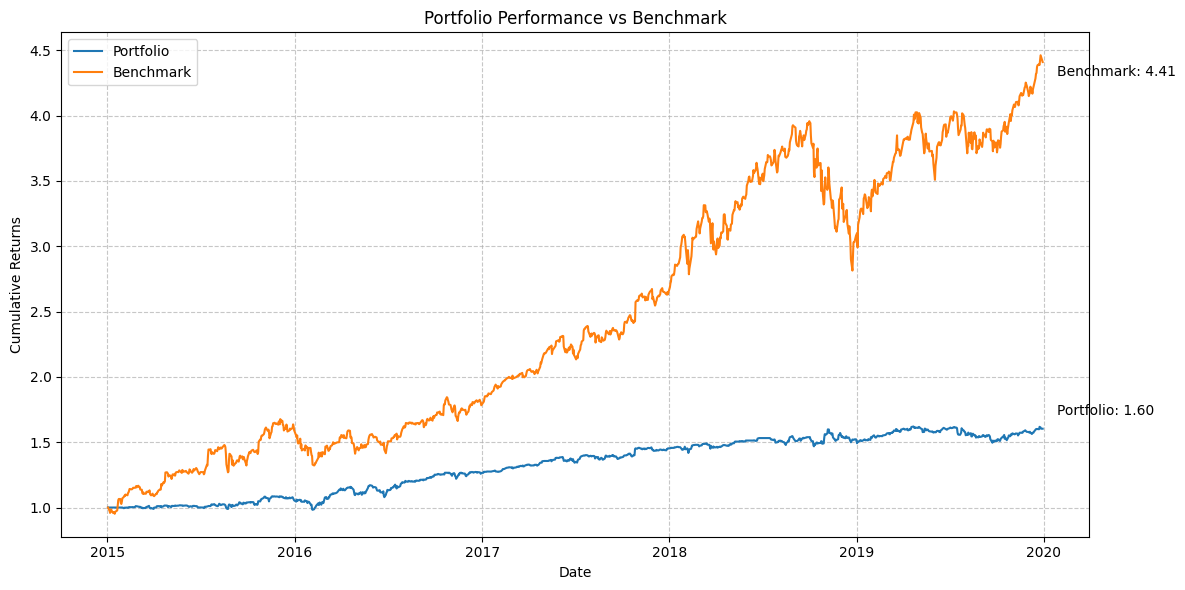

In [25]:
portfolio_rsi_mcweighted.plot_overall_portfolio_performance()

In [26]:
portfolio_rsi_mcweighted.portfolio_performance

{'number_strategies': 5,
 'portfolio_annualized_return': 0.09942527251917821,
 'portfolio_annualized_volatility': 0.092995948686895,
 'portfolio_sharpe_ratio': 1.069135526042429,
 'portfolio_sortino_ratio': 1.0450764958453098,
 'portfolio_max_drawdown': 0.09546674657344788,
 'portfolio_calmar_ratio': 1.0414649717080786,
 'benchmark_annualized_return': 0.3494678033057319,
 'benchmark_annualized_volatility': 0.22366917856298818,
 'benchmark_sharpe_ratio': 1.562431648164332,
 'benchmark_sortino_ratio': 1.514278044806894,
 'benchmark_max_drawdown': 0.2889565247930169,
 'benchmark_calmar_ratio': 1.209413089239151,
 'beta': -0.0034297950167675993,
 'alpha': 0.10062387544947693,
 'portfolio_annualized_treynor': -28.988692336745327,
 'benchmark_annualized_treynor': inf,
 'annualized_information': -0.9292568625412769,
 'portfolio_omega_ratio': 1.2315888701390605,
 'benchmark_omega_ratio': 1.3013852752720843,
 'portfolio_profit_factor': 1.2315888701390605,
 'benchmark_profit_factor': 1.301385275

# Conclusion

In this notebook we provide an equal-weighted portfolio of MAANG(Meta, Aaple, Amazon, Netflix, Google) with the same long-short strategy utilizing the RSI of a security and the RSI of the industry. We then utilized a simple grid-search optimization technique to find all the possible parameters, and chose the portfolio with the highest annualized return and sharpe ratio. 

The performance of the strategy does not perform better than a Buy-and-Hold strategy for the equal weighted portfolio of MAANG. However, some key metrics to might shed some light on how the performance of the portfolio compares to a BnH strategy.

1. Risk
   1. Annualized volatility is much lower compared to benchmark (9.28% vs 22.36%). So then we can expect much more stable returns from the strategy as compared to a BnH.
   2. Max drawdown for the portfolio is at 9.5%, compared to 28.9% for the BnH strategy, indicating better downside protection.
   3. Much lower beta than BnH at 0.309, suggesting the portfolio is less sensitive to market movements.

2. Returns
   1. Portfolio annualized returns are significantly lower at 10.42% compared to a BnH at 34.68%.

3. Performance Metrics
   1. Alpha is slightly negative (-0.32%), which means that the portfolio marginally underperformed on a risk-adjusted basis.
   2. Portfolio Sharpe (1.12), Sortino (1.10), and Calmar (1.09) ratios did not perform better than the Benchmark (1.55, 1.50, and 1.20 respectively).
   3. The Information Ratio is -1.32, indicating underperformance relative to the benchmark given the level of active risk taken.
   4. Omega Ratio and Profit Factor both at 1.24 suggest that the strategy has 24% more gains than losses relative to the target return.
   5. Recovery Factor of 6.69 is quite high, suggesting strong overall returns relative to the maximum drawdown.

The portfolio demonstrates strong risk management with significantly lower volatility and drawdown compared to the benchmark, but at the cost of substantially lower returns. While risk-adjusted metrics are positive, they underperform the benchmark. 

Our team believes that the core foundation of the strategy works, however, we can improve on the limitations mentioned above.